In [5]:
import datetime
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import warnings
import sklearn
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from contextlib import contextmanager
from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from bayes_opt import BayesianOptimization

from skopt import BayesSearchCV

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

FEATS_EXCLUDED = ['target', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
                  'OOF_PRED', 'month_0', 'hist_purchase_date_ptp', 'new_purchase_date_ptp'
                 ]
from sklearn.metrics import fbeta_score, make_scorer
import optuna
import xgboost as xgb

In [2]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [443]:
train_df0 = pd.read_csv('/Users/jincui/Downloads/ELO/train.csv', index_col=['card_id'])
test_df0 = pd.read_csv('/Users/jincui/Downloads/ELO/test.csv', index_col=['card_id'])
train_df0['outliers'] = 0
train_df0.loc[train_df0['target'] < -30, 'outliers'] = 1

test_df0['target'] = np.nan

df = train_df0.append(test_df0)
del train_df0, test_df0
gc.collect()
#df

523

In [4]:
def ratio_one(x):
    return len(x[x==1.0])/len(x)

def ratio_zero(x):
    return len(x[x==0.0])/len(x)

def ratio_minusone(x):
    return len(x[x==-1.0])/len(x)

In [5]:
df['first_active_month'] = pd.to_datetime(df['first_active_month'])

df['first_active_year'] = df['first_active_month'].dt.year

# non-accumlative
df['first_active_quarter'] = df['first_active_month'].dt.quarter


df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days

df['days_feature1'] = df['elapsed_time'] * df['feature_1']
df['days_feature2'] = df['elapsed_time'] * df['feature_2']
df['days_feature3'] = df['elapsed_time'] * df['feature_3']

df['days_feature1_ratio'] = df['feature_1'] / df['elapsed_time']
df['days_feature2_ratio'] = df['feature_2'] / df['elapsed_time']
df['days_feature3_ratio'] = df['feature_3'] / df['elapsed_time']

df, cols = one_hot_encoder(df, nan_as_category=False)

# replace features with mean value in the outliers
####

'''
for f in ['feature_1','feature_2','feature_3']:
    order_label = df.groupby([f])['outliers'].mean()
    df[f] = df[f].map(order_label)
####

df['feature_sum'] = df['feature_1'] + df['feature_2'] + df['feature_3']
df['feature_mean'] = df['feature_sum']/3
df['feature_max'] = df[['feature_1', 'feature_2', 'feature_3']].max(axis=1)
df['feature_min'] = df[['feature_1', 'feature_2', 'feature_3']].min(axis=1)
df['feature_var'] = df[['feature_1', 'feature_2', 'feature_3']].std(axis=1)
df['feature_dot'] = df['feature_1'] * df['feature_2'] * df['feature_3']
df['feature_sumsq'] = df['feature_1']**2 + df['feature_2']**2 + df['feature_3']**2


'''


df['first_active_Month'] = df['first_active_month'].dt.month

df

feature_1  feature_2  feature_3 first_active_month  outliers  \
card_id                                                                         
C_ID_92a2005557          5          2          1         2017-06-01       0.0   
C_ID_3d0044924f          4          1          0         2017-01-01       0.0   
C_ID_d639edf6cd          2          2          0         2016-08-01       0.0   
C_ID_186d6a6901          4          3          0         2017-09-01       0.0   
C_ID_cdbd2c0db2          1          3          0         2017-11-01       0.0   
C_ID_0894217f2f          4          2          0         2016-09-01       0.0   
C_ID_7e63323c00          3          2          1         2016-12-01       0.0   
C_ID_dfa21fc124          3          2          1         2017-09-01       0.0   
C_ID_fe0fdac8ea          2          1          0         2017-08-01       0.0   
C_ID_bf62c0b49d          2          2          0         2016-08-01       0.0   
C_ID_92853cdb2c          5          2          1         2016-10-01       0.0   
C_ID_269d816788          2          2          0         2016-03-01       0.0   
C_ID_61d50d7057          5          2          1         2017-09-01       0.0   
C_ID_4e07413433          2          1          0         2017-04-01       0.0   
C_ID_b6302b31c6          3          2          1         2017-08-01       0.0   
C_ID_3b69154173          2          1          0         2017-02-01       0.0   
C_ID_9feec11e78          2          2          0         2016-07-01       0.0   
C_ID_f6658dbefe          4          2          0         2016-12-01       0.0   
C_ID_4a7dda0f9e          2          1          0         2017-11-01       0.0   
C_ID_6adae2a906          4          1          0         2017-01-01       0.0   
C_ID_0b70ca7347          5          2          1         2017-09-01       0.0   
C_ID_25b2509282          1          2          0         2016-06-01       0.0   
C_ID_82fb11db22          2          2          0         2017-09-01       0.0   
C_ID_e03db05bde          2          2          0         2017-10-01       0.0   
C_ID_dcb7c76747          5          1          1         2015-10-01       0.0   
C_ID_749cfc0c3a          2          2          0         2016-04-01       0.0   
C_ID_4a97126360          2          3          0         2017-07-01       0.0   
C_ID_17dea8d446          3          3          1         2017-09-01       0.0   
C_ID_fcef0dfd67          5          1          1         2016-01-01       0.0   
C_ID_82868156f0          5          2          1         2016-06-01       0.0   
...                    ...        ...        ...                ...       ...   
C_ID_cd42a5db89          2          2          0         2016-07-01       NaN   
C_ID_715b9a183d          3          2          1         2017-08-01       NaN   
C_ID_9b25df3309          2          2          0         2017-11-01       NaN   
C_ID_043b3c2ccd          3          2          1         2017-02-01       NaN   
C_ID_7685eae7b2          3          2          1         2017-01-01       NaN   
C_ID_7ee1a21a95          4          1          0         2017-11-01       NaN   
C_ID_2bf12fed6b          2          3          0         2017-09-01       NaN   
C_ID_2932a6ea37          1          3          0         2016-12-01       NaN   
C_ID_cc33d0d508          2          1          0         2017-09-01       NaN   
C_ID_8852708dcb          4          3          0         2017-01-01       NaN   
C_ID_c3e88ef62d          1          1          0         2017-11-01       NaN   
C_ID_650557248c          2          1          0         2017-10-01       NaN   
C_ID_f14af9cb56          1          1          0         2017-05-01       NaN   
C_ID_068dcf31e8          5          1          1         2017-07-01       NaN   
C_ID_6659f4625a          3          2          1         2017-12-01       NaN   
C_ID_dc842bba27          3          2          1         2016-12-01       NaN   
C_ID_bd625edce0          3          3          1

In [10]:
df['first_active_year'].value_counts()

2017.0    210509
2016.0     82672
2015.0     22747
2014.0      7278
2013.0      1820
2012.0       435
2018.0        63
2011.0        15
Name: first_active_year, dtype: int64

In [456]:
hist_df = pd.read_csv('/Users/jincui/Downloads/ELO/historical_transactions.csv', )
new_merchant_df = pd.read_csv('/Users/jincui/Downloads/ELO/new_merchant_transactions.csv', )
hist_df = hist_df.set_index('card_id')
new_merchant_df = new_merchant_df.set_index('card_id')

In [439]:
hist_df.head()

authorized_flag          card_id  city_id category_1  installments  \
0               Y  C_ID_4e6213e9bc       88          N             0   
1               Y  C_ID_4e6213e9bc       88          N             0   
2               Y  C_ID_4e6213e9bc       88          N             0   
3               Y  C_ID_4e6213e9bc       88          N             0   
4               Y  C_ID_4e6213e9bc       88          N             0   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          A                    80  M_ID_e020e9b302         -8   
1          A                   367  M_ID_86ec983688         -7   
2          A                    80  M_ID_979ed661fc         -6   
3          A                   560  M_ID_e6d5ae8ea6         -5   
4          A                    80  M_ID_e020e9b302        -11   

   purchase_amount        purchase_date  category_2  state_id  subsector_id  
0        -0.703331  2017-06-25 15:33:07         1.0        16            37  
1        -0.733128  2017-07-15 12:10:45         1.0        16            16  
2        -0.720386  2017-08-09 22:04:29         1.0        16            37  
3        -0.735352  2017-09-02 10:06:26         1.0        16            34  
4        -0.722865  2017-03-10 01:14:19         1.0        16            37

In [440]:
hist_df['purchase_date'] = pd.to_datetime(hist_df['purchase_date'])

In [444]:
df['first_active_month'] = pd.to_datetime(df['first_active_month'])

In [450]:
hist_df = hist_df.set_index('card_id')
#df[['first_active_month']].head()

In [453]:
#hist_df = pd.concat([hist_df, df], axis=1, join_axes=[hist_df.index])
hist_df.head()

authorized_flag  city_id category_1  installments category_3  \
card_id                                                                        
C_ID_4e6213e9bc               Y       88          N             0          A   
C_ID_4e6213e9bc               Y       88          N             0          A   
C_ID_4e6213e9bc               Y       88          N             0          A   
C_ID_4e6213e9bc               Y       88          N             0          A   
C_ID_4e6213e9bc               Y       88          N             0          A   

                 merchant_category_id      merchant_id  month_lag  \
card_id                                                             
C_ID_4e6213e9bc                    80  M_ID_e020e9b302         -8   
C_ID_4e6213e9bc                   367  M_ID_86ec983688         -7   
C_ID_4e6213e9bc                    80  M_ID_979ed661fc         -6   
C_ID_4e6213e9bc                   560  M_ID_e6d5ae8ea6         -5   
C_ID_4e6213e9bc                    80  M_ID_e020e9b302        -11   

                 purchase_amount       purchase_date  category_2  state_id  \
card_id                                                                      
C_ID_4e6213e9bc        -0.703331 2017-06-25 15:33:07         1.0        16   
C_ID_4e6213e9bc        -0.733128 2017-07-15 12:10:45         1.0        16   
C_ID_4e6213e9bc        -0.720386 2017-08-09 22:04:29         1.0        16   
C_ID_4e6213e9bc        -0.735352 2017-09-02 10:06:26         1.0        16   
C_ID_4e6213e9bc        -0.722865 2017-03-10 01:14:19         1.0        16   

                 subsector_id  feature_1  feature_2  feature_3  \
card_id                                                          
C_ID_4e6213e9bc            37          3          3          1   
C_ID_4e6213e9bc            16          3          3          1   
C_ID_4e6213e9bc            37          3          3          1   
C_ID_4e6213e9bc            34          3          3          1   
C_ID_4e6213e9bc            37          3          3          1   

                first_active_month  outliers  target  
card_id                                               
C_ID_4e6213e9bc         2016-06-01       NaN     NaN  
C_ID_4e6213e9bc         2016-06-01       NaN     NaN  
C_ID_4e6213e9bc         2016-06-01       NaN     NaN  
C_ID_4e6213e9bc         2016-06-01       NaN     NaN  
C_ID_4e6213e9bc         2016-06-01       NaN     NaN

In [455]:
hist_df['month_lag'].describe()

count    2.911236e+07
mean    -4.487294e+00
std      3.588800e+00
min     -1.300000e+01
25%     -7.000000e+00
50%     -4.000000e+00
75%     -2.000000e+00
max      0.000000e+00
Name: month_lag, dtype: float64

In [482]:
for df in [hist_df, new_merchant_df]:
    # fillna
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    
    # installments is number of times customer pays for a merchant
    df['installments'].replace(-1, np.nan,inplace=True)
    df['installments'].replace(999, np.nan,inplace=True)

    # trim
    df['purchase_amount'] = df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    df['authorized_flag'] = df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    df['category_1'] = df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    df['category_3'] = df['category_3'].map({'A':0, 'B':1, 'C':2}).astype(int)

    # datetime features, I added quarter
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['purchase_quarter'] = df['purchase_date'].dt.quarter
    df['purchase_month'] = df['purchase_date'].dt.month
    df['purchase_day'] = df['purchase_date'].dt.day
    df['purchase_hour'] = df['purchase_date'].dt.hour
    df['purchase_weekofyear'] = df['purchase_date'].dt.weekofyear
    df['purchase_weekday'] = df['purchase_date'].dt.weekday
    df['purchase_weekend'] = (df['purchase_date'].dt.weekday >=5).astype(int)
    df['purchase_morning'] = (df['purchase_date'].dt.hour < 12).astype(int)
    
    # additional features
    ## if installments=0, it probably means the customers pay in full?
    df['price'] = df['purchase_amount'] / df['installments']
    
    # purchase_date is always btwn 2017-01-01 to 2018-02-28
    
    df['Christmas_Day_2017']=(pd.to_datetime('2017-12-25')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['Children_day_2017']=(pd.to_datetime('2017-10-12')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['September_Equinox_Day_2017']=(pd.to_datetime('2017-09-22')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['Childrens_Day_2017']=(pd.to_datetime('2017-10-12')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['June_Solstice_Day_2017']=(pd.to_datetime('2017-06-21')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100)) 
    df['Republic_Proclamation_Day_2017']=(pd.to_datetime('2017-11-15') - df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['Mothers_Day_2017']=(pd.to_datetime('2017-05-14')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['Fathers_Day_2017']=(pd.to_datetime('2017-08-13')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['Labour_Day_2017']=(pd.to_datetime('2017-05-1')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['Independence_Day_2017']=(pd.to_datetime('2017-05-13')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['Tirandentes_Day_2017']=(pd.to_datetime('2017-04-21')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['March_Equinox_Day_2017']=(pd.to_datetime('2017-03-20')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['Good_Friday_Day_2017']=(pd.to_datetime('2017-04-14')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['New_Years_Day_2017']=(pd.to_datetime('2017-01-01')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['New_Years_Eve__Day_2017']=(pd.to_datetime('2017-12-31')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['Carnivals_start_Day_2017']=(pd.to_datetime('2017-02-27')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['Carnivals_end_Day_2017']=(pd.to_datetime('2017-02-28')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['Carnivals_start_Day_2018']=(pd.to_datetime('2018-02-27')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['Carnivals_end_Day_2018']=(pd.to_datetime('2018-02-28')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    df['New_Years_Day_2018']=(pd.to_datetime('2018-01-01')-df['purchase_date']).dt.days.apply(lambda x: x if x > -100 and x < 100 else (-100 if x<=-100 else 100))
    
    # month_diff with lag
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

    # additional features
    df['duration'] = df['purchase_amount']*df['month_diff']
    df['amount_month_ratio'] = df['purchase_amount']/df['month_diff']
    

KeyboardInterrupt: 

In [ ]:
hist_df['month_diff'].head()

In [13]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [11]:
new_merchant_df['authorized_flag'] = 1

In [14]:
for df in [hist_df, new_merchant_df]:
    df = reduce_mem_usage(df)
    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id']
    
    col_seas = ['purchase_quarter', 'purchase_month', 'purchase_hour',
                'purchase_weekofyear', 'purchase_weekday']
    

    col_day = ['Christmas_Day_2017', 'Children_day_2017', 'September_Equinox_Day_2017',
                'Childrens_Day_2017', 'June_Solstice_Day_2017', 'Republic_Proclamation_Day_2017',
                'Mothers_Day_2017', 'Fathers_Day_2017', 'Labour_Day_2017', 'Independence_Day_2017',
                'Tirandentes_Day_2017', 'New_Years_Day_2017', 'March_Equinox_Day_2017', 
                'Good_Friday_Day_2017', 'New_Years_Eve__Day_2017', 'Carnivals_start_Day_2017',
                'Carnivals_end_Day_2017', 'Carnivals_start_Day_2018', 'Carnivals_end_Day_2018', 'New_Years_Day_2018']
    aggs = {}
    
    for col in col_unique:
        aggs[col] = ['nunique']
    for col in col_seas:
        aggs[col] = ['nunique', 'mean', 'min', 'max']
    for col in col_day:
        aggs[col] = ['mean']
        
    aggs['purchase_amount'] = ['sum','max', 'min', 'mean','var', 'skew', np.ptp]
    aggs['installments'] = ['sum','max','mean','var','skew']
    aggs['purchase_date'] = ['max','min', np.ptp]
    aggs['month_lag'] = ['max','min','mean','var','skew']
    aggs['month_diff'] = ['max','min','mean','var','skew']
    aggs['authorized_flag'] = ['mean']
    aggs['purchase_weekend'] = ['mean'] # overwrite
    ###
    aggs['purchase_day'] = ['nunique', 'mean', 'min'] # overwrite
    aggs['category_1'] = ['sum','mean']
    aggs['category_2'] = ['sum','mean']
    aggs['category_3'] = ['sum','mean']
    aggs['card_id'] = ['size','count']
    aggs['price'] = ['sum','mean','max','min','var']
    aggs['duration']=['mean','min','max','var','skew', np.ptp]
    aggs['amount_month_ratio']=['mean','min','max','var','skew']
    
    for col in ['category_2', 'category_3']:
        df[col+'_mean'] = df.groupby([col])['purchase_amount'].transform('mean')
        df[col+'_min'] = df.groupby([col])['purchase_amount'].transform('min')
        df[col+'_max'] = df.groupby([col])['purchase_amount'].transform('max')
        df[col+'_sum'] = df.groupby([col])['purchase_amount'].transform('sum')
        aggs[col+'_mean'] = ['mean']

    
    #df = df.reset_index().groupby('card_id').agg(aggs)
 
        

KeyboardInterrupt: 

In [ ]:
hist_df = hist_df.reset_index().groupby('card_id').agg(aggs)
new_merchant_df = new_merchant_df.reset_index().groupby('card_id').agg(aggs)

In [ ]:
new_merchant_df.shape

In [ ]:
hist_df.to_hdf('Elo_fe.h5', 'hist_df_agg')
new_merchant_df.to_hdf('Elo_fe.h5', 'new_merchant_df_agg')


In [ ]:
df.to_hdf('Elo_fe.h5', 'df_bf_agg')

In [115]:
hist_df = pd.read_hdf('Elo_fe.h5', 'hist_df_agg')
new_merchant_df = pd.read_hdf('Elo_fe.h5', 'new_merchant_df_agg')


In [219]:
df = pd.read_hdf('Elo_fe.h5', 'df_bf_agg')

In [25]:
[*hist_df.columns]

[('subsector_id', 'nunique'),
 ('merchant_id', 'nunique'),
 ('merchant_category_id', 'nunique'),
 ('purchase_quarter', 'nunique'),
 ('purchase_quarter', 'mean'),
 ('purchase_quarter', 'min'),
 ('purchase_quarter', 'max'),
 ('purchase_month', 'nunique'),
 ('purchase_month', 'mean'),
 ('purchase_month', 'min'),
 ('purchase_month', 'max'),
 ('purchase_hour', 'nunique'),
 ('purchase_hour', 'mean'),
 ('purchase_hour', 'min'),
 ('purchase_hour', 'max'),
 ('purchase_weekofyear', 'nunique'),
 ('purchase_weekofyear', 'mean'),
 ('purchase_weekofyear', 'min'),
 ('purchase_weekofyear', 'max'),
 ('purchase_weekday', 'nunique'),
 ('purchase_weekday', 'mean'),
 ('purchase_weekday', 'min'),
 ('purchase_weekday', 'max'),
 ('Christmas_Day_2017', 'mean'),
 ('Children_day_2017', 'mean'),
 ('September_Equinox_Day_2017', 'mean'),
 ('Childrens_Day_2017', 'mean'),
 ('June_Solstice_Day_2017', 'mean'),
 ('Republic_Proclamation_Day_2017', 'mean'),
 ('Mothers_Day_2017', 'mean'),
 ('Fathers_Day_2017', 'mean'),
 ('

In [116]:
hist_df.columns = pd.Index([e[0] + "_" + e[1] for e in hist_df.columns.tolist()])
hist_df.columns = ['hist_' + c for c in hist_df.columns]
hist_df['hist_purchase_date_diff'] = (hist_df['hist_purchase_date_max']-hist_df['hist_purchase_date_min']).dt.days
hist_df['hist_purchase_date_average'] = hist_df['hist_purchase_date_diff']/hist_df['hist_card_id_size']
hist_df['hist_purchase_date_uptonow'] = (datetime.datetime.today()-hist_df['hist_purchase_date_max']).dt.days
hist_df['hist_purchase_date_uptomin'] = (datetime.datetime.today()-hist_df['hist_purchase_date_min']).dt.days

hist_df = reduce_mem_usage(hist_df)

new_merchant_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_merchant_df.columns.tolist()])
new_merchant_df.columns = ['new_'+ c for c in new_merchant_df.columns]
new_merchant_df['new_purchase_date_diff'] = (new_merchant_df['new_purchase_date_max']-new_merchant_df['new_purchase_date_min']).dt.days
new_merchant_df['new_purchase_date_average'] = new_merchant_df['new_purchase_date_diff']/new_merchant_df['new_card_id_size']
new_merchant_df['new_purchase_date_uptonow'] = (datetime.datetime.today()-new_merchant_df['new_purchase_date_max']).dt.days
new_merchant_df['new_purchase_date_uptomin'] = (datetime.datetime.today()-new_merchant_df['new_purchase_date_min']).dt.days

new_merchant_df = reduce_mem_usage(new_merchant_df)



Memory usage after optimization is: 72.34 MB
Decreased by 60.4%
Memory usage after optimization is: 62.50 MB
Decreased by 60.2%


In [20]:
def additional_features(df):
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_last_buy'] = (df['new_purchase_date_max'] - df['first_active_month']).dt.days

    date_features=['hist_purchase_date_max','hist_purchase_date_min',
                   'new_purchase_date_max', 'new_purchase_date_min']

    for f in date_features:
        df[f] = df[f].astype(np.int64) * 1e-9

    df['card_id_total'] = df['new_card_id_size']+df['hist_card_id_size']
    df['card_id_cnt_total'] = df['new_card_id_count']+df['hist_card_id_count']
    df['card_id_cnt_ratio'] = df['new_card_id_count']/df['hist_card_id_count']
    df['purchase_amount_total'] = df['new_purchase_amount_sum']+df['hist_purchase_amount_sum']
    df['purchase_amount_mean'] = df['new_purchase_amount_mean']+df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_purchase_amount_max']+df['hist_purchase_amount_max']
    df['purchase_amount_min'] = df['new_purchase_amount_min']+df['hist_purchase_amount_min']
    df['purchase_amount_ratio'] = df['new_purchase_amount_sum']/df['hist_purchase_amount_sum']
    df['month_diff_mean'] = df['new_month_diff_mean']+df['hist_month_diff_mean']
    df['month_diff_ratio'] = df['new_month_diff_mean']/df['hist_month_diff_mean']
    df['month_lag_mean'] = df['new_month_lag_mean']+df['hist_month_lag_mean']
    df['month_lag_max'] = df['new_month_lag_max']+df['hist_month_lag_max']
    df['month_lag_min'] = df['new_month_lag_min']+df['hist_month_lag_min']
    df['category_1_mean'] = df['new_category_1_mean']+df['hist_category_1_mean']
    df['installments_total'] = df['new_installments_sum']+df['hist_installments_sum']
    df['installments_mean'] = df['new_installments_mean']+df['hist_installments_mean']
    df['installments_max'] = df['new_installments_max']+df['hist_installments_max']
    df['installments_ratio'] = df['new_installments_sum']/df['hist_installments_sum']
    df['price_total'] = df['purchase_amount_total'] / df['installments_total']
    df['price_mean'] = df['purchase_amount_mean'] / df['installments_mean']
    df['price_max'] = df['purchase_amount_max'] / df['installments_max']
    df['duration_mean'] = df['new_duration_mean']+df['hist_duration_mean']
    df['duration_min'] = df['new_duration_min']+df['hist_duration_min']
    df['duration_max'] = df['new_duration_max']+df['hist_duration_max']
    df['amount_month_ratio_mean']=df['new_amount_month_ratio_mean']+df['hist_amount_month_ratio_mean']
    df['amount_month_ratio_min']=df['new_amount_month_ratio_min']+df['hist_amount_month_ratio_min']
    df['amount_month_ratio_max']=df['new_amount_month_ratio_max']+df['hist_amount_month_ratio_max']
    df['new_CLV'] = df['new_card_id_count'] * df['new_purchase_amount_sum'] / df['new_month_diff_mean']
    df['hist_CLV'] = df['hist_card_id_count'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
    df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']

    return df

In [ ]:
''' Experimenting'''

In [117]:
df.shape

(325540, 21)

In [118]:
df = pd.merge(df, hist_df, on='card_id', how='outer')
df.shape

(325540, 124)

In [119]:
df = pd.merge(df, new_merchant_df, on='card_id', how='outer')
df.shape

(325540, 227)

In [120]:
df = additional_features(df)
df.shape

(325540, 261)

In [121]:
hist = pd.read_csv('/Users/jincui/Downloads/ELO/historical_transactions.csv', )
new = pd.read_csv('/Users/jincui/Downloads/ELO/new_merchant_transactions.csv', )
hist.head()

authorized_flag          card_id  city_id category_1  installments  \
0               Y  C_ID_4e6213e9bc       88          N             0   
1               Y  C_ID_4e6213e9bc       88          N             0   
2               Y  C_ID_4e6213e9bc       88          N             0   
3               Y  C_ID_4e6213e9bc       88          N             0   
4               Y  C_ID_4e6213e9bc       88          N             0   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          A                    80  M_ID_e020e9b302         -8   
1          A                   367  M_ID_86ec983688         -7   
2          A                    80  M_ID_979ed661fc         -6   
3          A                   560  M_ID_e6d5ae8ea6         -5   
4          A                    80  M_ID_e020e9b302        -11   

   purchase_amount        purchase_date  category_2  state_id  subsector_id  
0        -0.703331  2017-06-25 15:33:07         1.0        16            37  
1        -0.733128  2017-07-15 12:10:45         1.0        16            16  
2        -0.720386  2017-08-09 22:04:29         1.0        16            37  
3        -0.735352  2017-09-02 10:06:26         1.0        16            34  
4        -0.722865  2017-03-10 01:14:19         1.0        16            37

In [122]:
df['has_transaction_in_hist'] = 0
df['has_transaction_in_hist'][[*set(df.index) & set(hist.card_id)]] = 1
df['has_transaction_in_new'] = 0
df['has_transaction_in_new'][[*set(df.index) & set(new.card_id)]] = 1


In [123]:
del hist
del new
gc.collect()

7

In [124]:
train_ = pd.read_csv('/Users/jincui/Downloads/ELO/train.csv', index_col=['card_id'])
test_ = pd.read_csv('/Users/jincui/Downloads/ELO/test.csv', index_col=['card_id'])
df['feature_1_orig'] = train_.append(test_)['feature_1']
df['feature_2_orig'] = train_.append(test_)['feature_2']
df['feature_3_orig'] = train_.append(test_)['feature_3']
del train_
del test_
gc.collect()

70

In [125]:
df.shape

(325540, 266)

In [126]:
hist_add = pd.read_hdf('Elo_fe.h5', 'hist_add')
new_add = pd.read_hdf('Elo_fe.h5', 'new_add')
hist_add.drop(['hist_Max', 'hist_Min'], axis=1, inplace=True)
new_add.drop(['new_Max', 'new_Min'], axis=1, inplace=True)
hist_add = hist_add.set_index('card_id')
new_add = new_add.set_index('card_id')
df = df.join(hist_add, how='left')


In [127]:
df.shape

(325540, 273)

In [128]:
df = df.join(new_add, how='left')
df.shape

(325540, 280)

In [129]:
del hist_add
del new_add
gc.collect()

35

In [130]:
df.shape

(325540, 280)

In [ ]:
''' Experimenting'''

In [131]:
df['first_active_month'] = pd.to_datetime(df['first_active_month'])
df['first_active_year'] = df['first_active_month'].dt.year
# non-accumlative
df['first_active_quarter'] = df['first_active_month'].dt.quarter
df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
df['first_active_month'] = df['first_active_month'].dt.month

df.dtypes


feature_1                            float64
feature_2                            float64
feature_3                            float64
first_active_month                   float64
outliers                             float64
target                               float64
quarter                              float64
elapsed_time                         float64
days_feature1                        float64
days_feature2                        float64
days_feature3                        float64
days_feature1_ratio                  float64
days_feature2_ratio                  float64
days_feature3_ratio                  float64
feature_sum                          float64
feature_mean                         float64
feature_max                          float64
feature_min                          float64
feature_var                          float64
feature_dot                          float64
feature_sumsq                        float64
hist_subsector_id_nunique               int8
hist_merch

In [78]:
pd.DataFrame(df.dtypes)

0
feature_1                            int64
feature_2                            int64
feature_3                            int64
first_active_month                 float64
outliers                           float64
target                             float64
quarter                            float64
elapsed_time                       float64
days_feature1                      float64
days_feature2                      float64
days_feature3                      float64
days_feature1_ratio                float64
days_feature2_ratio                float64
days_feature3_ratio                float64
feature_sum                        float64
feature_mean                       float64
feature_max                        float64
feature_min                        float64
feature_var                        float64
feature_dot                        float64
feature_sumsq                      float64
hist_subsector_id_nunique             int8
hist_merchant_id_nunique             int16
hist_merchant_category_id_nunique     int8
hist_purchase_quarter_nunique         int8
hist_purchase_quarter_mean         float16
hist_purchase_quarter_min             int8
hist_purchase_quarter_max             int8
hist_purchase_month_nunique           int8
hist_purchase_month_mean           float16
...                                    ...
card_id_cnt_ratio                  float64
purchase_amount_total              float16
purchase_amount_mean               float16
purchase_amount_max                float16
purchase_amount_min                float16
purchase_amount_ratio              float16
month_diff_mean                    float16
month_diff_ratio                   float16
month_lag_mean                     float16
month_lag_max                      float64
month_lag_min                      float64
category_1_mean                    float16
installments_total                 float16
installments_mean                  float16
installments_max                   float16
installments_ratio                 float16
price_total                        float16
price_mean                         float16
price_max                          float16
duration_mean                      float16
duration_min                       float16
duration_max                       float16
amount_month_ratio_mean            float16
amount_month_ratio_min             float16
amount_month_ratio_max             float16
new_CLV                            float64
hist_CLV                           float32
CLV_ratio                          float64
first_active_year                  float64
first_active_quarter               float64

[263 rows x 1 columns]

In [132]:
df['hist_purchase_quarter_min'].value_counts()

1    298421
2     14242
3     11017
4      1860
Name: hist_purchase_quarter_min, dtype: int64

In [85]:
[c for c in df.columns if df[c].dtypes in ['int8', 'int16', 'int64']]


['feature_1',
 'feature_2',
 'feature_3',
 'hist_subsector_id_nunique',
 'hist_merchant_id_nunique',
 'hist_merchant_category_id_nunique',
 'hist_purchase_quarter_nunique',
 'hist_purchase_quarter_min',
 'hist_purchase_quarter_max',
 'hist_purchase_month_nunique',
 'hist_purchase_month_min',
 'hist_purchase_month_max',
 'hist_purchase_hour_nunique',
 'hist_purchase_hour_min',
 'hist_purchase_hour_max',
 'hist_purchase_weekofyear_nunique',
 'hist_purchase_weekofyear_min',
 'hist_purchase_weekofyear_max',
 'hist_purchase_weekday_nunique',
 'hist_purchase_weekday_min',
 'hist_purchase_weekday_max',
 'hist_month_lag_max',
 'hist_month_lag_min',
 'hist_month_diff_max',
 'hist_month_diff_min',
 'hist_purchase_day_nunique',
 'hist_purchase_day_min',
 'hist_card_id_size',
 'hist_card_id_count',
 'hist_purchase_date_diff',
 'hist_purchase_date_uptonow',
 'hist_purchase_date_uptomin']

In [133]:
df.to_hdf('Elo_fe.h5', 'df_final')

In [222]:
df = pd.read_hdf('Elo_fe.h5', 'df_final')

In [218]:
train_df = df[df['target'].notnull()]
test_df = df[df['target'].isnull()]

In [235]:
def kfold_lightgbm(train_df, test_df, num_folds, stratified = False, debug= False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    categorical_features = ['feature_1_orig', 'feature_2_orig', 'feature_3_orig','first_active_year', 'first_active_month', 'first_active_year', 'first_active_quarter']

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=326)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        # set data structure
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                categorical_feature=categorical_features)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               categorical_feature=categorical_features)

        # params optimized by optuna
        params ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**n_fold),
                'bagging_seed':int(2**n_fold),
                'drop_seed':int(2**n_fold)
                }

        reg = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_test],
                        valid_names=['train', 'test'],
                        num_boost_round=10000,
                        early_stopping_rounds= 200,
                        verbose_eval=100
                        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
                
        sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('RMSE is {}'.format(rmse(oof_preds, train_df['target'])))
    return sub_preds, feature_importance_df
   

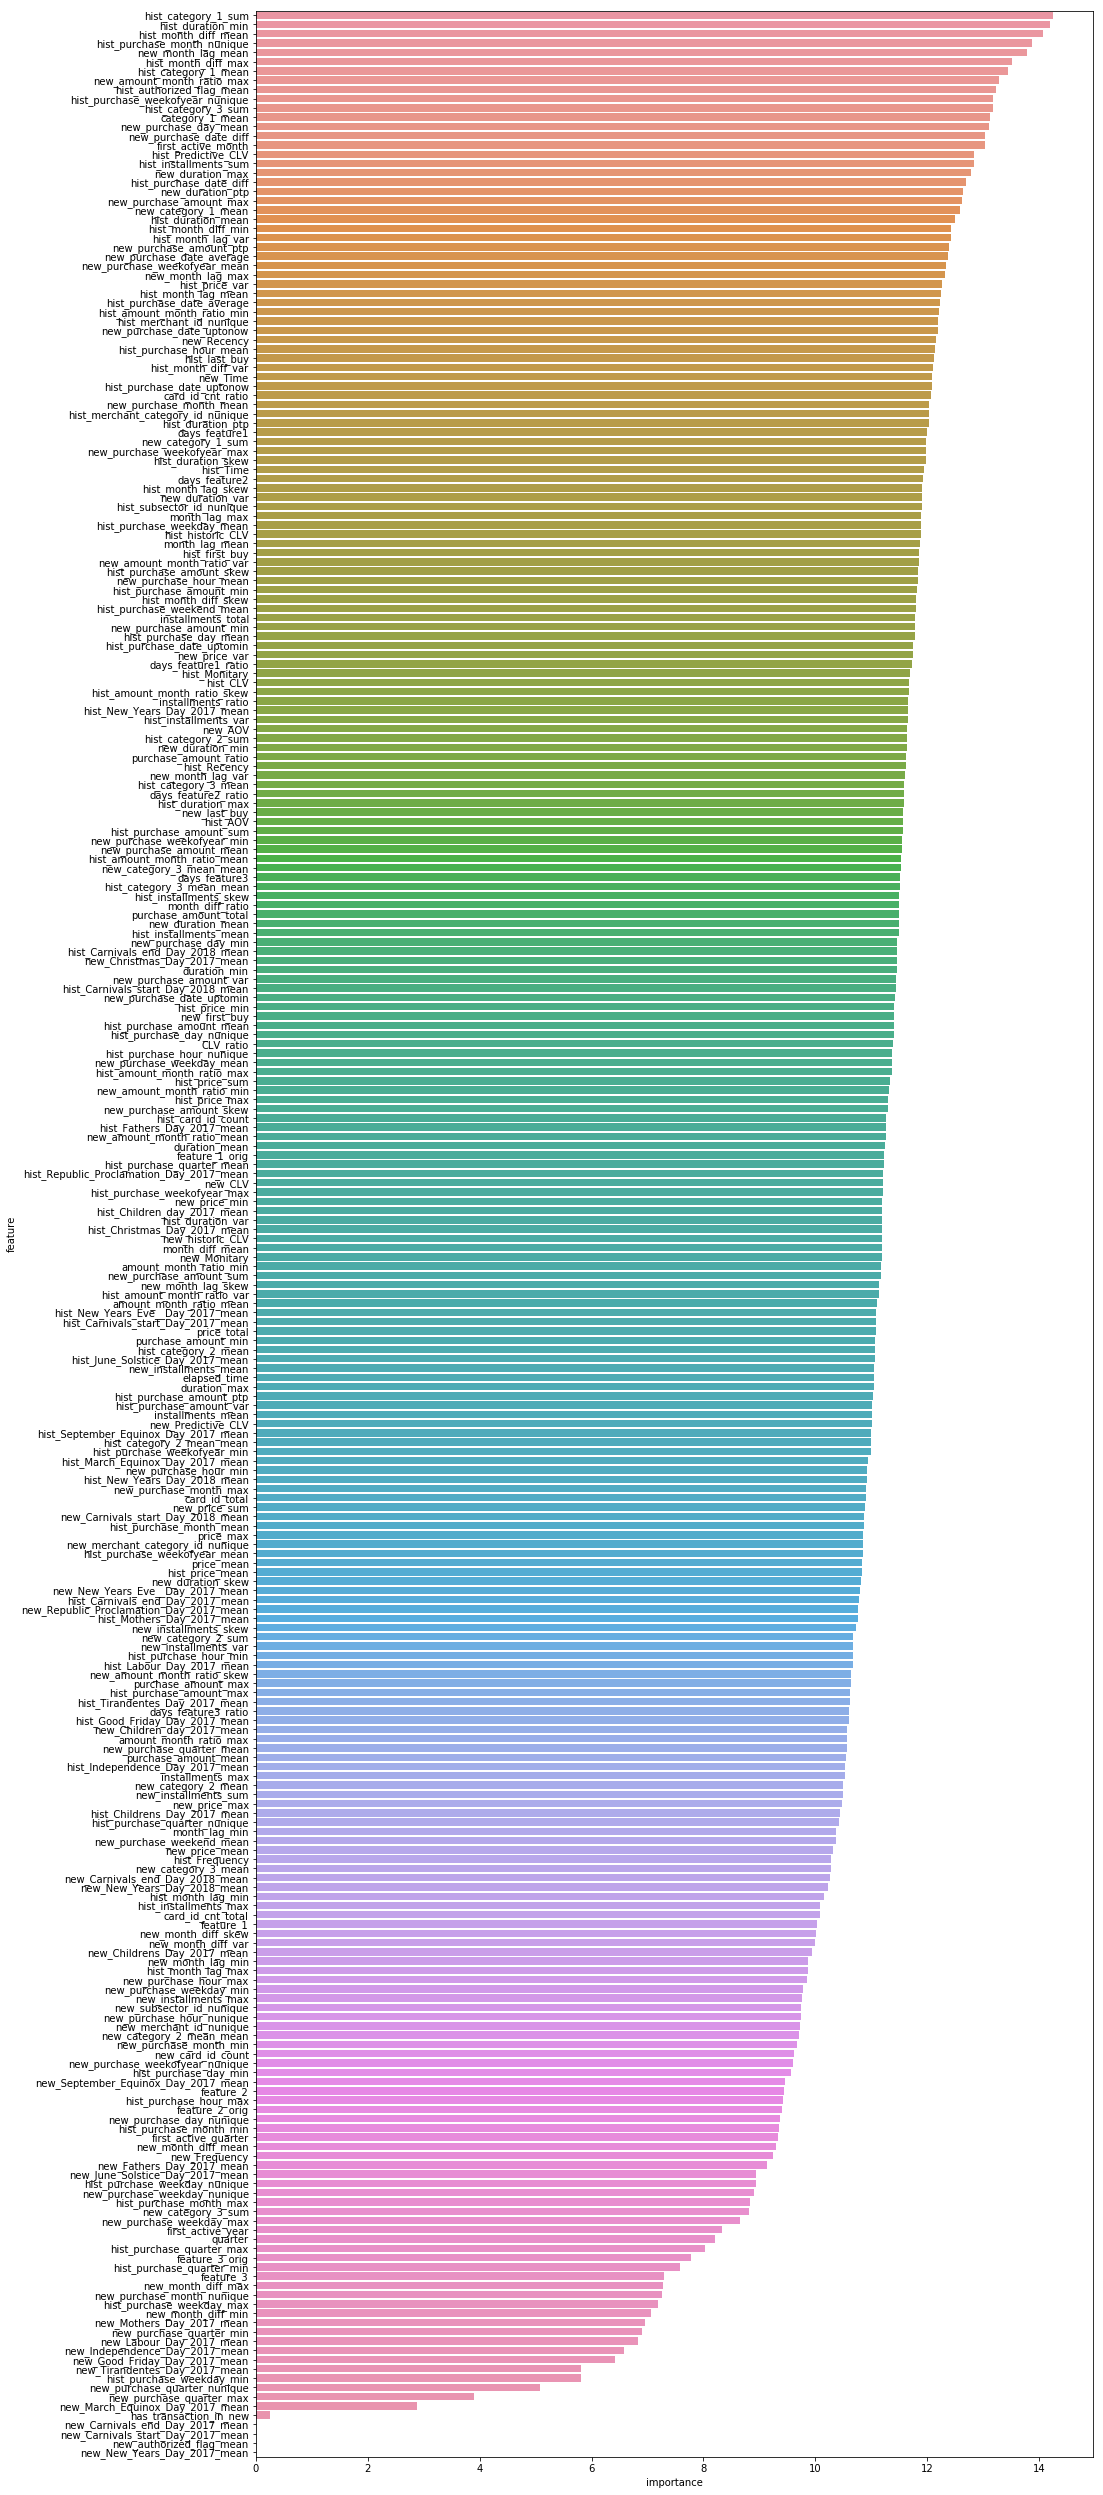

In [193]:
t1 = _[['feature', 'importance']][_['fold']==1]
t2 = _[['feature', 'importance']][_['fold']==2]
t3 = _[['feature', 'importance']][_['fold']==3]
t1 = t1.set_index('feature')
t2 = t2.set_index('feature')
t3 = t3.set_index('feature')

t00 = (t1['importance'] + t2['importance'] + t3['importance'])/3
t00 = t00.reset_index()
plt.figure(figsize=(15,45))
sns.barplot(x="importance",
            y="feature",
            data=t00.sort_values(by="importance", ascending=False))
      

In [191]:
## CV 3.64837
## LB 3.694

excluded_features = ['feature_sum','feature_mean','feature_max','feature_min','feature_var','feature_dot','feature_sumsq', 'has_transaction_in_hist']
train_df = train_df.drop(excluded_features, axis=1)
test_df = test_df.drop(excluded_features, axis=1)
for df in [train_df, test_df]:
    for col in df.columns:
        if col in ['target', 'outliers']:
            pass
        elif (df[col].isna().sum() > 0):
            if (df[col].dtypes == 'float'):
                df[col] = df[col].fillna(0.0)
            elif (df[col].dtypes == 'int'):
                df[col] = df[col].fillna(0)
            else:
                pass

sub_preds_1, _ = kfold_lightgbm(train_df, test_df, num_folds=11, stratified=True, debug=False)  


Starting LightGBM. Train shape: (201917, 274), test shape: (123623, 274)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66098	test's rmse: 3.69344
[200]	train's rmse: 3.58248	test's rmse: 3.65439
[300]	train's rmse: 3.53427	test's rmse: 3.63754
[400]	train's rmse: 3.4999	test's rmse: 3.62964
[500]	train's rmse: 3.47269	test's rmse: 3.6256
[600]	train's rmse: 3.44944	test's rmse: 3.62346
[700]	train's rmse: 3.42777	test's rmse: 3.62242
[800]	train's rmse: 3.40857	test's rmse: 3.62193
[900]	train's rmse: 3.38795	test's rmse: 3.62124
[1000]	train's rmse: 3.3695	test's rmse: 3.62132
[1100]	train's rmse: 3.35355	test's rmse: 3.6207
[1200]	train's rmse: 3.33644	test's rmse: 3.62098
[1300]	train's rmse: 3.32146	test's rmse: 3.62057
[1400]	train's rmse: 3.30709	test's rmse: 3.62023
[1500]	train's rmse: 3.29214	test's rmse: 3.62028
[1600]	train's rmse: 3.27795	test's rmse: 3.62061
Early stopping, best iteration is:
[1463]	train's rmse: 3.29837	test's rmse: 3.62012
Fold  1 RMSE : 3.620120


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65867	test's rmse: 3.70379
[200]	train's rmse: 3.57958	test's rmse: 3.66974
[300]	train's rmse: 3.53073	test's rmse: 3.65676
[400]	train's rmse: 3.49502	test's rmse: 3.65153
[500]	train's rmse: 3.46812	test's rmse: 3.64876
[600]	train's rmse: 3.44381	test's rmse: 3.64732
[700]	train's rmse: 3.42184	test's rmse: 3.64634
[800]	train's rmse: 3.40162	test's rmse: 3.64585
[900]	train's rmse: 3.384	test's rmse: 3.64516
[1000]	train's rmse: 3.36794	test's rmse: 3.64566
Early stopping, best iteration is:
[853]	train's rmse: 3.39157	test's rmse: 3.64493
Fold  2 RMSE : 3.644933


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65901	test's rmse: 3.7049
[200]	train's rmse: 3.58114	test's rmse: 3.66607
[300]	train's rmse: 3.53269	test's rmse: 3.65399
[400]	train's rmse: 3.49839	test's rmse: 3.64849
[500]	train's rmse: 3.47243	test's rmse: 3.64558
[600]	train's rmse: 3.45107	test's rmse: 3.64433
[700]	train's rmse: 3.42968	test's rmse: 3.64268
[800]	train's rmse: 3.4107	test's rmse: 3.64197
[900]	train's rmse: 3.39145	test's rmse: 3.6417
[1000]	train's rmse: 3.37413	test's rmse: 3.64107
[1100]	train's rmse: 3.35791	test's rmse: 3.64123
[1200]	train's rmse: 3.34085	test's rmse: 3.64109
[1300]	train's rmse: 3.32537	test's rmse: 3.64095
[1400]	train's rmse: 3.31093	test's rmse: 3.64074
[1500]	train's rmse: 3.29763	test's rmse: 3.64087
[1600]	train's rmse: 3.28332	test's rmse: 3.6414
Early stopping, best iteration is:
[1418]	train's rmse: 3.30856	test's rmse: 3.64057
Fold  3 RMSE : 3.640574


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65745	test's rmse: 3.71638
[200]	train's rmse: 3.57647	test's rmse: 3.68757
[300]	train's rmse: 3.527	test's rmse: 3.67836
[400]	train's rmse: 3.49324	test's rmse: 3.67417
[500]	train's rmse: 3.46642	test's rmse: 3.67208
[600]	train's rmse: 3.44357	test's rmse: 3.6714
[700]	train's rmse: 3.42152	test's rmse: 3.67049
[800]	train's rmse: 3.40095	test's rmse: 3.67028
[900]	train's rmse: 3.38167	test's rmse: 3.6705
[1000]	train's rmse: 3.36322	test's rmse: 3.67128
Early stopping, best iteration is:
[851]	train's rmse: 3.39067	test's rmse: 3.67001
Fold  4 RMSE : 3.670012


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65958	test's rmse: 3.71338
[200]	train's rmse: 3.58079	test's rmse: 3.67763
[300]	train's rmse: 3.53161	test's rmse: 3.6661
[400]	train's rmse: 3.49732	test's rmse: 3.66023
[500]	train's rmse: 3.46963	test's rmse: 3.65723
[600]	train's rmse: 3.44702	test's rmse: 3.65493
[700]	train's rmse: 3.4261	test's rmse: 3.65241
[800]	train's rmse: 3.40618	test's rmse: 3.65157
[900]	train's rmse: 3.387	test's rmse: 3.65096
[1000]	train's rmse: 3.36974	test's rmse: 3.65088
[1100]	train's rmse: 3.35305	test's rmse: 3.65072
[1200]	train's rmse: 3.33803	test's rmse: 3.65069
Early stopping, best iteration is:
[1036]	train's rmse: 3.36341	test's rmse: 3.65041
Fold  5 RMSE : 3.650412


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65831	test's rmse: 3.70338
[200]	train's rmse: 3.57964	test's rmse: 3.6669
[300]	train's rmse: 3.53197	test's rmse: 3.65324
[400]	train's rmse: 3.49936	test's rmse: 3.64637
[500]	train's rmse: 3.47275	test's rmse: 3.64334
[600]	train's rmse: 3.44919	test's rmse: 3.64009
[700]	train's rmse: 3.4271	test's rmse: 3.63784
[800]	train's rmse: 3.40671	test's rmse: 3.63674
[900]	train's rmse: 3.3881	test's rmse: 3.63589
[1000]	train's rmse: 3.37059	test's rmse: 3.63533
[1100]	train's rmse: 3.35351	test's rmse: 3.63507
[1200]	train's rmse: 3.33769	test's rmse: 3.635
[1300]	train's rmse: 3.32233	test's rmse: 3.63462
[1400]	train's rmse: 3.30616	test's rmse: 3.63471
[1500]	train's rmse: 3.29219	test's rmse: 3.63442
[1600]	train's rmse: 3.27748	test's rmse: 3.63457
[1700]	train's rmse: 3.26368	test's rmse: 3.63469
Early stopping, best iteration is:
[1585]	train's rmse: 3.27935	test's rmse: 3.63431
Fold  6 RMSE : 3

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66233	test's rmse: 3.6852
[200]	train's rmse: 3.58454	test's rmse: 3.64295
[300]	train's rmse: 3.53598	test's rmse: 3.62652
[400]	train's rmse: 3.50224	test's rmse: 3.61822
[500]	train's rmse: 3.47617	test's rmse: 3.61387
[600]	train's rmse: 3.45406	test's rmse: 3.6113
[700]	train's rmse: 3.43313	test's rmse: 3.60989
[800]	train's rmse: 3.41368	test's rmse: 3.60912
[900]	train's rmse: 3.3946	test's rmse: 3.60871
[1000]	train's rmse: 3.37724	test's rmse: 3.60932
Early stopping, best iteration is:
[887]	train's rmse: 3.39725	test's rmse: 3.60835
Fold  7 RMSE : 3.608347


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65459	test's rmse: 3.73504
[200]	train's rmse: 3.57448	test's rmse: 3.71097
[300]	train's rmse: 3.5252	test's rmse: 3.7042
[400]	train's rmse: 3.49075	test's rmse: 3.7013
[500]	train's rmse: 3.46416	test's rmse: 3.69985
[600]	train's rmse: 3.44064	test's rmse: 3.69882
[700]	train's rmse: 3.41859	test's rmse: 3.69849
[800]	train's rmse: 3.39727	test's rmse: 3.69849
[900]	train's rmse: 3.37797	test's rmse: 3.69908
Early stopping, best iteration is:
[704]	train's rmse: 3.41773	test's rmse: 3.69833
Fold  8 RMSE : 3.698332


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.6586	test's rmse: 3.71098
[200]	train's rmse: 3.57988	test's rmse: 3.67822
[300]	train's rmse: 3.53005	test's rmse: 3.66712
[400]	train's rmse: 3.49631	test's rmse: 3.66307
[500]	train's rmse: 3.46955	test's rmse: 3.65939
[600]	train's rmse: 3.446	test's rmse: 3.65662
[700]	train's rmse: 3.42442	test's rmse: 3.65556
[800]	train's rmse: 3.40378	test's rmse: 3.6552
[900]	train's rmse: 3.38499	test's rmse: 3.65515
[1000]	train's rmse: 3.36794	test's rmse: 3.65511
[1100]	train's rmse: 3.35187	test's rmse: 3.65472
[1200]	train's rmse: 3.33597	test's rmse: 3.65467
[1300]	train's rmse: 3.32112	test's rmse: 3.65472
[1400]	train's rmse: 3.30637	test's rmse: 3.65509
Early stopping, best iteration is:
[1217]	train's rmse: 3.33339	test's rmse: 3.65442
Fold  9 RMSE : 3.654422


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66053	test's rmse: 3.6858
[200]	train's rmse: 3.58327	test's rmse: 3.64767
[300]	train's rmse: 3.53412	test's rmse: 3.63357
[400]	train's rmse: 3.50018	test's rmse: 3.62893
[500]	train's rmse: 3.47538	test's rmse: 3.62626
[600]	train's rmse: 3.45392	test's rmse: 3.62474
[700]	train's rmse: 3.43247	test's rmse: 3.62458
[800]	train's rmse: 3.41287	test's rmse: 3.62411
[900]	train's rmse: 3.39502	test's rmse: 3.62361
[1000]	train's rmse: 3.37602	test's rmse: 3.62309
[1100]	train's rmse: 3.35841	test's rmse: 3.62351
Early stopping, best iteration is:
[973]	train's rmse: 3.38127	test's rmse: 3.62294
Fold 10 RMSE : 3.622937


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65567	test's rmse: 3.72852
[200]	train's rmse: 3.57597	test's rmse: 3.70408
[300]	train's rmse: 3.52681	test's rmse: 3.69492
[400]	train's rmse: 3.49317	test's rmse: 3.69198
[500]	train's rmse: 3.46631	test's rmse: 3.69019
[600]	train's rmse: 3.44298	test's rmse: 3.68908
[700]	train's rmse: 3.42052	test's rmse: 3.68813
[800]	train's rmse: 3.39911	test's rmse: 3.6877
[900]	train's rmse: 3.38031	test's rmse: 3.68722
[1000]	train's rmse: 3.36184	test's rmse: 3.68702
[1100]	train's rmse: 3.3452	test's rmse: 3.68733
Early stopping, best iteration is:
[956]	train's rmse: 3.37021	test's rmse: 3.68661
Fold 11 RMSE : 3.686611
RMSE is 3.648370072840758


In [183]:
## NOT GOOD


excluded_features = ['feature_sum','feature_mean','feature_max','feature_min','feature_var','feature_dot','feature_sumsq', 'has_transaction_in_hist']
excluded_features += ['hist_Christmas_Day_2017_mean','hist_September_Equinox_Day_2017_mean','hist_Childrens_Day_2017_mean',
 'hist_June_Solstice_Day_2017_mean','hist_Republic_Proclamation_Day_2017_mean','hist_Mothers_Day_2017_mean','hist_Fathers_Day_2017_mean','hist_Labour_Day_2017_mean','hist_Independence_Day_2017_mean','hist_Tirandentes_Day_2017_mean','hist_New_Years_Day_2017_mean',
 'hist_March_Equinox_Day_2017_mean','hist_Good_Friday_Day_2017_mean', 'hist_New_Years_Eve__Day_2017_mean','hist_Carnivals_start_Day_2017_mean',
 'hist_Carnivals_end_Day_2017_mean','new_Christmas_Day_2017_mean','new_September_Equinox_Day_2017_mean','new_Childrens_Day_2017_mean',
 'new_June_Solstice_Day_2017_mean','new_Republic_Proclamation_Day_2017_mean','new_Mothers_Day_2017_mean','new_Fathers_Day_2017_mean',
 'new_Labour_Day_2017_mean','new_Independence_Day_2017_mean','new_Tirandentes_Day_2017_mean','new_New_Years_Day_2017_mean','new_March_Equinox_Day_2017_mean',
 'new_Good_Friday_Day_2017_mean','new_New_Years_Eve__Day_2017_mean','new_Carnivals_start_Day_2017_mean','new_Carnivals_end_Day_2017_mean','hist_Carnivals_start_Day_2018_mean',
 'hist_Carnivals_end_Day_2018_mean','hist_New_Years_Day_2018_mean','new_Carnivals_start_Day_2018_mean','new_Carnivals_end_Day_2018_mean','new_New_Years_Day_2018_mean']

train_df = train_df.drop(excluded_features, axis=1)
test_df = test_df.drop(excluded_features, axis=1)
for df in [train_df, test_df]:
    for col in df.columns:
        if col in ['target', 'outliers']:
            pass
        elif (df[col].isna().sum() > 0):
            if (df[col].dtypes == 'float'):
                df[col] = df[col].fillna(0.0)
            elif (df[col].dtypes == 'int'):
                df[col] = df[col].fillna(0)
            else:
                pass

sub_preds_1, _ = kfold_lightgbm(train_df, test_df, num_folds=4, stratified=True, debug=False)  


Starting LightGBM. Train shape: (201917, 236), test shape: (123623, 236)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65666	test's rmse: 3.69717
[200]	train's rmse: 3.5754	test's rmse: 3.6601
[300]	train's rmse: 3.52155	test's rmse: 3.64618
[400]	train's rmse: 3.4835	test's rmse: 3.64009
[500]	train's rmse: 3.45353	test's rmse: 3.63703
[600]	train's rmse: 3.42975	test's rmse: 3.63524
[700]	train's rmse: 3.40842	test's rmse: 3.6341
[800]	train's rmse: 3.38838	test's rmse: 3.63355
[900]	train's rmse: 3.37142	test's rmse: 3.6335
[1000]	train's rmse: 3.35124	test's rmse: 3.63347
[1100]	train's rmse: 3.33286	test's rmse: 3.63357
[1200]	train's rmse: 3.31623	test's rmse: 3.63342
[1300]	train's rmse: 3.30012	test's rmse: 3.63346
[1400]	train's rmse: 3.28722	test's rmse: 3.63374
[1500]	train's rmse: 3.27306	test's rmse: 3.63383
Early stopping, best iteration is:
[1318]	train's rmse: 3.29777	test's rmse: 3.63334
Fold  1 RMSE : 3.633343


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.6483	test's rmse: 3.71263
[200]	train's rmse: 3.56333	test's rmse: 3.68189
[300]	train's rmse: 3.50953	test's rmse: 3.67138
[400]	train's rmse: 3.47009	test's rmse: 3.66708
[500]	train's rmse: 3.44139	test's rmse: 3.66512
[600]	train's rmse: 3.4159	test's rmse: 3.66409
[700]	train's rmse: 3.3936	test's rmse: 3.66451
[800]	train's rmse: 3.37209	test's rmse: 3.66468
Early stopping, best iteration is:
[613]	train's rmse: 3.4127	test's rmse: 3.66395
Fold  2 RMSE : 3.663949


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65126	test's rmse: 3.7081
[200]	train's rmse: 3.56604	test's rmse: 3.67573
[300]	train's rmse: 3.515	test's rmse: 3.66372
[400]	train's rmse: 3.47836	test's rmse: 3.65903
[500]	train's rmse: 3.45034	test's rmse: 3.65659
[600]	train's rmse: 3.42548	test's rmse: 3.65542
[700]	train's rmse: 3.40239	test's rmse: 3.6556
[800]	train's rmse: 3.37985	test's rmse: 3.65538
Early stopping, best iteration is:
[619]	train's rmse: 3.42124	test's rmse: 3.65512
Fold  3 RMSE : 3.655121


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.64883	test's rmse: 3.71001
[200]	train's rmse: 3.56412	test's rmse: 3.67619
[300]	train's rmse: 3.5104	test's rmse: 3.66545
[400]	train's rmse: 3.47255	test's rmse: 3.66155
[500]	train's rmse: 3.44407	test's rmse: 3.6595
[600]	train's rmse: 3.42102	test's rmse: 3.65889
[700]	train's rmse: 3.39821	test's rmse: 3.65901
Early stopping, best iteration is:
[575]	train's rmse: 3.42693	test's rmse: 3.65866
Fold  4 RMSE : 3.658658
RMSE is 3.6527862010119443


In [188]:
### NOT GOOD
'''
excluded_features = ['feature_sum','feature_mean','feature_max','feature_min','feature_var','feature_dot','feature_sumsq', 'has_transaction_in_hist']
train_df = train_df.drop(excluded_features, axis=1)
test_df = test_df.drop(excluded_features, axis=1)
for df in [train_df, test_df]:
    for col in df.columns:
        if col in ['target', 'outliers']:
            pass
        elif (df[col].isna().sum() > 0):
            if (df[col].dtypes == 'int'):
                df[col] = df[col].fillna(df[col].mode()[0])
                
            else:
                df[col] = df[col].fillna(df[col].median())
                try:
                    df[col] = (df[col]).astype('float')
                except TypeError:
                    pass

'''
#sub_preds_1, _ = kfold_lightgbm(train_df, test_df, num_folds=4, stratified=True, debug=False)  


Starting LightGBM. Train shape: (201917, 274), test shape: (123623, 274)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.66253	test's rmse: 3.69993
[200]	train's rmse: 3.58224	test's rmse: 3.66293
[300]	train's rmse: 3.52877	test's rmse: 3.64852
[400]	train's rmse: 3.49096	test's rmse: 3.64236
[500]	train's rmse: 3.46164	test's rmse: 3.63918
[600]	train's rmse: 3.43828	test's rmse: 3.63772
[700]	train's rmse: 3.41648	test's rmse: 3.63634
[800]	train's rmse: 3.39546	test's rmse: 3.63529
[900]	train's rmse: 3.3762	test's rmse: 3.63436
[1000]	train's rmse: 3.35866	test's rmse: 3.63435
[1100]	train's rmse: 3.34368	test's rmse: 3.63422
[1200]	train's rmse: 3.32667	test's rmse: 3.6337
[1300]	train's rmse: 3.31031	test's rmse: 3.63396
[1400]	train's rmse: 3.2963	test's rmse: 3.63366
[1500]	train's rmse: 3.28174	test's rmse: 3.63381
Early stopping, best iteration is:
[1388]	train's rmse: 3.298	test's rmse: 3.63355
Fold  1 RMSE : 3.633551


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65276	test's rmse: 3.715
[200]	train's rmse: 3.56955	test's rmse: 3.68515
[300]	train's rmse: 3.51662	test's rmse: 3.67417
[400]	train's rmse: 3.48228	test's rmse: 3.67042
[500]	train's rmse: 3.45426	test's rmse: 3.66861
[600]	train's rmse: 3.42836	test's rmse: 3.66785
[700]	train's rmse: 3.40502	test's rmse: 3.66806
[800]	train's rmse: 3.38348	test's rmse: 3.66831
Early stopping, best iteration is:
[600]	train's rmse: 3.42836	test's rmse: 3.66785
Fold  2 RMSE : 3.667846


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65675	test's rmse: 3.71089
[200]	train's rmse: 3.57382	test's rmse: 3.67681
[300]	train's rmse: 3.52234	test's rmse: 3.66477
[400]	train's rmse: 3.48568	test's rmse: 3.66056
[500]	train's rmse: 3.45596	test's rmse: 3.65818
[600]	train's rmse: 3.43056	test's rmse: 3.65636
[700]	train's rmse: 3.40672	test's rmse: 3.65574
[800]	train's rmse: 3.38482	test's rmse: 3.65534
[900]	train's rmse: 3.36368	test's rmse: 3.65552
[1000]	train's rmse: 3.34525	test's rmse: 3.6559
Early stopping, best iteration is:
[834]	train's rmse: 3.37717	test's rmse: 3.65528
Fold  3 RMSE : 3.655280


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65342	test's rmse: 3.71144
[200]	train's rmse: 3.57166	test's rmse: 3.67822
[300]	train's rmse: 3.51859	test's rmse: 3.66704
[400]	train's rmse: 3.47968	test's rmse: 3.66303
[500]	train's rmse: 3.44983	test's rmse: 3.66128
[600]	train's rmse: 3.42564	test's rmse: 3.66058
[700]	train's rmse: 3.40184	test's rmse: 3.66105
[800]	train's rmse: 3.38124	test's rmse: 3.66125
Early stopping, best iteration is:
[632]	train's rmse: 3.41807	test's rmse: 3.6605
Fold  4 RMSE : 3.660498
RMSE is 3.6543159238454126


In [136]:
## CV 3.6516
## LB 3.694

excluded_features = ['feature_sum','feature_mean','feature_max','feature_min','feature_var','feature_dot','feature_sumsq', 'has_transaction_in_hist']
train_df = train_df.drop(excluded_features, axis=1)
test_df = test_df.drop(excluded_features, axis=1)
for df in [train_df, test_df]:
    for col in df.columns:
        if col in ['target', 'outliers']:
            pass
        elif (df[col].isna().sum() > 0):
            if (df[col].dtypes == 'float'):
                df[col] = df[col].fillna(0.0)
            elif (df[col].dtypes == 'int'):
                df[col] = df[col].fillna(0)
            else:
                pass

sub_preds_1, _ = kfold_lightgbm(train_df, test_df, num_folds=4, stratified=True, debug=False)  



Starting LightGBM. Train shape: (201917, 274), test shape: (123623, 274)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65484	test's rmse: 3.69768
[200]	train's rmse: 3.57247	test's rmse: 3.66002
[300]	train's rmse: 3.51891	test's rmse: 3.64581
[400]	train's rmse: 3.48009	test's rmse: 3.63961
[500]	train's rmse: 3.44896	test's rmse: 3.63598
[600]	train's rmse: 3.4238	test's rmse: 3.63322
[700]	train's rmse: 3.40204	test's rmse: 3.63194
[800]	train's rmse: 3.38185	test's rmse: 3.63163
[900]	train's rmse: 3.36247	test's rmse: 3.63107
[1000]	train's rmse: 3.34373	test's rmse: 3.63146
Early stopping, best iteration is:
[881]	train's rmse: 3.36584	test's rmse: 3.63101
Fold  1 RMSE : 3.631006


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.64783	test's rmse: 3.7123
[200]	train's rmse: 3.56211	test's rmse: 3.68252
[300]	train's rmse: 3.50758	test's rmse: 3.67165
[400]	train's rmse: 3.46932	test's rmse: 3.66688
[500]	train's rmse: 3.44204	test's rmse: 3.66496
[600]	train's rmse: 3.41659	test's rmse: 3.66454
[700]	train's rmse: 3.39336	test's rmse: 3.66408
[800]	train's rmse: 3.37052	test's rmse: 3.66431
[900]	train's rmse: 3.35018	test's rmse: 3.66497
Early stopping, best iteration is:
[708]	train's rmse: 3.39137	test's rmse: 3.66399
Fold  2 RMSE : 3.663987


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65198	test's rmse: 3.7087
[200]	train's rmse: 3.56549	test's rmse: 3.67537
[300]	train's rmse: 3.51457	test's rmse: 3.66372
[400]	train's rmse: 3.47644	test's rmse: 3.65829
[500]	train's rmse: 3.44783	test's rmse: 3.65617
[600]	train's rmse: 3.42359	test's rmse: 3.65442
[700]	train's rmse: 3.40029	test's rmse: 3.6538
[800]	train's rmse: 3.37831	test's rmse: 3.65372
[900]	train's rmse: 3.35683	test's rmse: 3.65368
[1000]	train's rmse: 3.33687	test's rmse: 3.65391
Early stopping, best iteration is:
[899]	train's rmse: 3.35708	test's rmse: 3.65364
Fold  3 RMSE : 3.653643


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.64853	test's rmse: 3.70856
[200]	train's rmse: 3.56334	test's rmse: 3.67519
[300]	train's rmse: 3.5092	test's rmse: 3.66483
[400]	train's rmse: 3.47232	test's rmse: 3.661
[500]	train's rmse: 3.44334	test's rmse: 3.65896
[600]	train's rmse: 3.41842	test's rmse: 3.65802
[700]	train's rmse: 3.39529	test's rmse: 3.65818
[800]	train's rmse: 3.37152	test's rmse: 3.65841
Early stopping, best iteration is:
[627]	train's rmse: 3.4124	test's rmse: 3.65786
Fold  4 RMSE : 3.657855
RMSE is 3.6516441298081364


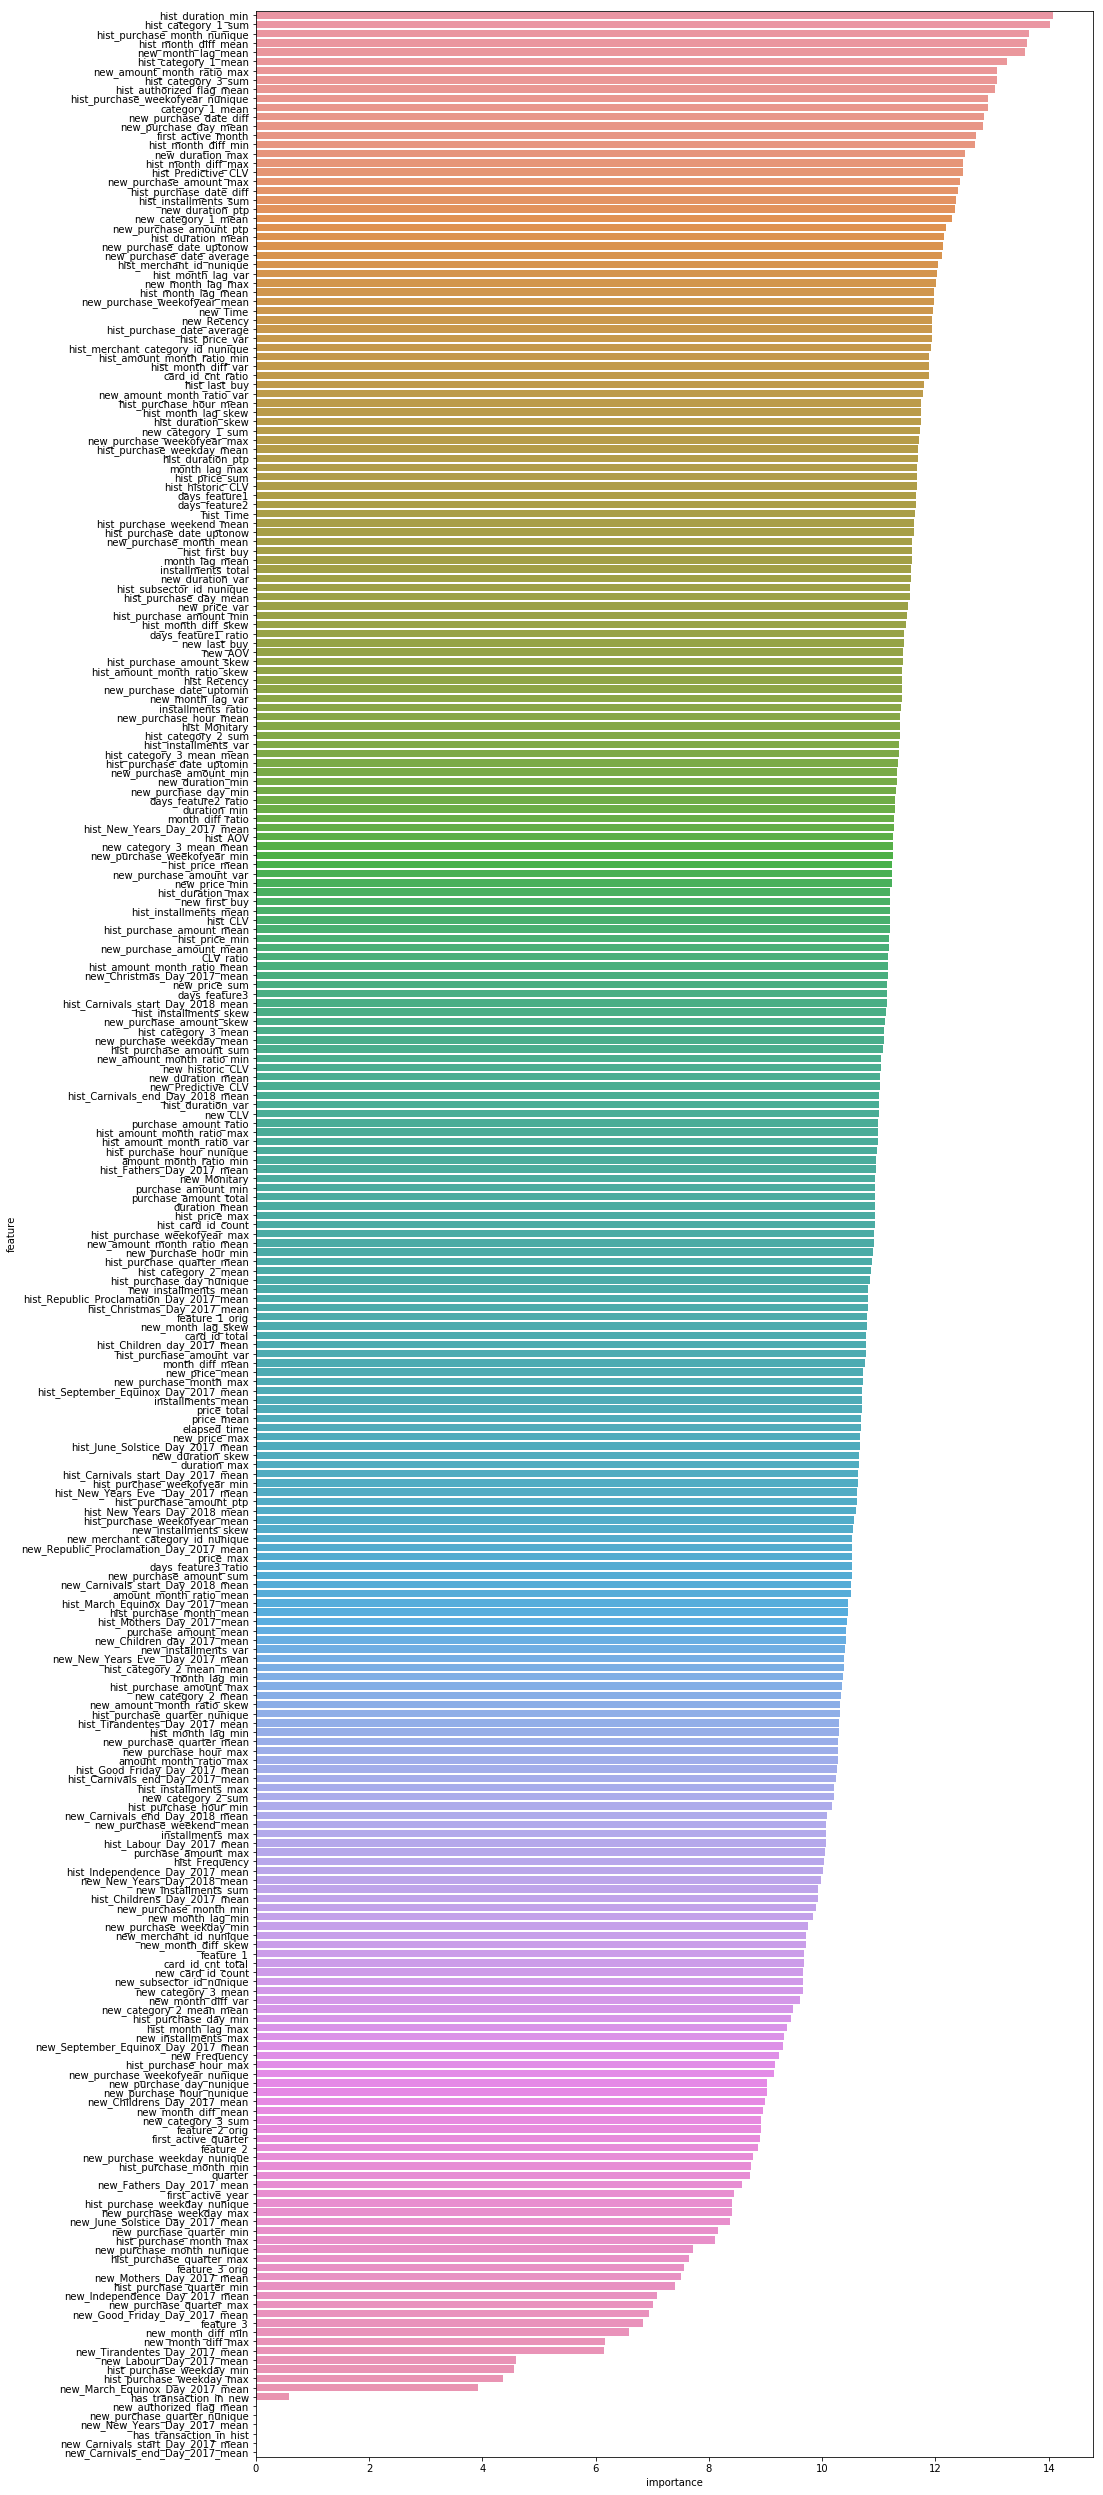

In [90]:
t1 = fold_importance_df[['feature', 'importance']][fold_importance_df['fold']==1]
t2 = fold_importance_df[['feature', 'importance']][fold_importance_df['fold']==2]
t3 = fold_importance_df[['feature', 'importance']][fold_importance_df['fold']==3]
t1 = t1.set_index('feature')
t2 = t2.set_index('feature')
t3 = t3.set_index('feature')

t0 = (t1['importance'] + t2['importance'] + t3['importance'])/3
t0 = t0.reset_index()
plt.figure(figsize=(15,45))
sns.barplot(x="importance",
            y="feature",
            data=t0.sort_values(by="importance", ascending=False))
      

Starting LightGBM. Train shape: (201917, 275), test shape: (123623, 275)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65486	test's rmse: 3.69758
[200]	train's rmse: 3.5726	test's rmse: 3.66008
[300]	train's rmse: 3.51894	test's rmse: 3.64632
[400]	train's rmse: 3.47942	test's rmse: 3.64022
[500]	train's rmse: 3.4479	test's rmse: 3.63703
[600]	train's rmse: 3.42276	test's rmse: 3.63553
[700]	train's rmse: 3.40159	test's rmse: 3.63436
[800]	train's rmse: 3.38111	test's rmse: 3.63397
[900]	train's rmse: 3.36169	test's rmse: 3.63365
[1000]	train's rmse: 3.34202	test's rmse: 3.63315
[1100]	train's rmse: 3.32339	test's rmse: 3.63292
[1200]	train's rmse: 3.30558	test's rmse: 3.63303
Early stopping, best iteration is:
[1045]	train's rmse: 3.33374	test's rmse: 3.63273
Fold  1 RMSE : 3.632734


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.64762	test's rmse: 3.71177
[200]	train's rmse: 3.56236	test's rmse: 3.68237
[300]	train's rmse: 3.50868	test's rmse: 3.67143
[400]	train's rmse: 3.47097	test's rmse: 3.6672
[500]	train's rmse: 3.44251	test's rmse: 3.66502
[600]	train's rmse: 3.41756	test's rmse: 3.66425
[700]	train's rmse: 3.39423	test's rmse: 3.66358
[800]	train's rmse: 3.37075	test's rmse: 3.66409
Early stopping, best iteration is:
[698]	train's rmse: 3.39488	test's rmse: 3.66352
Fold  2 RMSE : 3.663516


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65191	test's rmse: 3.70864
[200]	train's rmse: 3.56496	test's rmse: 3.6757
[300]	train's rmse: 3.51382	test's rmse: 3.66419
[400]	train's rmse: 3.47654	test's rmse: 3.65952
[500]	train's rmse: 3.44688	test's rmse: 3.65728
[600]	train's rmse: 3.42165	test's rmse: 3.65623
[700]	train's rmse: 3.39772	test's rmse: 3.65566
[800]	train's rmse: 3.37544	test's rmse: 3.65516
[900]	train's rmse: 3.35501	test's rmse: 3.65545
[1000]	train's rmse: 3.33507	test's rmse: 3.6558
Early stopping, best iteration is:
[818]	train's rmse: 3.37139	test's rmse: 3.65509
Fold  3 RMSE : 3.655086


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.64797	test's rmse: 3.70797
[200]	train's rmse: 3.56247	test's rmse: 3.6747
[300]	train's rmse: 3.5078	test's rmse: 3.66364
[400]	train's rmse: 3.47049	test's rmse: 3.65981
[500]	train's rmse: 3.44086	test's rmse: 3.65792
[600]	train's rmse: 3.41525	test's rmse: 3.65725
[700]	train's rmse: 3.39153	test's rmse: 3.65733
[800]	train's rmse: 3.36775	test's rmse: 3.65801
Early stopping, best iteration is:
[644]	train's rmse: 3.40478	test's rmse: 3.65701
Fold  4 RMSE : 3.657006
RMSE is 3.65210385716742


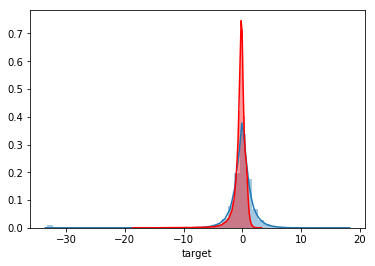

In [89]:
train_df = train_df.drop(['feature_sum','feature_mean','feature_max','feature_min','feature_var','feature_dot','feature_sumsq'], axis=1)
test_df = test_df.drop(['feature_sum','feature_mean','feature_max','feature_min','feature_var','feature_dot','feature_sumsq'], axis=1)
sub_preds_1, fold_importance_df = kfold_lightgbm(train_df, test_df, num_folds=4, stratified=True, debug=False)  
sns.distplot(train_df['target'])
sns.distplot(sub_preds_1, color='r')


Starting LightGBM. Train shape: (201917, 276), test shape: (123623, 276)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65649	test's rmse: 3.69835
[200]	train's rmse: 3.57331	test's rmse: 3.66006
[300]	train's rmse: 3.51988	test's rmse: 3.64637
[400]	train's rmse: 3.48124	test's rmse: 3.64027
[500]	train's rmse: 3.45009	test's rmse: 3.63651
[600]	train's rmse: 3.42607	test's rmse: 3.63455
[700]	train's rmse: 3.40453	test's rmse: 3.63316
[800]	train's rmse: 3.385	test's rmse: 3.63247
[900]	train's rmse: 3.36644	test's rmse: 3.63203
[1000]	train's rmse: 3.34726	test's rmse: 3.63153
[1100]	train's rmse: 3.32912	test's rmse: 3.63143
[1200]	train's rmse: 3.31047	test's rmse: 3.6316
Early stopping, best iteration is:
[1055]	train's rmse: 3.33732	test's rmse: 3.6312
Fold  1 RMSE : 3.631199


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.64837	test's rmse: 3.71274
[200]	train's rmse: 3.56229	test's rmse: 3.68362
[300]	train's rmse: 3.5083	test's rmse: 3.67338
[400]	train's rmse: 3.46945	test's rmse: 3.6696
[500]	train's rmse: 3.44215	test's rmse: 3.66784
[600]	train's rmse: 3.41717	test's rmse: 3.66684
[700]	train's rmse: 3.39452	test's rmse: 3.66658
[800]	train's rmse: 3.37205	test's rmse: 3.6672
[900]	train's rmse: 3.35095	test's rmse: 3.66756
Early stopping, best iteration is:
[712]	train's rmse: 3.39177	test's rmse: 3.66644
Fold  2 RMSE : 3.666443


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65094	test's rmse: 3.70923
[200]	train's rmse: 3.56384	test's rmse: 3.67554
[300]	train's rmse: 3.51189	test's rmse: 3.66403
[400]	train's rmse: 3.47565	test's rmse: 3.65864
[500]	train's rmse: 3.44706	test's rmse: 3.65637
[600]	train's rmse: 3.42256	test's rmse: 3.65484
[700]	train's rmse: 3.39911	test's rmse: 3.65383
[800]	train's rmse: 3.37658	test's rmse: 3.65336
[900]	train's rmse: 3.35596	test's rmse: 3.65331
[1000]	train's rmse: 3.33597	test's rmse: 3.65353
[1100]	train's rmse: 3.31915	test's rmse: 3.65363
Early stopping, best iteration is:
[947]	train's rmse: 3.34609	test's rmse: 3.65318
Fold  3 RMSE : 3.653182


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.64828	test's rmse: 3.7091
[200]	train's rmse: 3.56345	test's rmse: 3.67695
[300]	train's rmse: 3.50764	test's rmse: 3.66541
[400]	train's rmse: 3.47087	test's rmse: 3.66106
[500]	train's rmse: 3.44297	test's rmse: 3.65953
[600]	train's rmse: 3.41764	test's rmse: 3.65875
[700]	train's rmse: 3.39373	test's rmse: 3.65896
[800]	train's rmse: 3.3718	test's rmse: 3.65943
Early stopping, best iteration is:
[631]	train's rmse: 3.41029	test's rmse: 3.65865
Fold  4 RMSE : 3.658648
RMSE is 3.6523914584755177


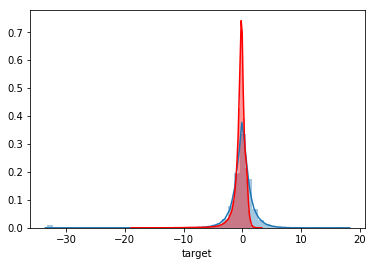

In [82]:
train_df = train_df.drop([*t0[t0['importance']==0]['feature']],axis=1)
test_df = test_df.drop([*t0[t0['importance']==0]['feature']],axis=1)

sub_preds_1, fold_importance_df = kfold_lightgbm(train_df, test_df, num_folds=4, stratified=True, debug=False)  
sns.distplot(train_df['target'])
sns.distplot(sub_preds_1, color='r')


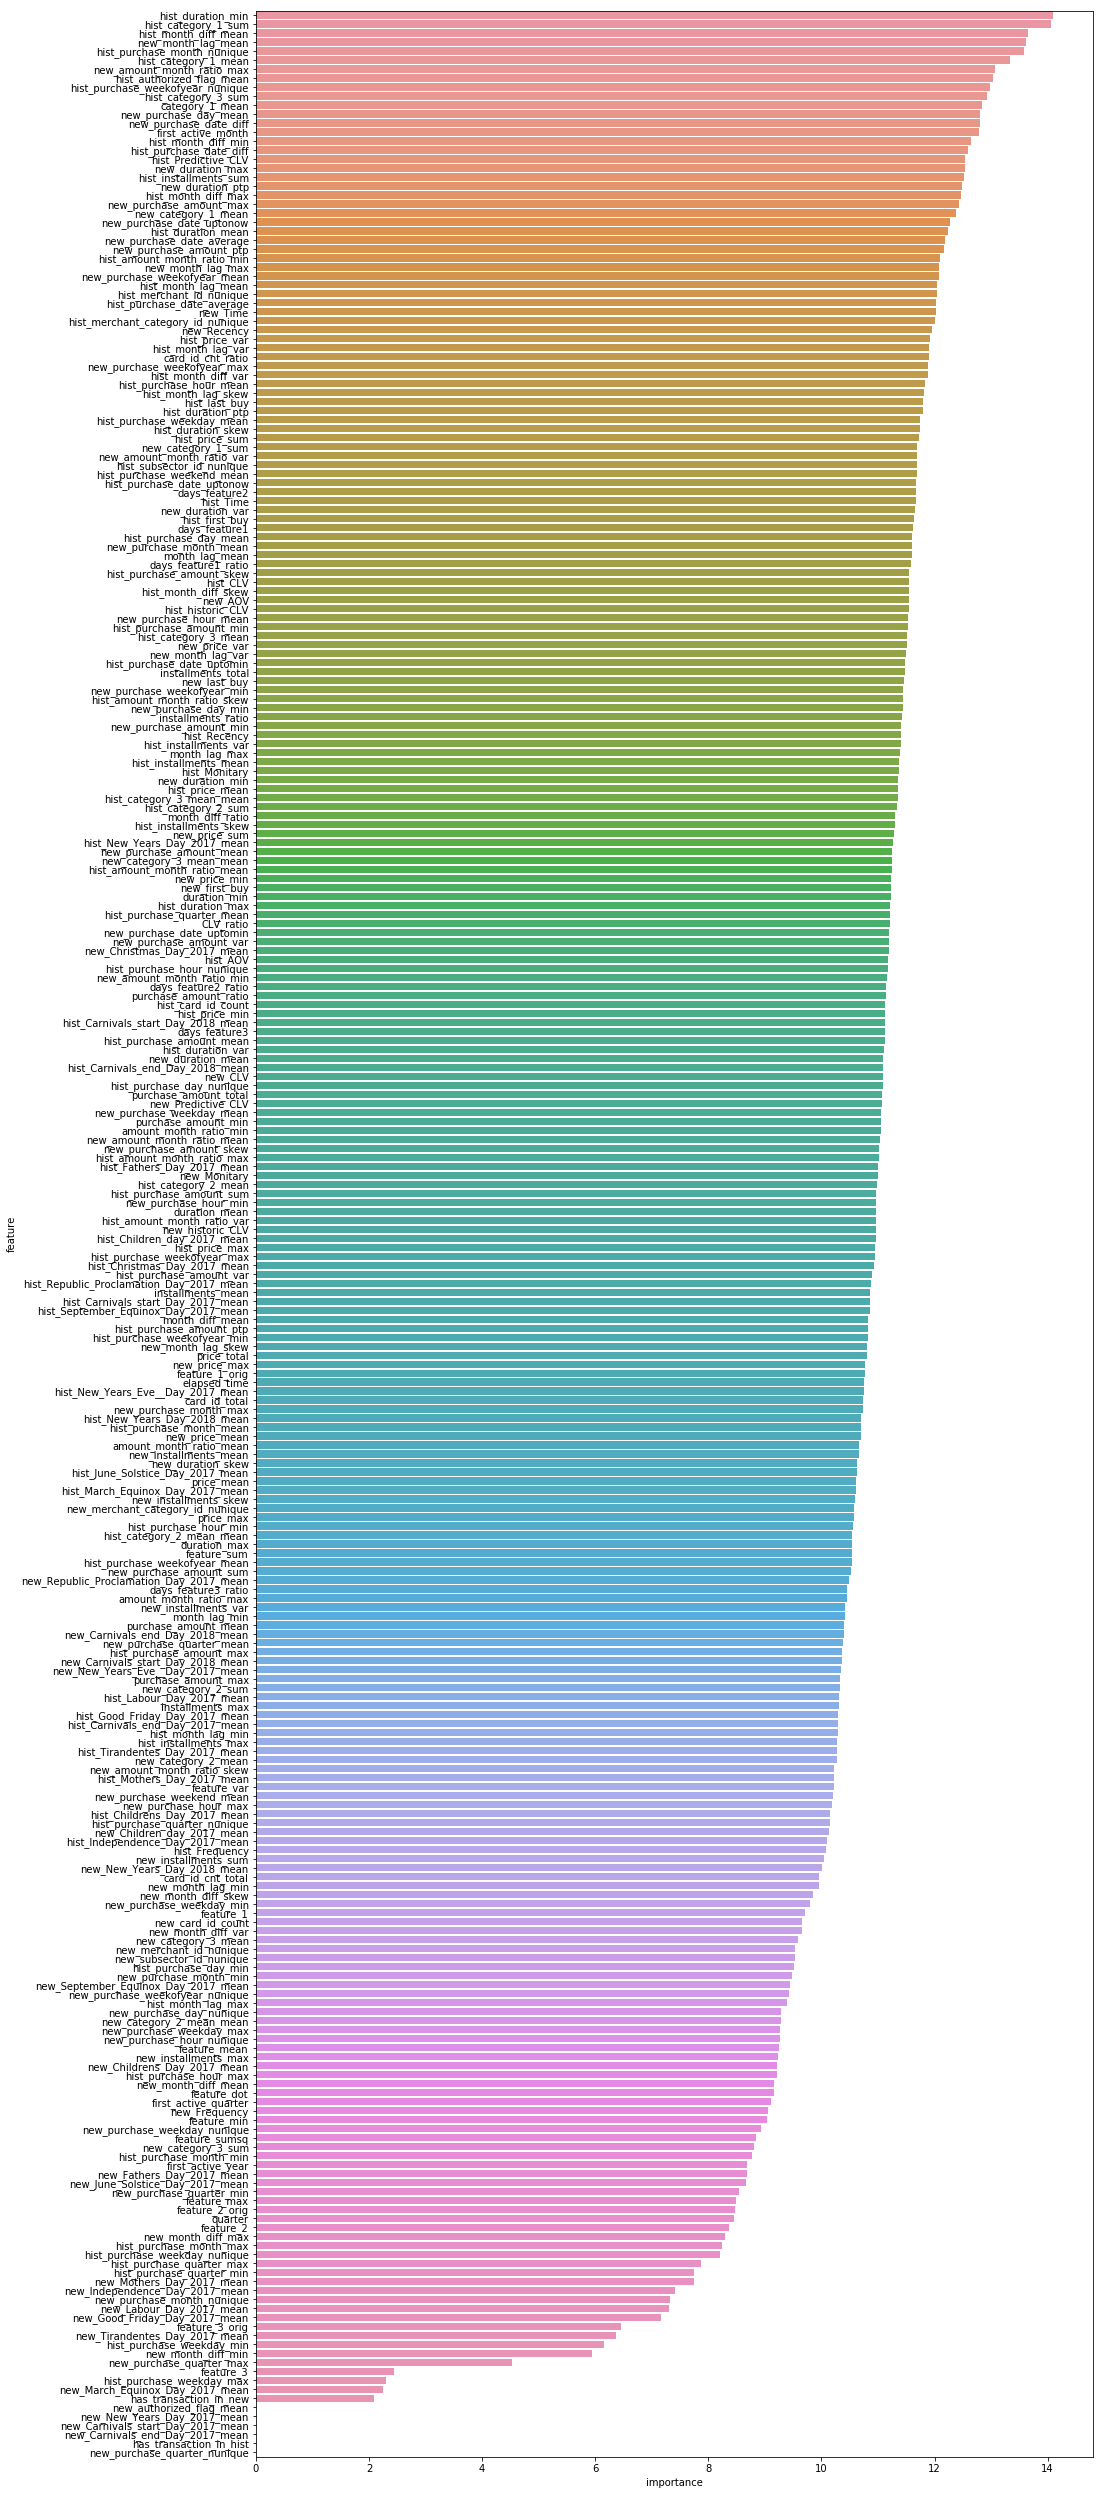

In [71]:
t1 = fold_importance_df[['feature', 'importance']][fold_importance_df['fold']==1]
t2 = fold_importance_df[['feature', 'importance']][fold_importance_df['fold']==2]
t3 = fold_importance_df[['feature', 'importance']][fold_importance_df['fold']==3]
t1 = t1.set_index('feature')
t2 = t2.set_index('feature')
t3 = t3.set_index('feature')

t0 = (t1['importance'] + t2['importance'] + t3['importance'])/3
t0 = t0.reset_index()
plt.figure(figsize=(15,45))
sns.barplot(x="importance",
            y="feature",
            data=t0.sort_values(by="importance", ascending=False))
       

Starting LightGBM. Train shape: (201917, 282), test shape: (123623, 282)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65567	test's rmse: 3.69747
[200]	train's rmse: 3.5724	test's rmse: 3.6602
[300]	train's rmse: 3.51871	test's rmse: 3.64625
[400]	train's rmse: 3.47921	test's rmse: 3.64035
[500]	train's rmse: 3.44964	test's rmse: 3.63701
[600]	train's rmse: 3.42446	test's rmse: 3.63482
[700]	train's rmse: 3.40275	test's rmse: 3.63366
[800]	train's rmse: 3.38229	test's rmse: 3.63307
[900]	train's rmse: 3.3619	test's rmse: 3.63324
[1000]	train's rmse: 3.34276	test's rmse: 3.63288
[1100]	train's rmse: 3.32379	test's rmse: 3.63246
[1200]	train's rmse: 3.30715	test's rmse: 3.6325
[1300]	train's rmse: 3.2903	test's rmse: 3.63285
Early stopping, best iteration is:
[1165]	train's rmse: 3.31328	test's rmse: 3.63229
Fold  1 RMSE : 3.632292


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.64854	test's rmse: 3.71191
[200]	train's rmse: 3.5624	test's rmse: 3.68202
[300]	train's rmse: 3.50849	test's rmse: 3.67148
[400]	train's rmse: 3.46938	test's rmse: 3.66778
[500]	train's rmse: 3.43938	test's rmse: 3.6658
[600]	train's rmse: 3.41422	test's rmse: 3.66493
[700]	train's rmse: 3.39118	test's rmse: 3.66462
[800]	train's rmse: 3.3692	test's rmse: 3.66456
[900]	train's rmse: 3.34823	test's rmse: 3.665
Early stopping, best iteration is:
[723]	train's rmse: 3.38589	test's rmse: 3.6644
Fold  2 RMSE : 3.664399


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65131	test's rmse: 3.7096
[200]	train's rmse: 3.5648	test's rmse: 3.67533
[300]	train's rmse: 3.513	test's rmse: 3.66368
[400]	train's rmse: 3.47579	test's rmse: 3.6586
[500]	train's rmse: 3.44739	test's rmse: 3.6562
[600]	train's rmse: 3.42209	test's rmse: 3.65493
[700]	train's rmse: 3.39941	test's rmse: 3.65386
[800]	train's rmse: 3.37776	test's rmse: 3.65366
[900]	train's rmse: 3.35634	test's rmse: 3.65361
[1000]	train's rmse: 3.33843	test's rmse: 3.65359
[1100]	train's rmse: 3.31977	test's rmse: 3.65382
[1200]	train's rmse: 3.30234	test's rmse: 3.65407
Early stopping, best iteration is:
[1009]	train's rmse: 3.33669	test's rmse: 3.65349
Fold  3 RMSE : 3.653490


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.64809	test's rmse: 3.70925
[200]	train's rmse: 3.56344	test's rmse: 3.6762
[300]	train's rmse: 3.50962	test's rmse: 3.66437
[400]	train's rmse: 3.47105	test's rmse: 3.66112
[500]	train's rmse: 3.44173	test's rmse: 3.65928
[600]	train's rmse: 3.41592	test's rmse: 3.65885
[700]	train's rmse: 3.39254	test's rmse: 3.65898
Early stopping, best iteration is:
[561]	train's rmse: 3.42581	test's rmse: 3.65871
Fold  4 RMSE : 3.658706
RMSE is 3.652241763416339


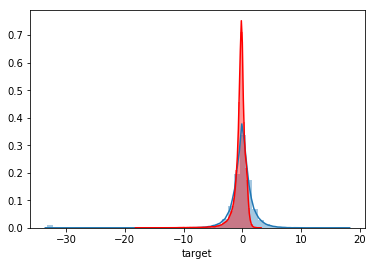

In [69]:
# added hist_add, new_add, feature_.._orig, has_transaction_in_hist, has_transaction_in_new
# LB = 3.693

sub_preds_1, fold_importance_df = kfold_lightgbm(train_df, test_df, num_folds=4, stratified=True, debug=False)  
sns.distplot(train_df['target'])
sns.distplot(sub_preds_1, color='r')

In [192]:
submission = pd.DataFrame()
submission['card_id'] = test_df.index
submission['target'] = sub_preds_1
submission.to_csv('submission1.csv', index=False)

In [413]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

Starting LightGBM. Train shape: (201917, 263), test shape: (123623, 263)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.6543	test's rmse: 3.81014
[200]	train's rmse: 3.57115	test's rmse: 3.76882
[300]	train's rmse: 3.51354	test's rmse: 3.75323
[400]	train's rmse: 3.47063	test's rmse: 3.74642
[500]	train's rmse: 3.43869	test's rmse: 3.74308
[600]	train's rmse: 3.41184	test's rmse: 3.74168
[700]	train's rmse: 3.38924	test's rmse: 3.7405
[800]	train's rmse: 3.37071	test's rmse: 3.73972
[900]	train's rmse: 3.35258	test's rmse: 3.73927
[1000]	train's rmse: 3.33542	test's rmse: 3.73881
[1100]	train's rmse: 3.31944	test's rmse: 3.73918
Early stopping, best iteration is:
[997]	train's rmse: 3.33613	test's rmse: 3.73881
Fold  1 RMSE : 3.738813


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.69997	test's rmse: 3.67009
[200]	train's rmse: 3.61537	test's rmse: 3.62777
[300]	train's rmse: 3.55836	test's rmse: 3.61104
[400]	train's rmse: 3.51745	test's rmse: 3.60281
[500]	train's rmse: 3.48539	test's rmse: 3.59867
[600]	train's rmse: 3.45711	test's rmse: 3.59624
[700]	train's rmse: 3.43387	test's rmse: 3.59492
[800]	train's rmse: 3.41516	test's rmse: 3.59415
[900]	train's rmse: 3.39685	test's rmse: 3.59373
[1000]	train's rmse: 3.38031	test's rmse: 3.59312
[1100]	train's rmse: 3.36606	test's rmse: 3.59314
[1200]	train's rmse: 3.35205	test's rmse: 3.59342
Early stopping, best iteration is:
[1049]	train's rmse: 3.37344	test's rmse: 3.59295
Fold  2 RMSE : 3.592951


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.67646	test's rmse: 3.73677
[200]	train's rmse: 3.59222	test's rmse: 3.69446
[300]	train's rmse: 3.53367	test's rmse: 3.67816
[400]	train's rmse: 3.48918	test's rmse: 3.66995
[500]	train's rmse: 3.45705	test's rmse: 3.66545
[600]	train's rmse: 3.43149	test's rmse: 3.66274
[700]	train's rmse: 3.41122	test's rmse: 3.66083
[800]	train's rmse: 3.39365	test's rmse: 3.65962
[900]	train's rmse: 3.37691	test's rmse: 3.65889
[1000]	train's rmse: 3.36154	test's rmse: 3.65826
[1100]	train's rmse: 3.34786	test's rmse: 3.65769
[1200]	train's rmse: 3.33425	test's rmse: 3.65743
[1300]	train's rmse: 3.32142	test's rmse: 3.65674
[1400]	train's rmse: 3.30785	test's rmse: 3.65638
[1500]	train's rmse: 3.29381	test's rmse: 3.65641
[1600]	train's rmse: 3.28068	test's rmse: 3.65626
[1700]	train's rmse: 3.2679	test's rmse: 3.6563
[1800]	train's rmse: 3.25555	test's rmse: 3.65627
Early stopping, best iteration is:
[1636]	train'

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.69137	test's rmse: 3.6913
[200]	train's rmse: 3.60571	test's rmse: 3.65133
[300]	train's rmse: 3.54764	test's rmse: 3.63669
[400]	train's rmse: 3.50363	test's rmse: 3.62988
[500]	train's rmse: 3.47014	test's rmse: 3.6268
[600]	train's rmse: 3.44167	test's rmse: 3.62533
[700]	train's rmse: 3.41726	test's rmse: 3.62487
[800]	train's rmse: 3.39627	test's rmse: 3.62496
[900]	train's rmse: 3.37636	test's rmse: 3.6241
[1000]	train's rmse: 3.35971	test's rmse: 3.62409
[1100]	train's rmse: 3.3451	test's rmse: 3.62376
[1200]	train's rmse: 3.33032	test's rmse: 3.62377
[1300]	train's rmse: 3.31744	test's rmse: 3.6239
Early stopping, best iteration is:
[1109]	train's rmse: 3.34386	test's rmse: 3.62369
Fold  4 RMSE : 3.623693
RMSE is 3.6533127164479553


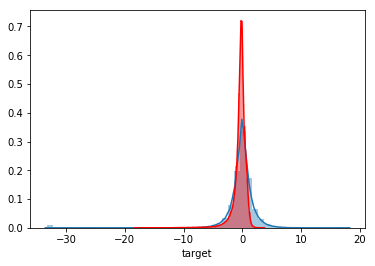

In [98]:
sub_preds_1 = kfold_lightgbm(train_df, test_df, num_folds=4, stratified=False, debug=False)  
sns.distplot(train_df['target'])
sns.distplot(sub_preds_1, color='r')

In [60]:
submission.to_csv('submission1.csv', index=False)

In [59]:
submission = pd.DataFrame()
submission['card_id'] = test_df.index
submission['target'] = sub_preds_1


Starting LightGBM. Train shape: (201917, 263), test shape: (123623, 263)
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65775	test's rmse: 3.69945
[200]	train's rmse: 3.57587	test's rmse: 3.66288
[300]	train's rmse: 3.52226	test's rmse: 3.6488
[400]	train's rmse: 3.48398	test's rmse: 3.64252
[500]	train's rmse: 3.45446	test's rmse: 3.63889
[600]	train's rmse: 3.42897	test's rmse: 3.63667
[700]	train's rmse: 3.40714	test's rmse: 3.63575
[800]	train's rmse: 3.38654	test's rmse: 3.63509
[900]	train's rmse: 3.36879	test's rmse: 3.63467
[1000]	train's rmse: 3.35126	test's rmse: 3.63461
[1100]	train's rmse: 3.33341	test's rmse: 3.63468
Early stopping, best iteration is:
[933]	train's rmse: 3.36309	test's rmse: 3.63443
Fold  1 RMSE : 3.634426
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.64913	test's rmse: 3.7132
[200]	train's rmse: 3.56469	test's rmse: 3.68261
[300]	train's rmse: 3.51067	test's rmse: 3.67236
[400]	t

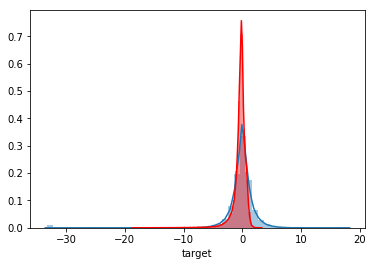

In [57]:
sub_preds_2 = kfold_lightgbm(train_df, test_df, num_folds=4, stratified=True, debug=False)  
sns.distplot(train_df['target'])
sns.distplot(sub_preds_2, color='r')



In [58]:
submission = pd.DataFrame()
submission['card_id'] = test_df.index
submission['target'] = sub_preds_2
submission.to_csv('submission2.csv', index=False)

In [ ]:
train_df['target'].min()

In [ ]:
np.sort(train_df['target'])

In [ ]:
np.sort(train_df['target'].unique())

In [ ]:
np.percentile(train_df['target'], [10,20,30,40,50,60,70,80,90,95,99])

In [ ]:
from skopt import BayesSearchCV

# include below until https://github.com/scikit-optimize/scikit-optimize/issues/718 is resolved
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')


In [ ]:
bayes_cv_tuner = BayesSearchCV(
    estimator = lgb.LGBMRegressor(
        n_jobs = 1,
        objective = 'regression',
        boosting = 'goss',
        eval_metric = 'rmse',
        seed = 1,
        bagging_seed = 1,
        drop_seed = 1
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 100),
        'min_data_in_leaf': (10,100),
        'max_depth': (0, 50),
        'top_rate': (0.01, 1.0, 'uniform'),
        'subsample': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'n_estimators': (50, 100),
        'feature_fraction': (0.1,1.0, 'uniform'),
        #'bagging_fraction': (0.1,1.0,'uniform'),
        #'bagging_freq': (1, 10),
        #'other_rate': (0, 1, 'uniform'),
        #'scale_pos_weight': (1e-6, 500, 'log-uniform')
    },    
    scoring = rmse_scorer,
    cv = KFold(
        n_splits=10,
        shuffle=True,
        random_state=42
    ),
    #n_jobs = 3,
    n_iter = 10,   
    verbose = 0,
    refit = True,
    random_state = 42
)


In [ ]:
# no bagging when boosting='goss'

In [ ]:
feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

#lgb_train = lgb.Dataset(train_df[feats], label=train_df['target'])

In [ ]:
bayes_cv_tuner.fit(train_df[feats], train_df['target'])

In [ ]:
df = pd.read_hdf('Elo_fe.h5', 'df_final')
# 'new_authorized_flag_mean' doesn't have variance

In [ ]:
train = df[df['target'].notnull()]
test = df[df['target'].isnull()]

In [ ]:
train['purchase_month']

In [63]:
df.head()

feature_1  feature_2  feature_3  first_active_month  \
card_id                                                                
C_ID_92a2005557   0.013145   0.008752   0.011428                 6.0   
C_ID_3d0044924f   0.010712   0.011385   0.010283                 1.0   
C_ID_d639edf6cd   0.010610   0.008752   0.010283                 8.0   
C_ID_186d6a6901   0.010712   0.014166   0.010283                 9.0   
C_ID_cdbd2c0db2   0.008058   0.014166   0.010283                11.0   

                 outliers    target  quarter  elapsed_time  days_feature1  \
card_id                                                                     
C_ID_92a2005557       0.0 -0.820283      2.0         612.0         3030.0   
C_ID_3d0044924f       0.0  0.392913      1.0         763.0         3028.0   
C_ID_d639edf6cd       0.0  0.688056      3.0         916.0         1820.0   
C_ID_186d6a6901       0.0  0.142495      3.0         520.0         2056.0   
C_ID_cdbd2c0db2       0.0 -0.159749      4.0         459.0          453.0   

                 days_feature2          ...           duration_min  \
card_id                                 ...                          
C_ID_92a2005557         1212.0          ...             -16.781250   
C_ID_3d0044924f          757.0          ...             -19.125000   
C_ID_d639edf6cd         1820.0          ...             -16.437500   
C_ID_186d6a6901         1542.0          ...             -16.921875   
C_ID_cdbd2c0db2         1359.0          ...             -17.656250   

                 duration_max  amount_month_ratio_mean  \
card_id                                                  
C_ID_92a2005557      5.539062                -0.110291   
C_ID_3d0044924f      1.179688                -0.110474   
C_ID_d639edf6cd     -9.304688                -0.124817   
C_ID_186d6a6901      2.562500                -0.119324   
C_ID_cdbd2c0db2     13.757812                -0.100708   

                 amount_month_ratio_min  amount_month_ratio_max    new_CLV  \
card_id                                                                      
C_ID_92a2005557               -0.133057                0.045837 -27.688210   
C_ID_3d0044924f               -0.123474                0.010223  -2.148362   
C_ID_d639edf6cd               -0.130127               -0.076904  -0.063654   
C_ID_186d6a6901               -0.134033                0.021240  -2.963068   
C_ID_cdbd2c0db2               -0.134766                0.113770 -64.240728   

                    hist_CLV  CLV_ratio  first_active_year  \
card_id                                                      
C_ID_92a2005557 -3914.434326   0.007073             2017.0   
C_ID_3d0044924f -6213.007324   0.000346             2017.0   
C_ID_d639edf6cd  -113.071831   0.000563             2016.0   
C_ID_186d6a6901  -348.892670   0.008493             2017.0   
C_ID_cdbd2c0db2  -904.062073   0.071058             2017.0   

                 first_active_quarter  
card_id                                
C_ID_92a2005557                   2.0  
C_ID_3d0044924f                   1.0  
C_ID_d639edf6cd                   3.0  
C_ID_186d6a6901                   3.0  
C_ID_cdbd2c0db2                   4.0  

[5 rows x 263 columns]

In [195]:
# try additional FE

In [279]:
## remove new_card_id_size
df = pd.read_hdf('Elo_fe.h5', 'df_final')
df['AOV_ratio'] = df['new_AOV'] / df['hist_AOV']
df['AOV_diff'] = df['new_AOV'] - df['hist_AOV']
df['Frequency_ratio'] = df['new_Frequency'] / df['hist_Frequency']
df['Monitary_ratio'] = df['new_Monitary'] / df['hist_Monitary']
df['Time_ratio'] = df['new_Time'] / df['hist_Time']
df['Recency_ratio'] = df['new_Recency'] / df['hist_Recency']
df['Recency_diff'] = df['new_Recency'] - df['hist_Recency']

# 1
df['category_1_sum_diff'] = df['new_category_1_sum'] - df['hist_category_1_sum']
df['month_lag_ratio'] = df['hist_month_lag_mean'] / df['new_month_lag_mean']


df.drop(['hist_card_id_size', 'new_card_id_size'], axis=1, inplace=True)
df.shape

(325540, 289)

In [264]:
'''
df.drop(['feature_sum','feature_mean','feature_max','feature_min','feature_var','feature_dot','feature_sumsq', 'has_transaction_in_hist', 'has_transaction_in_new', 
                     'new_authorized_flag_mean', 'new_Carnivals_start_Day_2017_mean', 'new_New_Years_Day_2017_mean', 'new_Carnivals_end_Day_2017_mean'],
       axis=1, inplace=True)
'''
df.shape

(325540, 288)

In [254]:
#df.to_hdf('Elo_result.h5', 'df_CV_3645_LB_3690')

In [281]:
## if num_folds =11 => CV 3.6451; LB 3.690, the best score
# 1 => CV 3.64578
'''
train_df = df[df['target'].notnull()]
test_df = df[df['target'].isnull()]

excluded_features = ['feature_sum','feature_mean','feature_max','feature_min','feature_var','feature_dot','feature_sumsq', 'has_transaction_in_hist', 'has_transaction_in_new', 
                     'new_authorized_flag_mean', 'new_Carnivals_start_Day_2017_mean', 'new_New_Years_Day_2017_mean', 'new_Carnivals_end_Day_2017_mean']
train_df = train_df.drop(excluded_features, axis=1)
test_df = test_df.drop(excluded_features, axis=1)

'''

for df in [train_df, test_df]:
    for col in df.columns:
        if col in ['target', 'outliers']:
            pass
        elif (df[col].isna().sum() > 0):
            if (df[col].dtypes == 'float'):
                df[col] = df[col].fillna(0.0)
            elif (df[col].dtypes == 'int'):
                df[col] = df[col].fillna(0)
            else:
                pass

sub_preds_1, _ = kfold_lightgbm(train_df, test_df, num_folds=11, stratified=True, debug=False)  


Starting LightGBM. Train shape: (201917, 276), test shape: (123623, 276)


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65575	test's rmse: 3.69092
[200]	train's rmse: 3.57644	test's rmse: 3.65025
[300]	train's rmse: 3.52972	test's rmse: 3.63285
[400]	train's rmse: 3.49446	test's rmse: 3.62425
[500]	train's rmse: 3.46857	test's rmse: 3.62004
[600]	train's rmse: 3.44603	test's rmse: 3.618
[700]	train's rmse: 3.42469	test's rmse: 3.61664
[800]	train's rmse: 3.4028	test's rmse: 3.61576
[900]	train's rmse: 3.38496	test's rmse: 3.61549
[1000]	train's rmse: 3.36786	test's rmse: 3.61513
[1100]	train's rmse: 3.35146	test's rmse: 3.61484
[1200]	train's rmse: 3.33543	test's rmse: 3.61382
[1300]	train's rmse: 3.31892	test's rmse: 3.61374
[1400]	train's rmse: 3.30176	test's rmse: 3.61384
Early stopping, best iteration is:
[1255]	train's rmse: 3.32646	test's rmse: 3.61362
Fold  1 RMSE : 3.613616


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.6548	test's rmse: 3.6958
[200]	train's rmse: 3.57443	test's rmse: 3.66021
[300]	train's rmse: 3.52752	test's rmse: 3.64652
[400]	train's rmse: 3.49357	test's rmse: 3.64144
[500]	train's rmse: 3.46781	test's rmse: 3.63848
[600]	train's rmse: 3.44465	test's rmse: 3.63731
[700]	train's rmse: 3.42352	test's rmse: 3.63634
[800]	train's rmse: 3.40457	test's rmse: 3.63612
[900]	train's rmse: 3.38545	test's rmse: 3.63608
[1000]	train's rmse: 3.36785	test's rmse: 3.63557
[1100]	train's rmse: 3.3529	test's rmse: 3.63465
[1200]	train's rmse: 3.33787	test's rmse: 3.63403
[1300]	train's rmse: 3.32241	test's rmse: 3.63363
[1400]	train's rmse: 3.3076	test's rmse: 3.63304
[1500]	train's rmse: 3.29338	test's rmse: 3.63285
[1600]	train's rmse: 3.27889	test's rmse: 3.63307
[1700]	train's rmse: 3.26475	test's rmse: 3.63351
Early stopping, best iteration is:
[1550]	train's rmse: 3.28567	test's rmse: 3.63258
Fold  2 RMSE : 

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65452	test's rmse: 3.70368
[200]	train's rmse: 3.57519	test's rmse: 3.66676
[300]	train's rmse: 3.52878	test's rmse: 3.65503
[400]	train's rmse: 3.49402	test's rmse: 3.65028
[500]	train's rmse: 3.46735	test's rmse: 3.64796
[600]	train's rmse: 3.44436	test's rmse: 3.64659
[700]	train's rmse: 3.42418	test's rmse: 3.64533
[800]	train's rmse: 3.40395	test's rmse: 3.64493
[900]	train's rmse: 3.38712	test's rmse: 3.64422
[1000]	train's rmse: 3.37188	test's rmse: 3.64358
[1100]	train's rmse: 3.35605	test's rmse: 3.64372
[1200]	train's rmse: 3.34129	test's rmse: 3.64385
[1300]	train's rmse: 3.32564	test's rmse: 3.64424
Early stopping, best iteration is:
[1155]	train's rmse: 3.34749	test's rmse: 3.64347
Fold  3 RMSE : 3.643466


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65308	test's rmse: 3.71249
[200]	train's rmse: 3.57274	test's rmse: 3.68173
[300]	train's rmse: 3.52434	test's rmse: 3.67276
[400]	train's rmse: 3.49059	test's rmse: 3.66929
[500]	train's rmse: 3.46237	test's rmse: 3.66801
[600]	train's rmse: 3.43935	test's rmse: 3.66656
[700]	train's rmse: 3.41815	test's rmse: 3.66663
[800]	train's rmse: 3.39761	test's rmse: 3.66713
Early stopping, best iteration is:
[635]	train's rmse: 3.43191	test's rmse: 3.66647
Fold  4 RMSE : 3.666471


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65548	test's rmse: 3.70988
[200]	train's rmse: 3.57552	test's rmse: 3.67443
[300]	train's rmse: 3.52786	test's rmse: 3.66234
[400]	train's rmse: 3.49372	test's rmse: 3.65723
[500]	train's rmse: 3.46768	test's rmse: 3.65441
[600]	train's rmse: 3.44447	test's rmse: 3.65221
[700]	train's rmse: 3.42286	test's rmse: 3.65075
[800]	train's rmse: 3.40459	test's rmse: 3.65026
[900]	train's rmse: 3.38689	test's rmse: 3.64992
[1000]	train's rmse: 3.36949	test's rmse: 3.64987
[1100]	train's rmse: 3.35184	test's rmse: 3.65009
Early stopping, best iteration is:
[927]	train's rmse: 3.38206	test's rmse: 3.64948
Fold  5 RMSE : 3.649477


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65349	test's rmse: 3.70295
[200]	train's rmse: 3.57404	test's rmse: 3.66676
[300]	train's rmse: 3.52777	test's rmse: 3.65279
[400]	train's rmse: 3.49421	test's rmse: 3.64671
[500]	train's rmse: 3.4681	test's rmse: 3.64449
[600]	train's rmse: 3.44558	test's rmse: 3.64157
[700]	train's rmse: 3.42387	test's rmse: 3.63968
[800]	train's rmse: 3.40612	test's rmse: 3.63866
[900]	train's rmse: 3.38794	test's rmse: 3.63798
[1000]	train's rmse: 3.37075	test's rmse: 3.63812
[1100]	train's rmse: 3.35358	test's rmse: 3.63747
[1200]	train's rmse: 3.33748	test's rmse: 3.637
[1300]	train's rmse: 3.32304	test's rmse: 3.63713
[1400]	train's rmse: 3.30723	test's rmse: 3.63738
Early stopping, best iteration is:
[1271]	train's rmse: 3.32746	test's rmse: 3.63684
Fold  6 RMSE : 3.636842


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65835	test's rmse: 3.68431
[200]	train's rmse: 3.57841	test's rmse: 3.64027
[300]	train's rmse: 3.53256	test's rmse: 3.62542
[400]	train's rmse: 3.49842	test's rmse: 3.61839
[500]	train's rmse: 3.47066	test's rmse: 3.61403
[600]	train's rmse: 3.44889	test's rmse: 3.61196
[700]	train's rmse: 3.42878	test's rmse: 3.61114
[800]	train's rmse: 3.40921	test's rmse: 3.61019
[900]	train's rmse: 3.39072	test's rmse: 3.60942
[1000]	train's rmse: 3.37378	test's rmse: 3.60867
[1100]	train's rmse: 3.35704	test's rmse: 3.6085
[1200]	train's rmse: 3.34043	test's rmse: 3.60896
[1300]	train's rmse: 3.32457	test's rmse: 3.60932
Early stopping, best iteration is:
[1163]	train's rmse: 3.34691	test's rmse: 3.60834
Fold  7 RMSE : 3.608340


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.64918	test's rmse: 3.73141
[200]	train's rmse: 3.56804	test's rmse: 3.7081
[300]	train's rmse: 3.52017	test's rmse: 3.70068
[400]	train's rmse: 3.48389	test's rmse: 3.69773
[500]	train's rmse: 3.45469	test's rmse: 3.69671
[600]	train's rmse: 3.4315	test's rmse: 3.69632
[700]	train's rmse: 3.41005	test's rmse: 3.69584
[800]	train's rmse: 3.39033	test's rmse: 3.69583
[900]	train's rmse: 3.37207	test's rmse: 3.69588
[1000]	train's rmse: 3.35649	test's rmse: 3.69573
[1100]	train's rmse: 3.34019	test's rmse: 3.69554
[1200]	train's rmse: 3.32562	test's rmse: 3.69588
[1300]	train's rmse: 3.31033	test's rmse: 3.69668
Early stopping, best iteration is:
[1115]	train's rmse: 3.3379	test's rmse: 3.6955
Fold  8 RMSE : 3.695497


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65369	test's rmse: 3.70366
[200]	train's rmse: 3.57367	test's rmse: 3.67157
[300]	train's rmse: 3.5258	test's rmse: 3.66005
[400]	train's rmse: 3.49054	test's rmse: 3.65549
[500]	train's rmse: 3.46311	test's rmse: 3.65271
[600]	train's rmse: 3.4412	test's rmse: 3.65073
[700]	train's rmse: 3.41979	test's rmse: 3.65002
[800]	train's rmse: 3.4005	test's rmse: 3.65046
[900]	train's rmse: 3.38347	test's rmse: 3.6505
Early stopping, best iteration is:
[738]	train's rmse: 3.41224	test's rmse: 3.64995
Fold  9 RMSE : 3.649945


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65575	test's rmse: 3.67908
[200]	train's rmse: 3.57674	test's rmse: 3.64024
[300]	train's rmse: 3.52854	test's rmse: 3.62659
[400]	train's rmse: 3.4941	test's rmse: 3.62259
[500]	train's rmse: 3.46615	test's rmse: 3.6201
[600]	train's rmse: 3.44346	test's rmse: 3.61915
[700]	train's rmse: 3.42313	test's rmse: 3.61903
[800]	train's rmse: 3.40412	test's rmse: 3.61843
[900]	train's rmse: 3.38567	test's rmse: 3.61834
[1000]	train's rmse: 3.36752	test's rmse: 3.61875
Early stopping, best iteration is:
[847]	train's rmse: 3.39551	test's rmse: 3.61779
Fold 10 RMSE : 3.617788


/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.65039	test's rmse: 3.72528
[200]	train's rmse: 3.56913	test's rmse: 3.70042
[300]	train's rmse: 3.52103	test's rmse: 3.69321
[400]	train's rmse: 3.48647	test's rmse: 3.69086
[500]	train's rmse: 3.45775	test's rmse: 3.68994
[600]	train's rmse: 3.43485	test's rmse: 3.68921
[700]	train's rmse: 3.41276	test's rmse: 3.68908
[800]	train's rmse: 3.39353	test's rmse: 3.68882
[900]	train's rmse: 3.37517	test's rmse: 3.6888
[1000]	train's rmse: 3.35762	test's rmse: 3.68875
[1100]	train's rmse: 3.34006	test's rmse: 3.68896
[1200]	train's rmse: 3.32267	test's rmse: 3.68934
Early stopping, best iteration is:
[1021]	train's rmse: 3.35431	test's rmse: 3.68844
Fold 11 RMSE : 3.688436
RMSE is 3.6457805011474496


In [247]:
submission = pd.DataFrame()
submission['card_id'] = test_df.index
submission['target'] = sub_preds_1
submission.to_csv('submission1.csv', index=False)

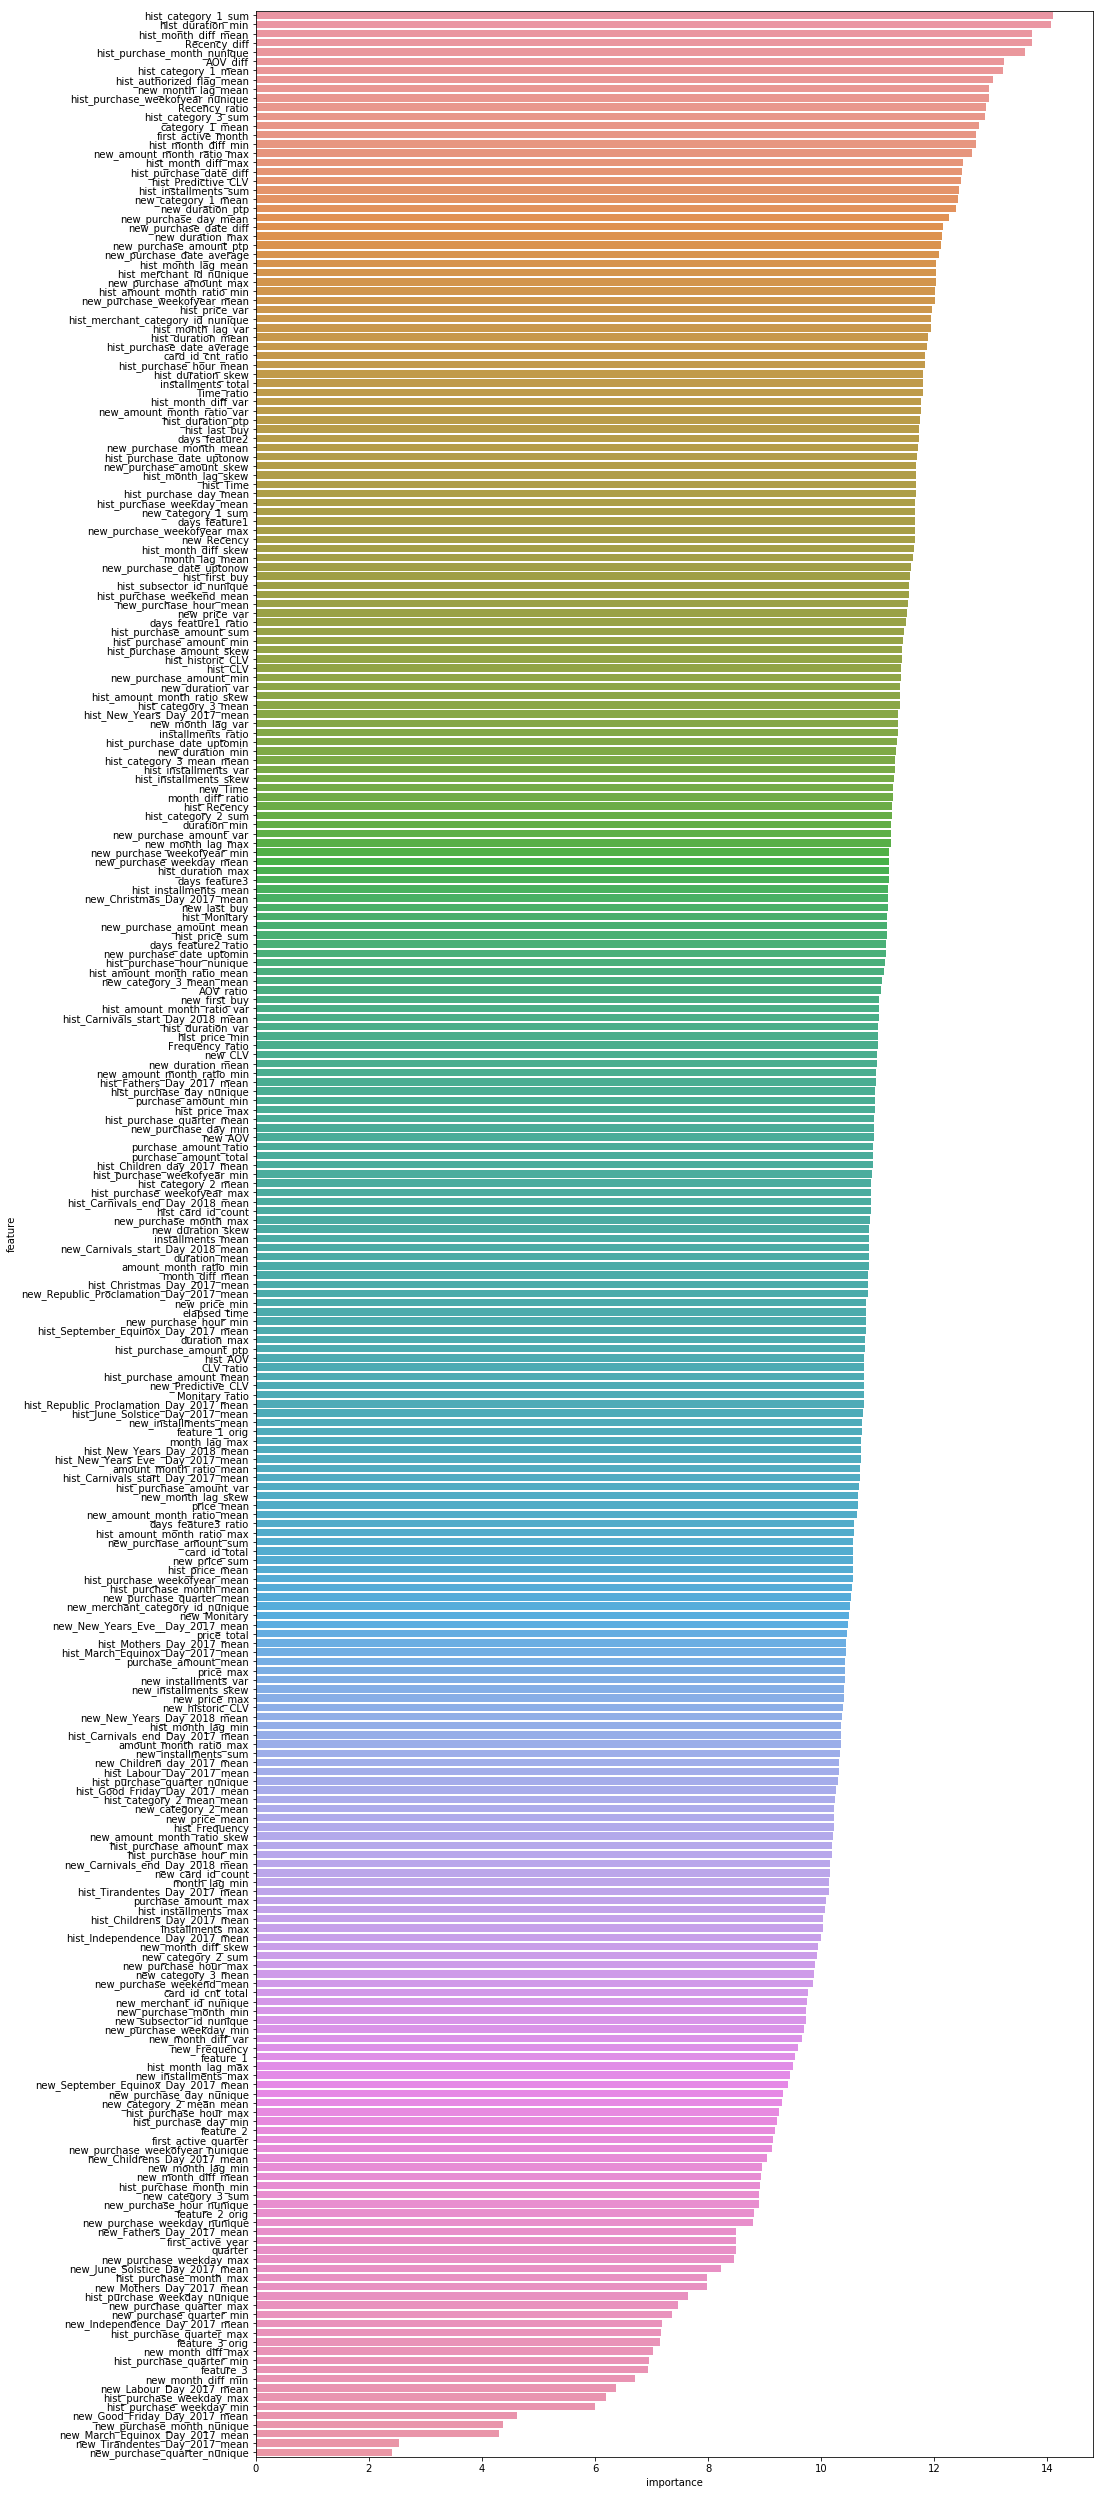

In [243]:
t1 = _[['feature', 'importance']][_['fold']==1]
t2 = _[['feature', 'importance']][_['fold']==2]
t3 = _[['feature', 'importance']][_['fold']==3]
t1 = t1.set_index('feature')
t2 = t2.set_index('feature')
t3 = t3.set_index('feature')

t00 = (t1['importance'] + t2['importance'] + t3['importance'])/3
t00 = t00.reset_index()
plt.figure(figsize=(15,45))
sns.barplot(x="importance",
            y="feature",
            data=t00.sort_values(by="importance", ascending=False))
      

In [296]:
df = pd.read_hdf('Elo_result.h5', 'df_CV_3645_LB_3690')
df.shape

(325540, 274)

In [283]:
FEATS_EXCLUDED

['target',
 'card_id',
 'outliers',
 'hist_purchase_date_max',
 'hist_purchase_date_min',
 'hist_card_id_size',
 'new_purchase_date_max',
 'new_purchase_date_min',
 'new_card_id_size',
 'OOF_PRED',
 'month_0',
 'hist_purchase_date_ptp',
 'new_purchase_date_ptp']

In [284]:
def LGB_CV(learning_rate,
          subsample,
          colsample_bytree,
          max_depth,
          num_leaves,
          min_data_in_leaf,
          feature_fraction,
          bagging_freq,
          bagging_fraction,
          reg_alpha,
          reg_lambda,
          min_child_weight,
          min_split_gain,
          top_rate,
          stratified=True,
          num_folds=10
        ):
    categorical_features = ['feature_1_orig', 'feature_2_orig', 'feature_3_orig','first_active_year', 'first_active_month', 'first_active_year', 'first_active_quarter']
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=326)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                categorical_feature=categorical_features)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               categorical_feature=categorical_features)
        params ={
                'num_leaves': int(num_leaves),
                'min_data_in_leaf': int(min_data_in_leaf), 
                'objective':'regression',
                'max_depth': int(max_depth),
                "boosting": "goss",
                "feature_fraction": feature_fraction,

                "metric": 'rmse',
                "reg_alpha": reg_alpha,
                "reg_lambda": reg_lambda,
                "verbosity": -1,
                "n_jobs": -1,
                'learning_rate': learning_rate,
                "subsample": subsample,
                "colsample_bytree": colsample_bytree,
                "min_child_weight": min_child_weight,
                "min_split_gain": min_split_gain,
                "top_rate": top_rate,
                "other_rate": 1-top_rate,
                'seed':int(2**n_fold),

                'drop_seed':int(2**n_fold),
                'feature_fraction_seed': int(2**n_fold),
                }

        reg = lgb.train(params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_test],
                        valid_names=['train', 'test'],
                        num_boost_round=10000,
                        early_stopping_rounds= 200,
                        verbose_eval=500)

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)

        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    
    return -mean_squared_error(oof_preds, train_df['target'])




In [285]:
LGB_BO = BayesianOptimization(LGB_CV, {
    'learning_rate': (0.001,0.01),
    'subsample': (0.7,1.0),
    'colsample_bytree': (0.4,1.0),
    'max_depth': (5, 12),
    'num_leaves': (63, 128),
    'min_data_in_leaf': (10, 20),
    'feature_fraction': (0.3, 0.9),
    'bagging_freq': (1,10),
    'bagging_fraction': (0.7, 1.0),
    'reg_alpha': (0,30),
    'reg_lambda': (5, 30),
    "min_child_weight": (10,150),
    "min_split_gain": (10,100),
    "top_rate": (0.0,1.0),
    })

In [ ]:
%%time
## switch to goss, try with shape[1]==220
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=150, acq='ei', xi=0.0)
    

In [309]:
def objective(trial, num_folds=4, stratified=True):
    categorical_features = ['feature_1_orig', 'feature_2_orig', 'feature_3_orig','first_active_year', 'first_active_month', 'first_active_year', 'first_active_quarter']
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=326)
        
    oof_preds = np.zeros(train_df.shape[0])
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                categorical_feature=categorical_features)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               categorical_feature=categorical_features)
        param = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'n_jobs': -1, 
                 'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
                 'seed':int(2**n_fold), 'drop_seed': int(2**n_fold), 'feature_fraction_seed': int(2**n_fold),
                 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.01),
                 'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
                 'num_leaves': trial.suggest_int('num_leaves', 60, 200),
                 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 40),
                 'max_depth': trial.suggest_int('max_depth', 5,15),
                 'reg_alpha': trial.suggest_uniform('reg_alpha', 1, 30),
                 'reg_lambda': trial.suggest_uniform('reg_lambda', 5,50),
                 'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
                 'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
                 'min_child_weight': trial.suggest_int('min_child_weight', 10, 150),
                 'min_split_gain': trial.suggest_int('min_split_gain', 10, 100),
                }
        if param['boosting_type'] == 'dart':
            param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-8, 1.0)
            param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
        elif param['boosting_type'] == 'goss':
            param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
            param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])
        else:
            param['bagging_freq'] = trial.suggest_int('bagging_freq', 0, 10)
            param['bagging_fraction'] = trial.suggest_uniform('bagging_fraction', 0.0, 1.0)
            param['bagging_seed'] = 11
            param['bagging_seed'] = int(2**n_fold)
    
        clf = lgb.train(param, lgb_train, 10000, valid_sets=[lgb_train, lgb_test],
                        verbose_eval=500, early_stopping_rounds=200)
            
        oof_preds[valid_idx] = clf.predict(train_df.iloc[valid_idx][feats], num_iteration=clf.best_iteration)
        
        del clf, train_x, train_y, valid_x, valid_y, train_idx, valid_idx
        gc.collect()
    
    return rmse(oof_preds, train_df['target'])


In [405]:
df = pd.read_hdf('Elo_result.h5', 'df_CV_3645_LB_3690')
train_df = df[df['target'].notnull()]
test_df = df[df['target'].isnull()]

In [311]:
# optuna seems to optimize the minimum score(loss)
### Shoot, I forgot to fillna(0)
### cv=4, the best score is 3.64718, but if I set cv=11, the score should be even lower
## dart performs worst, goss mediocre, gbdt best
## reducing learning_rate might further decrease rmse
study = optuna.create_study()
study.optimize(objective, n_trials=75)
print('study.best_params: \t')
print(study.best_params)
print('study.best_value: \t')
print(study.best_value)
print('study.best_trial.user_attrs: \t')
print(study.best_trial.user_attrs)

optuna_lgb = study.trials_dataframe()
optuna_lgb.to_csv("optuna_lgb.csv")

Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65203	valid_1's rmse: 3.67699
[1000]	training's rmse: 3.5936	valid_1's rmse: 3.6481
[1500]	training's rmse: 3.55779	valid_1's rmse: 3.63958
[2000]	training's rmse: 3.52935	valid_1's rmse: 3.63646
[2500]	training's rmse: 3.50444	valid_1's rmse: 3.63465
[3000]	training's rmse: 3.4815	valid_1's rmse: 3.63379
[3500]	training's rmse: 3.45952	valid_1's rmse: 3.63331
Early stopping, best iteration is:
[3389]	training's rmse: 3.46401	valid_1's rmse: 3.63314
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64257	valid_1's rmse: 3.6925
[1000]	training's rmse: 3.58367	valid_1's rmse: 3.67003
[1500]	training's rmse: 3.54758	valid_1's rmse: 3.66499
[2000]	training's rmse: 3.51843	valid_1's rmse: 3.66387
Early stopping, best iteration is:
[2113]	training's rmse: 3.51235	valid_1's rmse: 3.66383
Training until validation scores don't improve for 200 rounds.
[500]	training's rm

[I 2019-02-05 02:56:30,139] Finished a trial resulted in value: 3.652156382857312. Current best value is 3.652156382857312 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.00313959759570513, 'feature_fraction': 0.4655105658256209, 'num_leaves': 173, 'min_data_in_leaf': 15, 'max_depth': 14, 'reg_alpha': 17.468027165825884, 'reg_lambda': 32.517254340580486, 'subsample': 0.7907036560098842, 'colsample_bytree': 0.7575903248442051, 'min_child_weight': 136, 'min_split_gain': 34, 'bagging_freq': 3, 'bagging_fraction': 0.288733435530784}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.55006	valid_1's rmse: 3.66004
[1000]	training's rmse: 3.48155	valid_1's rmse: 3.64752
[1500]	training's rmse: 3.45008	valid_1's rmse: 3.64472
Early stopping, best iteration is:
[1482]	training's rmse: 3.44906	valid_1's rmse: 3.64336
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.54025	valid_1's rmse: 3.68281
[1000]	training's rmse: 3.47274	valid_1's rmse: 3.67423
[1500]	training's rmse: 3.43633	valid_1's rmse: 3.67187
Early stopping, best iteration is:
[1424]	training's rmse: 3.4375	valid_1's rmse: 3.67063
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.54001	valid_1's rmse: 3.67782
[1000]	training's rmse: 3.47002	valid_1's rmse: 3.66734
[1500]	training's rmse: 3.43924	valid_1's rmse: 3.66332
Early stopping, best iteration is:
[1400]	training's rmse: 3.43998	valid_1's rmse: 3.66113
Training until validation scores don't

[I 2019-02-05 03:01:55,283] Finished a trial resulted in value: 3.664279909437385. Current best value is 3.652156382857312 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.00313959759570513, 'feature_fraction': 0.4655105658256209, 'num_leaves': 173, 'min_data_in_leaf': 15, 'max_depth': 14, 'reg_alpha': 17.468027165825884, 'reg_lambda': 32.517254340580486, 'subsample': 0.7907036560098842, 'colsample_bytree': 0.7575903248442051, 'min_child_weight': 136, 'min_split_gain': 34, 'bagging_freq': 3, 'bagging_fraction': 0.288733435530784}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63539	valid_1's rmse: 3.68783
[1000]	training's rmse: 3.54235	valid_1's rmse: 3.65394
[1500]	training's rmse: 3.48202	valid_1's rmse: 3.64151
[2000]	training's rmse: 3.44838	valid_1's rmse: 3.63642
[2500]	training's rmse: 3.43543	valid_1's rmse: 3.6347
[3000]	training's rmse: 3.43141	valid_1's rmse: 3.63416
[3500]	training's rmse: 3.43071	valid_1's rmse: 3.63393
[4000]	training's rmse: 3.43054	valid_1's rmse: 3.63376
[4500]	training's rmse: 3.43046	valid_1's rmse: 3.6337
Early stopping, best iteration is:
[4331]	training's rmse: 3.43046	valid_1's rmse: 3.6337
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62722	valid_1's rmse: 3.70281
[1000]	training's rmse: 3.531	valid_1's rmse: 3.67453
[1500]	training's rmse: 3.4696	valid_1's rmse: 3.6665
[2000]	training's rmse: 3.43537	valid_1's rmse: 3.66365
[2500]	training's rmse: 3.42225	valid_1's rmse: 3.66274
[3000]	t

[I 2019-02-05 03:04:53,011] Finished a trial resulted in value: 3.651593275008705. Current best value is 3.651593275008705 with parameters: {'boosting': 'goss', 'learning_rate': 0.00271630129276573, 'feature_fraction': 0.1919723762167051, 'num_leaves': 94, 'min_data_in_leaf': 29, 'max_depth': 15, 'reg_alpha': 21.788409649390328, 'reg_lambda': 40.51012158888675, 'subsample': 0.7570749084628134, 'colsample_bytree': 0.7216673296328949, 'min_child_weight': 134, 'min_split_gain': 44, 'top_rate': 0.7473207849623962, 'other_rate': 0.17185884514744867}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65578	valid_1's rmse: 3.68209
[1000]	training's rmse: 3.61156	valid_1's rmse: 3.66143
[1500]	training's rmse: 3.59	valid_1's rmse: 3.65458
[2000]	training's rmse: 3.57573	valid_1's rmse: 3.65019
[2500]	training's rmse: 3.56743	valid_1's rmse: 3.64895
Early stopping, best iteration is:
[2552]	training's rmse: 3.56605	valid_1's rmse: 3.64851
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6492	valid_1's rmse: 3.70133
[1000]	training's rmse: 3.60134	valid_1's rmse: 3.68157
[1500]	training's rmse: 3.57698	valid_1's rmse: 3.67547
[2000]	training's rmse: 3.56326	valid_1's rmse: 3.67253
[2500]	training's rmse: 3.55429	valid_1's rmse: 3.67197
Early stopping, best iteration is:
[2406]	training's rmse: 3.55491	valid_1's rmse: 3.67185
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64969	valid_1's rmse: 3.69705
[1000]	training's rm

[I 2019-02-05 03:09:59,137] Finished a trial resulted in value: 3.666022362007409. Current best value is 3.651593275008705 with parameters: {'boosting': 'goss', 'learning_rate': 0.00271630129276573, 'feature_fraction': 0.1919723762167051, 'num_leaves': 94, 'min_data_in_leaf': 29, 'max_depth': 15, 'reg_alpha': 21.788409649390328, 'reg_lambda': 40.51012158888675, 'subsample': 0.7570749084628134, 'colsample_bytree': 0.7216673296328949, 'min_child_weight': 134, 'min_split_gain': 44, 'top_rate': 0.7473207849623962, 'other_rate': 0.17185884514744867}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.55929	valid_1's rmse: 3.64867
[1000]	training's rmse: 3.52404	valid_1's rmse: 3.63912
Early stopping, best iteration is:
[908]	training's rmse: 3.52409	valid_1's rmse: 3.6391
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.54608	valid_1's rmse: 3.67328
[1000]	training's rmse: 3.50821	valid_1's rmse: 3.66638
Early stopping, best iteration is:
[976]	training's rmse: 3.50822	valid_1's rmse: 3.66638
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.54965	valid_1's rmse: 3.66734
[1000]	training's rmse: 3.51412	valid_1's rmse: 3.65937
Early stopping, best iteration is:
[952]	training's rmse: 3.51412	valid_1's rmse: 3.65937
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.5453	valid_1's rmse: 3.66453
[1000]	training's rmse: 3.50668	valid_1's rmse: 3.65933
Early stopping, best iteration is:
[

[I 2019-02-05 03:11:57,275] Finished a trial resulted in value: 3.656056814767135. Current best value is 3.651593275008705 with parameters: {'boosting': 'goss', 'learning_rate': 0.00271630129276573, 'feature_fraction': 0.1919723762167051, 'num_leaves': 94, 'min_data_in_leaf': 29, 'max_depth': 15, 'reg_alpha': 21.788409649390328, 'reg_lambda': 40.51012158888675, 'subsample': 0.7570749084628134, 'colsample_bytree': 0.7216673296328949, 'min_child_weight': 134, 'min_split_gain': 44, 'top_rate': 0.7473207849623962, 'other_rate': 0.17185884514744867}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.5812	valid_1's rmse: 3.65168
[1000]	training's rmse: 3.5456	valid_1's rmse: 3.64118
[1500]	training's rmse: 3.52948	valid_1's rmse: 3.6397
Early stopping, best iteration is:
[1431]	training's rmse: 3.53072	valid_1's rmse: 3.63934
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.56639	valid_1's rmse: 3.67332
[1000]	training's rmse: 3.53149	valid_1's rmse: 3.66711
Early stopping, best iteration is:
[925]	training's rmse: 3.53399	valid_1's rmse: 3.667
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.57094	valid_1's rmse: 3.66828
[1000]	training's rmse: 3.53791	valid_1's rmse: 3.65975
[1500]	training's rmse: 3.52002	valid_1's rmse: 3.65787
[2000]	training's rmse: 3.50734	valid_1's rmse: 3.65756
Early stopping, best iteration is:
[1826]	training's rmse: 3.51012	valid_1's rmse: 3.65728
Training until validation scores don't impr

[I 2019-02-05 03:12:59,345] Finished a trial resulted in value: 3.655347587903815. Current best value is 3.651593275008705 with parameters: {'boosting': 'goss', 'learning_rate': 0.00271630129276573, 'feature_fraction': 0.1919723762167051, 'num_leaves': 94, 'min_data_in_leaf': 29, 'max_depth': 15, 'reg_alpha': 21.788409649390328, 'reg_lambda': 40.51012158888675, 'subsample': 0.7570749084628134, 'colsample_bytree': 0.7216673296328949, 'min_child_weight': 134, 'min_split_gain': 44, 'top_rate': 0.7473207849623962, 'other_rate': 0.17185884514744867}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.55795	valid_1's rmse: 3.64435
[1000]	training's rmse: 3.49597	valid_1's rmse: 3.63841
[1500]	training's rmse: 3.45017	valid_1's rmse: 3.63683
Early stopping, best iteration is:
[1568]	training's rmse: 3.4438	valid_1's rmse: 3.63649
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.54739	valid_1's rmse: 3.67245
[1000]	training's rmse: 3.48702	valid_1's rmse: 3.66967
Early stopping, best iteration is:
[912]	training's rmse: 3.49593	valid_1's rmse: 3.66946
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.55352	valid_1's rmse: 3.66308
[1000]	training's rmse: 3.49144	valid_1's rmse: 3.65763
Early stopping, best iteration is:
[1050]	training's rmse: 3.48641	valid_1's rmse: 3.65733
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.55301	valid_1's rmse: 3.66352
[1000]	training's rmse: 3.48826	v

[I 2019-02-05 03:15:38,962] Finished a trial resulted in value: 3.655384846474968. Current best value is 3.651593275008705 with parameters: {'boosting': 'goss', 'learning_rate': 0.00271630129276573, 'feature_fraction': 0.1919723762167051, 'num_leaves': 94, 'min_data_in_leaf': 29, 'max_depth': 15, 'reg_alpha': 21.788409649390328, 'reg_lambda': 40.51012158888675, 'subsample': 0.7570749084628134, 'colsample_bytree': 0.7216673296328949, 'min_child_weight': 134, 'min_split_gain': 44, 'top_rate': 0.7473207849623962, 'other_rate': 0.17185884514744867}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.49371	valid_1's rmse: 3.64997
[1000]	training's rmse: 3.43762	valid_1's rmse: 3.63623
[1500]	training's rmse: 3.43683	valid_1's rmse: 3.63508
Early stopping, best iteration is:
[1353]	training's rmse: 3.43645	valid_1's rmse: 3.63508
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.48281	valid_1's rmse: 3.67532
[1000]	training's rmse: 3.42147	valid_1's rmse: 3.66646
Early stopping, best iteration is:
[1243]	training's rmse: 3.41921	valid_1's rmse: 3.66578
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.48767	valid_1's rmse: 3.66929
[1000]	training's rmse: 3.42685	valid_1's rmse: 3.65735
Early stopping, best iteration is:
[1273]	training's rmse: 3.42486	valid_1's rmse: 3.6564
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.48662	valid_1's rmse: 3.66643
[1000]	training's rmse: 3.41888	

[I 2019-02-05 03:17:02,829] Finished a trial resulted in value: 3.653434904951198. Current best value is 3.651593275008705 with parameters: {'boosting': 'goss', 'learning_rate': 0.00271630129276573, 'feature_fraction': 0.1919723762167051, 'num_leaves': 94, 'min_data_in_leaf': 29, 'max_depth': 15, 'reg_alpha': 21.788409649390328, 'reg_lambda': 40.51012158888675, 'subsample': 0.7570749084628134, 'colsample_bytree': 0.7216673296328949, 'min_child_weight': 134, 'min_split_gain': 44, 'top_rate': 0.7473207849623962, 'other_rate': 0.17185884514744867}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66483	valid_1's rmse: 3.71052
[1000]	training's rmse: 3.56574	valid_1's rmse: 3.66412
[1500]	training's rmse: 3.50079	valid_1's rmse: 3.64725
[2000]	training's rmse: 3.45289	valid_1's rmse: 3.63943
[2500]	training's rmse: 3.42085	valid_1's rmse: 3.63583
[3000]	training's rmse: 3.39775	valid_1's rmse: 3.6338
[3500]	training's rmse: 3.38295	valid_1's rmse: 3.6328
[4000]	training's rmse: 3.37627	valid_1's rmse: 3.63246
[4500]	training's rmse: 3.37326	valid_1's rmse: 3.63239
Early stopping, best iteration is:
[4702]	training's rmse: 3.37284	valid_1's rmse: 3.63233
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65581	valid_1's rmse: 3.72559
[1000]	training's rmse: 3.55186	valid_1's rmse: 3.68659
[1500]	training's rmse: 3.48713	valid_1's rmse: 3.67408
[2000]	training's rmse: 3.44185	valid_1's rmse: 3.66912
[2500]	training's rmse: 3.41096	valid_1's rmse: 3.66676
[30

[I 2019-02-05 03:24:04,507] Finished a trial resulted in value: 3.6505879742884138. Current best value is 3.6505879742884138 with parameters: {'boosting': 'goss', 'learning_rate': 0.001640184408667109, 'feature_fraction': 0.47664777533067326, 'num_leaves': 117, 'min_data_in_leaf': 38, 'max_depth': 12, 'reg_alpha': 27.133086430804987, 'reg_lambda': 36.630207888610556, 'subsample': 0.7677261549597015, 'colsample_bytree': 0.8146141586576174, 'min_child_weight': 100, 'min_split_gain': 36, 'top_rate': 0.14460706923183397, 'other_rate': 0.7183174207302268}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59149	valid_1's rmse: 3.68843
[1000]	training's rmse: 3.46159	valid_1's rmse: 3.65074
[1500]	training's rmse: 3.3747	valid_1's rmse: 3.6366
[2000]	training's rmse: 3.30891	valid_1's rmse: 3.63003
[2500]	training's rmse: 3.25748	valid_1's rmse: 3.62745
[3000]	training's rmse: 3.21763	valid_1's rmse: 3.62631
[3500]	training's rmse: 3.18601	valid_1's rmse: 3.6255
[4000]	training's rmse: 3.16085	valid_1's rmse: 3.62507
[4500]	training's rmse: 3.14293	valid_1's rmse: 3.62497
Early stopping, best iteration is:
[4502]	training's rmse: 3.14291	valid_1's rmse: 3.62497
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.57967	valid_1's rmse: 3.70697
[1000]	training's rmse: 3.44607	valid_1's rmse: 3.67972
[1500]	training's rmse: 3.35804	valid_1's rmse: 3.67167
[2000]	training's rmse: 3.29363	valid_1's rmse: 3.66863
[2500]	training's rmse: 3.24413	valid_1's rmse: 3.66765
[300

[I 2019-02-05 03:30:55,372] Finished a trial resulted in value: 3.648934966669493. Current best value is 3.648934966669493 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0022399070618991383, 'feature_fraction': 0.4427740077416087, 'num_leaves': 99, 'min_data_in_leaf': 24, 'max_depth': 10, 'reg_alpha': 8.77671383869064, 'reg_lambda': 15.371604286584413, 'subsample': 0.7316910857223103, 'colsample_bytree': 0.6938666024308688, 'min_child_weight': 37, 'min_split_gain': 24, 'bagging_freq': 0, 'bagging_fraction': 0.9507533566916185}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6958	valid_1's rmse: 3.72249
[1000]	training's rmse: 3.61363	valid_1's rmse: 3.67301
[1500]	training's rmse: 3.56105	valid_1's rmse: 3.65194
[2000]	training's rmse: 3.52237	valid_1's rmse: 3.64173
[2500]	training's rmse: 3.49011	valid_1's rmse: 3.63641
[3000]	training's rmse: 3.46228	valid_1's rmse: 3.63341
[3500]	training's rmse: 3.43658	valid_1's rmse: 3.63192
Early stopping, best iteration is:
[3780]	training's rmse: 3.42311	valid_1's rmse: 3.63179
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6877	valid_1's rmse: 3.73541
[1000]	training's rmse: 3.60254	valid_1's rmse: 3.69169
[1500]	training's rmse: 3.54924	valid_1's rmse: 3.67555
[2000]	training's rmse: 3.50993	valid_1's rmse: 3.66957
[2500]	training's rmse: 3.47748	valid_1's rmse: 3.66664
[3000]	training's rmse: 3.45036	valid_1's rmse: 3.66583
Early stopping, best iteration is:
[3216]	training's rmse: 

[I 2019-02-05 03:40:53,954] Finished a trial resulted in value: 3.6513673346441484. Current best value is 3.648934966669493 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0022399070618991383, 'feature_fraction': 0.4427740077416087, 'num_leaves': 99, 'min_data_in_leaf': 24, 'max_depth': 10, 'reg_alpha': 8.77671383869064, 'reg_lambda': 15.371604286584413, 'subsample': 0.7316910857223103, 'colsample_bytree': 0.6938666024308688, 'min_child_weight': 37, 'min_split_gain': 24, 'bagging_freq': 0, 'bagging_fraction': 0.9507533566916185}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59023	valid_1's rmse: 3.70129
[1000]	training's rmse: 3.43867	valid_1's rmse: 3.66065
[1500]	training's rmse: 3.32588	valid_1's rmse: 3.64476
[2000]	training's rmse: 3.23642	valid_1's rmse: 3.63621
[2500]	training's rmse: 3.16165	valid_1's rmse: 3.63219
[3000]	training's rmse: 3.09626	valid_1's rmse: 3.62985
[3500]	training's rmse: 3.03859	valid_1's rmse: 3.62863
[4000]	training's rmse: 2.98519	valid_1's rmse: 3.62796
[4500]	training's rmse: 2.93568	valid_1's rmse: 3.62778
Early stopping, best iteration is:
[4519]	training's rmse: 2.93396	valid_1's rmse: 3.62771
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58056	valid_1's rmse: 3.7164
[1000]	training's rmse: 3.42544	valid_1's rmse: 3.68342
[1500]	training's rmse: 3.31189	valid_1's rmse: 3.67293
[2000]	training's rmse: 3.22158	valid_1's rmse: 3.66922
[2500]	training's rmse: 3.14652	valid_1's rmse: 3.66737
[3

[I 2019-02-05 03:49:35,240] Finished a trial resulted in value: 3.6495408490487247. Current best value is 3.648934966669493 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0022399070618991383, 'feature_fraction': 0.4427740077416087, 'num_leaves': 99, 'min_data_in_leaf': 24, 'max_depth': 10, 'reg_alpha': 8.77671383869064, 'reg_lambda': 15.371604286584413, 'subsample': 0.7316910857223103, 'colsample_bytree': 0.6938666024308688, 'min_child_weight': 37, 'min_split_gain': 24, 'bagging_freq': 0, 'bagging_fraction': 0.9507533566916185}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6866	valid_1's rmse: 3.73182
[1000]	training's rmse: 3.58935	valid_1's rmse: 3.68403
[1500]	training's rmse: 3.52067	valid_1's rmse: 3.66078
[2000]	training's rmse: 3.4672	valid_1's rmse: 3.64767
[2500]	training's rmse: 3.42477	valid_1's rmse: 3.63976
[3000]	training's rmse: 3.38933	valid_1's rmse: 3.63462
[3500]	training's rmse: 3.35984	valid_1's rmse: 3.63166
[4000]	training's rmse: 3.33465	valid_1's rmse: 3.62974
[4500]	training's rmse: 3.3115	valid_1's rmse: 3.62865
[5000]	training's rmse: 3.29183	valid_1's rmse: 3.62764
[5500]	training's rmse: 3.27431	valid_1's rmse: 3.62712
[6000]	training's rmse: 3.25763	valid_1's rmse: 3.62685
[6500]	training's rmse: 3.24292	valid_1's rmse: 3.62669
[7000]	training's rmse: 3.22935	valid_1's rmse: 3.62654
Early stopping, best iteration is:
[6978]	training's rmse: 3.22998	valid_1's rmse: 3.62652
Training until validation scores don't improve for 200 rounds.
[50

[I 2019-02-05 04:03:54,069] Finished a trial resulted in value: 3.649964804316489. Current best value is 3.648934966669493 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0022399070618991383, 'feature_fraction': 0.4427740077416087, 'num_leaves': 99, 'min_data_in_leaf': 24, 'max_depth': 10, 'reg_alpha': 8.77671383869064, 'reg_lambda': 15.371604286584413, 'subsample': 0.7316910857223103, 'colsample_bytree': 0.6938666024308688, 'min_child_weight': 37, 'min_split_gain': 24, 'bagging_freq': 0, 'bagging_fraction': 0.9507533566916185}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.76494	valid_1's rmse: 3.76007
[1000]	training's rmse: 3.73291	valid_1's rmse: 3.73003
[1500]	training's rmse: 3.71642	valid_1's rmse: 3.71512
[2000]	training's rmse: 3.70667	valid_1's rmse: 3.70664
[2500]	training's rmse: 3.69895	valid_1's rmse: 3.70018
[3000]	training's rmse: 3.6924	valid_1's rmse: 3.69502
[3500]	training's rmse: 3.68694	valid_1's rmse: 3.69074
[4000]	training's rmse: 3.68218	valid_1's rmse: 3.68724
[4500]	training's rmse: 3.67783	valid_1's rmse: 3.68452
[5000]	training's rmse: 3.67403	valid_1's rmse: 3.68227
[5500]	training's rmse: 3.67108	valid_1's rmse: 3.68044
[6000]	training's rmse: 3.66835	valid_1's rmse: 3.67892
[6500]	training's rmse: 3.6658	valid_1's rmse: 3.67782
[7000]	training's rmse: 3.66341	valid_1's rmse: 3.67661
[7500]	training's rmse: 3.66121	valid_1's rmse: 3.67555
[8000]	training's rmse: 3.65907	valid_1's rmse: 3.67455
[8500]	training's rmse: 3.65682	valid_1's rm

[I 2019-02-05 04:05:42,520] Finished a trial resulted in value: 3.6833338846783845. Current best value is 3.648934966669493 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0022399070618991383, 'feature_fraction': 0.4427740077416087, 'num_leaves': 99, 'min_data_in_leaf': 24, 'max_depth': 10, 'reg_alpha': 8.77671383869064, 'reg_lambda': 15.371604286584413, 'subsample': 0.7316910857223103, 'colsample_bytree': 0.6938666024308688, 'min_child_weight': 37, 'min_split_gain': 24, 'bagging_freq': 0, 'bagging_fraction': 0.9507533566916185}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6797	valid_1's rmse: 3.7369
[1000]	training's rmse: 3.56929	valid_1's rmse: 3.68663
[1500]	training's rmse: 3.48879	valid_1's rmse: 3.66165
[2000]	training's rmse: 3.4257	valid_1's rmse: 3.64829
[2500]	training's rmse: 3.3734	valid_1's rmse: 3.64054
[3000]	training's rmse: 3.33071	valid_1's rmse: 3.63566
[3500]	training's rmse: 3.29542	valid_1's rmse: 3.63279
[4000]	training's rmse: 3.26486	valid_1's rmse: 3.63063
[4500]	training's rmse: 3.23765	valid_1's rmse: 3.62942
[5000]	training's rmse: 3.21347	valid_1's rmse: 3.62849
[5500]	training's rmse: 3.19282	valid_1's rmse: 3.62784
[6000]	training's rmse: 3.17499	valid_1's rmse: 3.62746
[6500]	training's rmse: 3.15897	valid_1's rmse: 3.62732
Early stopping, best iteration is:
[6507]	training's rmse: 3.15863	valid_1's rmse: 3.6273
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.67289	valid_1's rmse: 3.74926
[1000]

[I 2019-02-05 04:16:50,111] Finished a trial resulted in value: 3.648380016290567. Current best value is 3.648380016290567 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0010649536552703438, 'feature_fraction': 0.29823895479623347, 'num_leaves': 193, 'min_data_in_leaf': 33, 'max_depth': 10, 'reg_alpha': 12.937660237459728, 'reg_lambda': 5.716566495625441, 'subsample': 0.8342655768259291, 'colsample_bytree': 0.5959871307712472, 'min_child_weight': 45, 'min_split_gain': 25, 'bagging_freq': 10, 'bagging_fraction': 0.8699692547682008}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.73808	valid_1's rmse: 3.74932
[1000]	training's rmse: 3.6743	valid_1's rmse: 3.70175
[1500]	training's rmse: 3.63488	valid_1's rmse: 3.67696
[2000]	training's rmse: 3.60787	valid_1's rmse: 3.66322
[2500]	training's rmse: 3.58765	valid_1's rmse: 3.65459
[3000]	training's rmse: 3.57234	valid_1's rmse: 3.64899
[3500]	training's rmse: 3.55906	valid_1's rmse: 3.6451
[4000]	training's rmse: 3.54839	valid_1's rmse: 3.64265
[4500]	training's rmse: 3.53927	valid_1's rmse: 3.64062
[5000]	training's rmse: 3.53089	valid_1's rmse: 3.63924
[5500]	training's rmse: 3.52379	valid_1's rmse: 3.63839
[6000]	training's rmse: 3.51682	valid_1's rmse: 3.63758
[6500]	training's rmse: 3.51067	valid_1's rmse: 3.63699
[7000]	training's rmse: 3.50503	valid_1's rmse: 3.63656
[7500]	training's rmse: 3.49925	valid_1's rmse: 3.63611
[8000]	training's rmse: 3.49346	valid_1's rmse: 3.63583
[8500]	training's rmse: 3.48877	valid_1's rm

[I 2019-02-05 04:22:17,185] Finished a trial resulted in value: 3.6521982546946044. Current best value is 3.648380016290567 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0010649536552703438, 'feature_fraction': 0.29823895479623347, 'num_leaves': 193, 'min_data_in_leaf': 33, 'max_depth': 10, 'reg_alpha': 12.937660237459728, 'reg_lambda': 5.716566495625441, 'subsample': 0.8342655768259291, 'colsample_bytree': 0.5959871307712472, 'min_child_weight': 45, 'min_split_gain': 25, 'bagging_freq': 10, 'bagging_fraction': 0.8699692547682008}.


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 3.85162	valid_1's rmse: 3.84496
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[6]	training's rmse: 3.84778	valid_1's rmse: 3.85191
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[3]	training's rmse: 3.84952	valid_1's rmse: 3.84658
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 3.8482	valid_1's rmse: 3.85518


[I 2019-02-05 04:25:40,410] Finished a trial resulted in value: 3.8701820467748003. Current best value is 3.648380016290567 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0010649536552703438, 'feature_fraction': 0.29823895479623347, 'num_leaves': 193, 'min_data_in_leaf': 33, 'max_depth': 10, 'reg_alpha': 12.937660237459728, 'reg_lambda': 5.716566495625441, 'subsample': 0.8342655768259291, 'colsample_bytree': 0.5959871307712472, 'min_child_weight': 45, 'min_split_gain': 25, 'bagging_freq': 10, 'bagging_fraction': 0.8699692547682008}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.67967	valid_1's rmse: 3.73938
[1000]	training's rmse: 3.56458	valid_1's rmse: 3.68997
[1500]	training's rmse: 3.47739	valid_1's rmse: 3.66476
[2000]	training's rmse: 3.40697	valid_1's rmse: 3.65102
[2500]	training's rmse: 3.34647	valid_1's rmse: 3.64259
[3000]	training's rmse: 3.29405	valid_1's rmse: 3.63723
[3500]	training's rmse: 3.24879	valid_1's rmse: 3.63357
[4000]	training's rmse: 3.21082	valid_1's rmse: 3.63104
[4500]	training's rmse: 3.17728	valid_1's rmse: 3.62942
[5000]	training's rmse: 3.14813	valid_1's rmse: 3.62858
[5500]	training's rmse: 3.12352	valid_1's rmse: 3.62805
[6000]	training's rmse: 3.10295	valid_1's rmse: 3.62766
[6500]	training's rmse: 3.08509	valid_1's rmse: 3.62739
[7000]	training's rmse: 3.07096	valid_1's rmse: 3.62713
[7500]	training's rmse: 3.05964	valid_1's rmse: 3.62712
Early stopping, best iteration is:
[7361]	training's rmse: 3.06269	valid_1's rmse: 3.62709
Trainin

[I 2019-02-05 04:40:22,653] Finished a trial resulted in value: 3.648938218809266. Current best value is 3.648380016290567 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0010649536552703438, 'feature_fraction': 0.29823895479623347, 'num_leaves': 193, 'min_data_in_leaf': 33, 'max_depth': 10, 'reg_alpha': 12.937660237459728, 'reg_lambda': 5.716566495625441, 'subsample': 0.8342655768259291, 'colsample_bytree': 0.5959871307712472, 'min_child_weight': 45, 'min_split_gain': 25, 'bagging_freq': 10, 'bagging_fraction': 0.8699692547682008}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58674	valid_1's rmse: 3.69117
[1000]	training's rmse: 3.45057	valid_1's rmse: 3.64927
[1500]	training's rmse: 3.36284	valid_1's rmse: 3.63537
[2000]	training's rmse: 3.30564	valid_1's rmse: 3.62992
[2500]	training's rmse: 3.2635	valid_1's rmse: 3.62722
[3000]	training's rmse: 3.23621	valid_1's rmse: 3.62641
[3500]	training's rmse: 3.21499	valid_1's rmse: 3.62603
Early stopping, best iteration is:
[3379]	training's rmse: 3.21979	valid_1's rmse: 3.626
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.57582	valid_1's rmse: 3.70956
[1000]	training's rmse: 3.43784	valid_1's rmse: 3.67721
[1500]	training's rmse: 3.35122	valid_1's rmse: 3.66912
[2000]	training's rmse: 3.29235	valid_1's rmse: 3.6668
[2500]	training's rmse: 3.25242	valid_1's rmse: 3.6661
Early stopping, best iteration is:
[2474]	training's rmse: 3.25408	valid_1's rmse: 3.66605
Training until validation s

[I 2019-02-05 04:47:01,676] Finished a trial resulted in value: 3.648070428772003. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64612	valid_1's rmse: 3.70789
[1000]	training's rmse: 3.53519	valid_1's rmse: 3.66235
[1500]	training's rmse: 3.45924	valid_1's rmse: 3.64449
[2000]	training's rmse: 3.40371	valid_1's rmse: 3.63698
[2500]	training's rmse: 3.36118	valid_1's rmse: 3.63247
[3000]	training's rmse: 3.32861	valid_1's rmse: 3.62989
[3500]	training's rmse: 3.30308	valid_1's rmse: 3.62846
[4000]	training's rmse: 3.28123	valid_1's rmse: 3.62814
Early stopping, best iteration is:
[3821]	training's rmse: 3.28797	valid_1's rmse: 3.62812
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63602	valid_1's rmse: 3.72316
[1000]	training's rmse: 3.52335	valid_1's rmse: 3.68544
[1500]	training's rmse: 3.44585	valid_1's rmse: 3.67286
[2000]	training's rmse: 3.38918	valid_1's rmse: 3.66804
[2500]	training's rmse: 3.34483	valid_1's rmse: 3.66607
[3000]	training's rmse: 3.31078	valid_1's rmse: 3.66506
[

[I 2019-02-05 04:54:57,010] Finished a trial resulted in value: 3.648820132828732. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.71255	valid_1's rmse: 3.74498
[1000]	training's rmse: 3.62171	valid_1's rmse: 3.6954
[1500]	training's rmse: 3.55417	valid_1's rmse: 3.6689
[2000]	training's rmse: 3.49906	valid_1's rmse: 3.65395
[2500]	training's rmse: 3.45159	valid_1's rmse: 3.64479
[3000]	training's rmse: 3.41037	valid_1's rmse: 3.6391
[3500]	training's rmse: 3.37327	valid_1's rmse: 3.63547
[4000]	training's rmse: 3.34069	valid_1's rmse: 3.63314
[4500]	training's rmse: 3.31157	valid_1's rmse: 3.63143
[5000]	training's rmse: 3.28606	valid_1's rmse: 3.63046
[5500]	training's rmse: 3.26217	valid_1's rmse: 3.6299
[6000]	training's rmse: 3.24163	valid_1's rmse: 3.62946
[6500]	training's rmse: 3.2227	valid_1's rmse: 3.62903
[7000]	training's rmse: 3.20543	valid_1's rmse: 3.62882
Early stopping, best iteration is:
[6896]	training's rmse: 3.20856	valid_1's rmse: 3.62878
Training until validation scores don't improve for 200 rounds.
[500]

[I 2019-02-05 05:10:01,555] Finished a trial resulted in value: 3.6498187763619785. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66953	valid_1's rmse: 3.71106
[1000]	training's rmse: 3.57944	valid_1's rmse: 3.66724
[1500]	training's rmse: 3.52006	valid_1's rmse: 3.64939
[2000]	training's rmse: 3.47633	valid_1's rmse: 3.64103
[2500]	training's rmse: 3.44042	valid_1's rmse: 3.63629
[3000]	training's rmse: 3.40879	valid_1's rmse: 3.63358
[3500]	training's rmse: 3.37914	valid_1's rmse: 3.63185
[4000]	training's rmse: 3.35152	valid_1's rmse: 3.63111
[4500]	training's rmse: 3.32546	valid_1's rmse: 3.63066
[5000]	training's rmse: 3.30169	valid_1's rmse: 3.63038
[5500]	training's rmse: 3.27767	valid_1's rmse: 3.63016
Early stopping, best iteration is:
[5315]	training's rmse: 3.28644	valid_1's rmse: 3.63013
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66211	valid_1's rmse: 3.72352
[1000]	training's rmse: 3.56958	valid_1's rmse: 3.68539
[1500]	training's rmse: 3.51013	valid_1's rmse: 3.67207
[

[I 2019-02-05 05:15:53,358] Finished a trial resulted in value: 3.6490925256442495. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60007	valid_1's rmse: 3.684
[1000]	training's rmse: 3.48132	valid_1's rmse: 3.64764
[1500]	training's rmse: 3.40632	valid_1's rmse: 3.63731
[2000]	training's rmse: 3.35266	valid_1's rmse: 3.63345
[2500]	training's rmse: 3.3145	valid_1's rmse: 3.63077
[3000]	training's rmse: 3.28852	valid_1's rmse: 3.63036
[3500]	training's rmse: 3.26363	valid_1's rmse: 3.63003
Early stopping, best iteration is:
[3710]	training's rmse: 3.25445	valid_1's rmse: 3.62968
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58946	valid_1's rmse: 3.70225
[1000]	training's rmse: 3.46853	valid_1's rmse: 3.67435
[1500]	training's rmse: 3.392	valid_1's rmse: 3.66809
[2000]	training's rmse: 3.33737	valid_1's rmse: 3.66733
Early stopping, best iteration is:
[1826]	training's rmse: 3.35433	valid_1's rmse: 3.66694
Training until validation scores don't improve for 200 rounds.
[500]	training's rms

[I 2019-02-05 05:20:56,600] Finished a trial resulted in value: 3.651190132659743. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.70028	valid_1's rmse: 3.72315
[1000]	training's rmse: 3.62662	valid_1's rmse: 3.67626
[1500]	training's rmse: 3.5811	valid_1's rmse: 3.65531
[2000]	training's rmse: 3.55027	valid_1's rmse: 3.64507
[2500]	training's rmse: 3.52732	valid_1's rmse: 3.63877
[3000]	training's rmse: 3.51067	valid_1's rmse: 3.6351
[3500]	training's rmse: 3.49742	valid_1's rmse: 3.63293
[4000]	training's rmse: 3.4865	valid_1's rmse: 3.6317
[4500]	training's rmse: 3.47819	valid_1's rmse: 3.63098
[5000]	training's rmse: 3.47135	valid_1's rmse: 3.63065
[5500]	training's rmse: 3.46562	valid_1's rmse: 3.63031
[6000]	training's rmse: 3.4611	valid_1's rmse: 3.63014
[6500]	training's rmse: 3.45692	valid_1's rmse: 3.63002
Early stopping, best iteration is:
[6515]	training's rmse: 3.45682	valid_1's rmse: 3.63001
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6935	valid_1's rmse: 3.73628
[1000]	

[I 2019-02-05 05:28:40,432] Finished a trial resulted in value: 3.6491404031143513. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.69615	valid_1's rmse: 3.71351
[1000]	training's rmse: 3.62995	valid_1's rmse: 3.67105
[1500]	training's rmse: 3.59235	valid_1's rmse: 3.65442
[2000]	training's rmse: 3.56654	valid_1's rmse: 3.64719
[2500]	training's rmse: 3.54372	valid_1's rmse: 3.64307
[3000]	training's rmse: 3.52389	valid_1's rmse: 3.64032
[3500]	training's rmse: 3.50484	valid_1's rmse: 3.63935
Early stopping, best iteration is:
[3574]	training's rmse: 3.5023	valid_1's rmse: 3.63912
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.69023	valid_1's rmse: 3.72651
[1000]	training's rmse: 3.62265	valid_1's rmse: 3.68941
[1500]	training's rmse: 3.58388	valid_1's rmse: 3.67733
[2000]	training's rmse: 3.55635	valid_1's rmse: 3.67259
[2500]	training's rmse: 3.53399	valid_1's rmse: 3.67094
Early stopping, best iteration is:
[2788]	training's rmse: 3.52181	valid_1's rmse: 3.67059
Training until validati

[I 2019-02-05 05:32:18,383] Finished a trial resulted in value: 3.656891650662019. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61246	valid_1's rmse: 3.67667
[1000]	training's rmse: 3.52686	valid_1's rmse: 3.64668
[1500]	training's rmse: 3.49145	valid_1's rmse: 3.63851
[2000]	training's rmse: 3.48261	valid_1's rmse: 3.63658
[2500]	training's rmse: 3.4813	valid_1's rmse: 3.63612
Early stopping, best iteration is:
[2498]	training's rmse: 3.4813	valid_1's rmse: 3.63612
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60201	valid_1's rmse: 3.69213
[1000]	training's rmse: 3.51738	valid_1's rmse: 3.66872
[1500]	training's rmse: 3.48665	valid_1's rmse: 3.66366
Early stopping, best iteration is:
[1747]	training's rmse: 3.48082	valid_1's rmse: 3.66299
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6052	valid_1's rmse: 3.68936
[1000]	training's rmse: 3.52118	valid_1's rmse: 3.66517
[1500]	training's rmse: 3.5052	valid_1's rmse: 3.66101
[2000]	training's rm

[I 2019-02-05 05:34:23,203] Finished a trial resulted in value: 3.6539358230301846. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 3.85075	valid_1's rmse: 3.84414
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[3]	training's rmse: 3.84506	valid_1's rmse: 3.84969
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[3]	training's rmse: 3.84692	valid_1's rmse: 3.84434
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 3.84728	valid_1's rmse: 3.85435


[I 2019-02-05 05:37:59,825] Finished a trial resulted in value: 3.870147168164963. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.38531	valid_1's rmse: 3.64466
[1000]	training's rmse: 3.2212	valid_1's rmse: 3.63574
Early stopping, best iteration is:
[1260]	training's rmse: 3.16118	valid_1's rmse: 3.63459
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.37253	valid_1's rmse: 3.66855
Early stopping, best iteration is:
[734]	training's rmse: 3.28209	valid_1's rmse: 3.66556
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.37662	valid_1's rmse: 3.66266
[1000]	training's rmse: 3.20718	valid_1's rmse: 3.65512
Early stopping, best iteration is:
[1177]	training's rmse: 3.1697	valid_1's rmse: 3.6549
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.37436	valid_1's rmse: 3.65712
[1000]	training's rmse: 3.2061	valid_1's rmse: 3.65414
Early stopping, best iteration is:
[922]	training's rmse: 3.22729	valid_1's rmse: 3.65388


[I 2019-02-05 05:39:39,644] Finished a trial resulted in value: 3.652248537869857. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.4509	valid_1's rmse: 3.66638
[1000]	training's rmse: 3.23859	valid_1's rmse: 3.64032
[1500]	training's rmse: 3.10018	valid_1's rmse: 3.6315
[2000]	training's rmse: 3.01642	valid_1's rmse: 3.62875
[2500]	training's rmse: 2.98806	valid_1's rmse: 3.62768
[3000]	training's rmse: 2.98483	valid_1's rmse: 3.62735
Early stopping, best iteration is:
[3046]	training's rmse: 2.98479	valid_1's rmse: 3.62734
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.43665	valid_1's rmse: 3.69112
[1000]	training's rmse: 3.22129	valid_1's rmse: 3.67483
[1500]	training's rmse: 3.0814	valid_1's rmse: 3.67215
Early stopping, best iteration is:
[1737]	training's rmse: 3.03318	valid_1's rmse: 3.67173
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.4421	valid_1's rmse: 3.68539
[1000]	training's rmse: 3.22832	valid_1's rmse: 3.66442
[1500]	training's rm

[I 2019-02-05 05:45:38,496] Finished a trial resulted in value: 3.6515286145094246. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.72446	valid_1's rmse: 3.72866
[1000]	training's rmse: 3.66919	valid_1's rmse: 3.68329
[1500]	training's rmse: 3.63985	valid_1's rmse: 3.66354
[2000]	training's rmse: 3.62185	valid_1's rmse: 3.65332
[2500]	training's rmse: 3.60821	valid_1's rmse: 3.64665
[3000]	training's rmse: 3.5983	valid_1's rmse: 3.64285
[3500]	training's rmse: 3.58997	valid_1's rmse: 3.64041
[4000]	training's rmse: 3.58297	valid_1's rmse: 3.63884
[4500]	training's rmse: 3.57739	valid_1's rmse: 3.63759
[5000]	training's rmse: 3.57224	valid_1's rmse: 3.63682
[5500]	training's rmse: 3.56767	valid_1's rmse: 3.63629
[6000]	training's rmse: 3.56332	valid_1's rmse: 3.63573
[6500]	training's rmse: 3.55945	valid_1's rmse: 3.63535
[7000]	training's rmse: 3.5556	valid_1's rmse: 3.63498
[7500]	training's rmse: 3.55219	valid_1's rmse: 3.63467
Early stopping, best iteration is:
[7660]	training's rmse: 3.55101	valid_1's rmse: 3.63456
Training 

[I 2019-02-05 05:49:51,121] Finished a trial resulted in value: 3.6519571916945335. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.67325	valid_1's rmse: 3.73242
[1000]	training's rmse: 3.56222	valid_1's rmse: 3.68537
[1500]	training's rmse: 3.48149	valid_1's rmse: 3.66233
[2000]	training's rmse: 3.41633	valid_1's rmse: 3.64922
[2500]	training's rmse: 3.36212	valid_1's rmse: 3.64111
[3000]	training's rmse: 3.31882	valid_1's rmse: 3.63629
[3500]	training's rmse: 3.28489	valid_1's rmse: 3.63333
[4000]	training's rmse: 3.25848	valid_1's rmse: 3.63153
[4500]	training's rmse: 3.24288	valid_1's rmse: 3.63067
[5000]	training's rmse: 3.23307	valid_1's rmse: 3.62998
[5500]	training's rmse: 3.22839	valid_1's rmse: 3.62947
[6000]	training's rmse: 3.22633	valid_1's rmse: 3.62914
Early stopping, best iteration is:
[6036]	training's rmse: 3.22613	valid_1's rmse: 3.62913
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66546	valid_1's rmse: 3.74651
[1000]	training's rmse: 3.55002	valid_1's rmse: 3.70497
[

[I 2019-02-05 06:02:59,653] Finished a trial resulted in value: 3.6532210944685053. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60495	valid_1's rmse: 3.69193
[1000]	training's rmse: 3.46907	valid_1's rmse: 3.64742
[1500]	training's rmse: 3.39249	valid_1's rmse: 3.63621
[2000]	training's rmse: 3.35926	valid_1's rmse: 3.63328
Early stopping, best iteration is:
[1956]	training's rmse: 3.35952	valid_1's rmse: 3.63295
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59422	valid_1's rmse: 3.70969
[1000]	training's rmse: 3.46918	valid_1's rmse: 3.67308
[1500]	training's rmse: 3.42635	valid_1's rmse: 3.66864
[2000]	training's rmse: 3.39986	valid_1's rmse: 3.66704
Early stopping, best iteration is:
[1821]	training's rmse: 3.40485	valid_1's rmse: 3.6669
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59662	valid_1's rmse: 3.70565
[1000]	training's rmse: 3.45562	valid_1's rmse: 3.66623
[1500]	training's rmse: 3.41753	valid_1's rmse: 3.66011
[2000]	training's

[I 2019-02-05 06:09:37,520] Finished a trial resulted in value: 3.6538695285396567. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65282	valid_1's rmse: 3.68236
[1000]	training's rmse: 3.59217	valid_1's rmse: 3.65105
[1500]	training's rmse: 3.56287	valid_1's rmse: 3.63996
[2000]	training's rmse: 3.54881	valid_1's rmse: 3.63645
[2500]	training's rmse: 3.54275	valid_1's rmse: 3.63512
[3000]	training's rmse: 3.53987	valid_1's rmse: 3.63469
[3500]	training's rmse: 3.53839	valid_1's rmse: 3.63444
[4000]	training's rmse: 3.53726	valid_1's rmse: 3.63427
Early stopping, best iteration is:
[4139]	training's rmse: 3.53704	valid_1's rmse: 3.63421
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64296	valid_1's rmse: 3.69883
[1000]	training's rmse: 3.57818	valid_1's rmse: 3.67281
[1500]	training's rmse: 3.54902	valid_1's rmse: 3.6655
[2000]	training's rmse: 3.53454	valid_1's rmse: 3.66307
[2500]	training's rmse: 3.52714	valid_1's rmse: 3.66216
[3000]	training's rmse: 3.52345	valid_1's rmse: 3.66189
[3

[I 2019-02-05 06:13:19,753] Finished a trial resulted in value: 3.651647609793572. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.53186	valid_1's rmse: 3.66021
[1000]	training's rmse: 3.41124	valid_1's rmse: 3.63928
[1500]	training's rmse: 3.36972	valid_1's rmse: 3.63474
Early stopping, best iteration is:
[1567]	training's rmse: 3.36877	valid_1's rmse: 3.63465
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.51629	valid_1's rmse: 3.68614
[1000]	training's rmse: 3.39072	valid_1's rmse: 3.67561
[1500]	training's rmse: 3.35002	valid_1's rmse: 3.67446
Early stopping, best iteration is:
[1614]	training's rmse: 3.34761	valid_1's rmse: 3.67433
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.51897	valid_1's rmse: 3.68234
[1000]	training's rmse: 3.40086	valid_1's rmse: 3.66577
[1500]	training's rmse: 3.3559	valid_1's rmse: 3.66137
Early stopping, best iteration is:
[1596]	training's rmse: 3.35464	valid_1's rmse: 3.66131
Training until validation scores don't

[I 2019-02-05 06:18:25,259] Finished a trial resulted in value: 3.6575931351410884. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60512	valid_1's rmse: 3.71549
[1000]	training's rmse: 3.44552	valid_1's rmse: 3.6719
[1500]	training's rmse: 3.32414	valid_1's rmse: 3.65456
[2000]	training's rmse: 3.22423	valid_1's rmse: 3.64606
[2500]	training's rmse: 3.14377	valid_1's rmse: 3.64192
[3000]	training's rmse: 3.08098	valid_1's rmse: 3.63937
[3500]	training's rmse: 3.03452	valid_1's rmse: 3.63779
[4000]	training's rmse: 3.00607	valid_1's rmse: 3.63676
[4500]	training's rmse: 2.99292	valid_1's rmse: 3.63627
[5000]	training's rmse: 2.98967	valid_1's rmse: 3.63601
[5500]	training's rmse: 2.98843	valid_1's rmse: 3.63593
Early stopping, best iteration is:
[5581]	training's rmse: 2.98833	valid_1's rmse: 3.63592
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59366	valid_1's rmse: 3.73255
[1000]	training's rmse: 3.42996	valid_1's rmse: 3.6979
[1500]	training's rmse: 3.30686	valid_1's rmse: 3.68612
[20

[I 2019-02-05 06:35:13,343] Finished a trial resulted in value: 3.66021069587293. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.67398	valid_1's rmse: 3.69507
[1000]	training's rmse: 3.61526	valid_1's rmse: 3.66061
[1500]	training's rmse: 3.58042	valid_1's rmse: 3.64727
[2000]	training's rmse: 3.5542	valid_1's rmse: 3.64065
[2500]	training's rmse: 3.53366	valid_1's rmse: 3.63727
[3000]	training's rmse: 3.51563	valid_1's rmse: 3.63526
[3500]	training's rmse: 3.50092	valid_1's rmse: 3.63379
[4000]	training's rmse: 3.48823	valid_1's rmse: 3.63305
[4500]	training's rmse: 3.47602	valid_1's rmse: 3.63241
[5000]	training's rmse: 3.46385	valid_1's rmse: 3.63208
[5500]	training's rmse: 3.45332	valid_1's rmse: 3.63179
[6000]	training's rmse: 3.44291	valid_1's rmse: 3.63167
[6500]	training's rmse: 3.43299	valid_1's rmse: 3.63133
[7000]	training's rmse: 3.42461	valid_1's rmse: 3.63113
[7500]	training's rmse: 3.41736	valid_1's rmse: 3.63099
Early stopping, best iteration is:
[7721]	training's rmse: 3.41489	valid_1's rmse: 3.63093
Training

[I 2019-02-05 06:39:21,224] Finished a trial resulted in value: 3.649587389637352. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.69833	valid_1's rmse: 3.73521
[1000]	training's rmse: 3.61364	valid_1's rmse: 3.68993
[1500]	training's rmse: 3.5576	valid_1's rmse: 3.66838
[2000]	training's rmse: 3.51559	valid_1's rmse: 3.65705
[2500]	training's rmse: 3.48272	valid_1's rmse: 3.65045
[3000]	training's rmse: 3.45244	valid_1's rmse: 3.6454
[3500]	training's rmse: 3.42976	valid_1's rmse: 3.64237
[4000]	training's rmse: 3.41186	valid_1's rmse: 3.64072
[4500]	training's rmse: 3.39749	valid_1's rmse: 3.63956
[5000]	training's rmse: 3.38362	valid_1's rmse: 3.63856
[5500]	training's rmse: 3.37204	valid_1's rmse: 3.63808
[6000]	training's rmse: 3.36216	valid_1's rmse: 3.63761
[6500]	training's rmse: 3.35282	valid_1's rmse: 3.63727
[7000]	training's rmse: 3.34451	valid_1's rmse: 3.63689
Early stopping, best iteration is:
[7079]	training's rmse: 3.3432	valid_1's rmse: 3.63684
Training until validation scores don't improve for 200 rounds.
[50

[I 2019-02-05 06:50:35,098] Finished a trial resulted in value: 3.6535770713478564. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.48998	valid_1's rmse: 3.63933
[1000]	training's rmse: 3.44048	valid_1's rmse: 3.63464
Early stopping, best iteration is:
[932]	training's rmse: 3.44058	valid_1's rmse: 3.63464
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.48147	valid_1's rmse: 3.66762
[1000]	training's rmse: 3.42945	valid_1's rmse: 3.66479
Early stopping, best iteration is:
[921]	training's rmse: 3.43055	valid_1's rmse: 3.66473
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.48194	valid_1's rmse: 3.65867
[1000]	training's rmse: 3.43564	valid_1's rmse: 3.65433
Early stopping, best iteration is:
[937]	training's rmse: 3.43564	valid_1's rmse: 3.65433
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.47943	valid_1's rmse: 3.6568
Early stopping, best iteration is:
[727]	training's rmse: 3.44225	valid_1's rmse: 3.65469


[I 2019-02-05 06:52:38,046] Finished a trial resulted in value: 3.652113436153019. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.55649	valid_1's rmse: 3.65737
[1000]	training's rmse: 3.47944	valid_1's rmse: 3.63732
[1500]	training's rmse: 3.46027	valid_1's rmse: 3.63353
[2000]	training's rmse: 3.4543	valid_1's rmse: 3.63256
[2500]	training's rmse: 3.44987	valid_1's rmse: 3.63179
[3000]	training's rmse: 3.44616	valid_1's rmse: 3.63159
Early stopping, best iteration is:
[2984]	training's rmse: 3.44627	valid_1's rmse: 3.63159
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.5431	valid_1's rmse: 3.68028
[1000]	training's rmse: 3.46273	valid_1's rmse: 3.66648
[1500]	training's rmse: 3.44534	valid_1's rmse: 3.66457
[2000]	training's rmse: 3.43763	valid_1's rmse: 3.66397
[2500]	training's rmse: 3.43275	valid_1's rmse: 3.66389
Early stopping, best iteration is:
[2404]	training's rmse: 3.43376	valid_1's rmse: 3.66378
Training until validation scores don't improve for 200 rounds.
[500]	training's 

[I 2019-02-05 06:54:32,095] Finished a trial resulted in value: 3.6511202923510178. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60225	valid_1's rmse: 3.68724
[1000]	training's rmse: 3.47369	valid_1's rmse: 3.64936
[1500]	training's rmse: 3.38067	valid_1's rmse: 3.63667
[2000]	training's rmse: 3.30895	valid_1's rmse: 3.63227
[2500]	training's rmse: 3.25229	valid_1's rmse: 3.63019
[3000]	training's rmse: 3.2033	valid_1's rmse: 3.62905
[3500]	training's rmse: 3.16072	valid_1's rmse: 3.62859
Early stopping, best iteration is:
[3519]	training's rmse: 3.15896	valid_1's rmse: 3.62852
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59204	valid_1's rmse: 3.70605
[1000]	training's rmse: 3.46033	valid_1's rmse: 3.6767
[1500]	training's rmse: 3.36582	valid_1's rmse: 3.66868
[2000]	training's rmse: 3.29399	valid_1's rmse: 3.66632
Early stopping, best iteration is:
[2191]	training's rmse: 3.27131	valid_1's rmse: 3.66601
Training until validation scores don't improve for 200 rounds.
[500]	training's 

[I 2019-02-05 07:04:05,123] Finished a trial resulted in value: 3.6495587811594827. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.70942	valid_1's rmse: 3.71307
[1000]	training's rmse: 3.65823	valid_1's rmse: 3.67299
[1500]	training's rmse: 3.63198	valid_1's rmse: 3.65723
[2000]	training's rmse: 3.61307	valid_1's rmse: 3.64839
[2500]	training's rmse: 3.59869	valid_1's rmse: 3.64353
[3000]	training's rmse: 3.58703	valid_1's rmse: 3.64082
[3500]	training's rmse: 3.57683	valid_1's rmse: 3.63914
[4000]	training's rmse: 3.56736	valid_1's rmse: 3.63782
[4500]	training's rmse: 3.55902	valid_1's rmse: 3.63658
[5000]	training's rmse: 3.55126	valid_1's rmse: 3.63559
[5500]	training's rmse: 3.54425	valid_1's rmse: 3.6349
[6000]	training's rmse: 3.53775	valid_1's rmse: 3.6343
[6500]	training's rmse: 3.53172	valid_1's rmse: 3.63393
[7000]	training's rmse: 3.52619	valid_1's rmse: 3.63359
[7500]	training's rmse: 3.5208	valid_1's rmse: 3.63338
[8000]	training's rmse: 3.51626	valid_1's rmse: 3.63326
[8500]	training's rmse: 3.51459	valid_1's rms

[I 2019-02-05 07:11:33,131] Finished a trial resulted in value: 3.651609370942377. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.55369	valid_1's rmse: 3.66071
[1000]	training's rmse: 3.42442	valid_1's rmse: 3.63593
[1500]	training's rmse: 3.32844	valid_1's rmse: 3.63106
Early stopping, best iteration is:
[1540]	training's rmse: 3.32173	valid_1's rmse: 3.6308
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.54319	valid_1's rmse: 3.68074
[1000]	training's rmse: 3.41223	valid_1's rmse: 3.66434
[1500]	training's rmse: 3.31784	valid_1's rmse: 3.66271
Early stopping, best iteration is:
[1551]	training's rmse: 3.30863	valid_1's rmse: 3.66258
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.54745	valid_1's rmse: 3.67645
[1000]	training's rmse: 3.41682	valid_1's rmse: 3.65587
[1500]	training's rmse: 3.32116	valid_1's rmse: 3.65142
[2000]	training's rmse: 3.24058	valid_1's rmse: 3.65061
Early stopping, best iteration is:
[2019]	training's rmse: 3.23775	valid_

[I 2019-02-05 07:16:52,238] Finished a trial resulted in value: 3.6487976336628876. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[90]	training's rmse: 3.81481	valid_1's rmse: 3.8186
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[80]	training's rmse: 3.81545	valid_1's rmse: 3.83231
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[89]	training's rmse: 3.81254	valid_1's rmse: 3.82298
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[194]	training's rmse: 3.81834	valid_1's rmse: 3.83789


[I 2019-02-05 07:19:07,907] Finished a trial resulted in value: 3.855010790057482. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.75172	valid_1's rmse: 3.75057
[1000]	training's rmse: 3.70139	valid_1's rmse: 3.70553
[1500]	training's rmse: 3.67295	valid_1's rmse: 3.68213
[2000]	training's rmse: 3.65458	valid_1's rmse: 3.66886
[2500]	training's rmse: 3.64121	valid_1's rmse: 3.66004
[3000]	training's rmse: 3.63092	valid_1's rmse: 3.65411
[3500]	training's rmse: 3.62266	valid_1's rmse: 3.65003
[4000]	training's rmse: 3.61542	valid_1's rmse: 3.64694
[4500]	training's rmse: 3.6094	valid_1's rmse: 3.64459
[5000]	training's rmse: 3.60424	valid_1's rmse: 3.64294
[5500]	training's rmse: 3.59979	valid_1's rmse: 3.64165
[6000]	training's rmse: 3.59573	valid_1's rmse: 3.64061
[6500]	training's rmse: 3.59188	valid_1's rmse: 3.63982
[7000]	training's rmse: 3.58833	valid_1's rmse: 3.63916
[7500]	training's rmse: 3.58508	valid_1's rmse: 3.63866
[8000]	training's rmse: 3.58221	valid_1's rmse: 3.63822
[8500]	training's rmse: 3.57962	valid_1's r

[I 2019-02-05 07:24:34,509] Finished a trial resulted in value: 3.653460788460406. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65144	valid_1's rmse: 3.69818
[1000]	training's rmse: 3.56107	valid_1's rmse: 3.65752
[1500]	training's rmse: 3.50454	valid_1's rmse: 3.64334
[2000]	training's rmse: 3.46717	valid_1's rmse: 3.63709
[2500]	training's rmse: 3.43963	valid_1's rmse: 3.63397
[3000]	training's rmse: 3.41915	valid_1's rmse: 3.63258
[3500]	training's rmse: 3.40285	valid_1's rmse: 3.63209
[4000]	training's rmse: 3.3887	valid_1's rmse: 3.63181
Early stopping, best iteration is:
[3962]	training's rmse: 3.3897	valid_1's rmse: 3.63176
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64416	valid_1's rmse: 3.71417
[1000]	training's rmse: 3.55051	valid_1's rmse: 3.67949
[1500]	training's rmse: 3.49439	valid_1's rmse: 3.66916
[2000]	training's rmse: 3.45397	valid_1's rmse: 3.66556
[2500]	training's rmse: 3.42611	valid_1's rmse: 3.66369
Early stopping, best iteration is:
[2573]	training's rmse: 

[I 2019-02-05 07:28:15,931] Finished a trial resulted in value: 3.650461672175405. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.42207	valid_1's rmse: 3.64553
[1000]	training's rmse: 3.28888	valid_1's rmse: 3.63512
[1500]	training's rmse: 3.20944	valid_1's rmse: 3.6342
Early stopping, best iteration is:
[1361]	training's rmse: 3.22873	valid_1's rmse: 3.63368
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.41115	valid_1's rmse: 3.67484
[1000]	training's rmse: 3.27517	valid_1's rmse: 3.66983
Early stopping, best iteration is:
[1169]	training's rmse: 3.24446	valid_1's rmse: 3.66951
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.41366	valid_1's rmse: 3.66603
[1000]	training's rmse: 3.27414	valid_1's rmse: 3.65717
Early stopping, best iteration is:
[1161]	training's rmse: 3.24439	valid_1's rmse: 3.65575
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.4154	valid_1's rmse: 3.66411
[1000]	training's rmse: 3.28321	v

[I 2019-02-05 07:31:04,112] Finished a trial resulted in value: 3.653898778611652. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.71993	valid_1's rmse: 3.74229
[1000]	training's rmse: 3.64571	valid_1's rmse: 3.69764
[1500]	training's rmse: 3.59458	valid_1's rmse: 3.67521
[2000]	training's rmse: 3.55488	valid_1's rmse: 3.66207
[2500]	training's rmse: 3.52233	valid_1's rmse: 3.65372
[3000]	training's rmse: 3.49376	valid_1's rmse: 3.64769
[3500]	training's rmse: 3.46843	valid_1's rmse: 3.64383
[4000]	training's rmse: 3.44479	valid_1's rmse: 3.64088
[4500]	training's rmse: 3.42255	valid_1's rmse: 3.63854
[5000]	training's rmse: 3.40166	valid_1's rmse: 3.63685
[5500]	training's rmse: 3.38219	valid_1's rmse: 3.63551
[6000]	training's rmse: 3.36349	valid_1's rmse: 3.63434
[6500]	training's rmse: 3.34545	valid_1's rmse: 3.63375
[7000]	training's rmse: 3.3279	valid_1's rmse: 3.6331
[7500]	training's rmse: 3.31129	valid_1's rmse: 3.63246
[8000]	training's rmse: 3.29523	valid_1's rmse: 3.63208
[8500]	training's rmse: 3.28	valid_1's rmse:

[I 2019-02-05 07:38:05,602] Finished a trial resulted in value: 3.6512407552964934. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.54193	valid_1's rmse: 3.65391
[1000]	training's rmse: 3.4812	valid_1's rmse: 3.63706
[1500]	training's rmse: 3.47379	valid_1's rmse: 3.63483
Early stopping, best iteration is:
[1529]	training's rmse: 3.47366	valid_1's rmse: 3.63479
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.52985	valid_1's rmse: 3.67426
[1000]	training's rmse: 3.46655	valid_1's rmse: 3.66348
[1500]	training's rmse: 3.45748	valid_1's rmse: 3.66181
Early stopping, best iteration is:
[1540]	training's rmse: 3.45724	valid_1's rmse: 3.66177
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.5344	valid_1's rmse: 3.67044
[1000]	training's rmse: 3.46999	valid_1's rmse: 3.65703
[1500]	training's rmse: 3.46344	valid_1's rmse: 3.655
Early stopping, best iteration is:
[1385]	training's rmse: 3.46332	valid_1's rmse: 3.65503
Training until validation scores don't im

[I 2019-02-05 07:39:31,515] Finished a trial resulted in value: 3.6515167297360422. Current best value is 3.648070428772003 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0018714612949788539, 'feature_fraction': 0.5536736854716207, 'num_leaves': 191, 'min_data_in_leaf': 26, 'max_depth': 10, 'reg_alpha': 17.11825243223771, 'reg_lambda': 5.339375541578903, 'subsample': 0.7322104558738257, 'colsample_bytree': 0.5206716952808513, 'min_child_weight': 41, 'min_split_gain': 39, 'bagging_freq': 8, 'bagging_fraction': 0.7330068219920455}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.67397	valid_1's rmse: 3.7144
[1000]	training's rmse: 3.58183	valid_1's rmse: 3.66934
[1500]	training's rmse: 3.51806	valid_1's rmse: 3.64978
[2000]	training's rmse: 3.47068	valid_1's rmse: 3.6401
[2500]	training's rmse: 3.43181	valid_1's rmse: 3.63426
[3000]	training's rmse: 3.39923	valid_1's rmse: 3.63077
[3500]	training's rmse: 3.37088	valid_1's rmse: 3.62878
[4000]	training's rmse: 3.34617	valid_1's rmse: 3.62763
[4500]	training's rmse: 3.32529	valid_1's rmse: 3.62685
[5000]	training's rmse: 3.30727	valid_1's rmse: 3.62639
[5500]	training's rmse: 3.2913	valid_1's rmse: 3.62613
[6000]	training's rmse: 3.27566	valid_1's rmse: 3.62577
Early stopping, best iteration is:
[6054]	training's rmse: 3.27399	valid_1's rmse: 3.62572
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66444	valid_1's rmse: 3.72884
[1000]	training's rmse: 3.56871	valid_1's rmse: 3.6902
[1500

[I 2019-02-05 07:48:14,102] Finished a trial resulted in value: 3.6471883976650057. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.49257	valid_1's rmse: 3.64111
[1000]	training's rmse: 3.3799	valid_1's rmse: 3.63147
[1500]	training's rmse: 3.30652	valid_1's rmse: 3.62993
Early stopping, best iteration is:
[1418]	training's rmse: 3.31699	valid_1's rmse: 3.6296
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.47884	valid_1's rmse: 3.67254
[1000]	training's rmse: 3.37007	valid_1's rmse: 3.66672
Early stopping, best iteration is:
[995]	training's rmse: 3.37076	valid_1's rmse: 3.66669
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.4834	valid_1's rmse: 3.66242
[1000]	training's rmse: 3.37886	valid_1's rmse: 3.6539
Early stopping, best iteration is:
[1004]	training's rmse: 3.37826	valid_1's rmse: 3.65386
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.48305	valid_1's rmse: 3.66081
[1000]	training's rmse: 3.36905	vali

[I 2019-02-05 07:51:56,684] Finished a trial resulted in value: 3.6516380029160955. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64298	valid_1's rmse: 3.70127
[1000]	training's rmse: 3.53791	valid_1's rmse: 3.65814
[1500]	training's rmse: 3.46524	valid_1's rmse: 3.64113
[2000]	training's rmse: 3.41082	valid_1's rmse: 3.63327
[2500]	training's rmse: 3.36356	valid_1's rmse: 3.62927
[3000]	training's rmse: 3.32529	valid_1's rmse: 3.62735
[3500]	training's rmse: 3.28933	valid_1's rmse: 3.62632
[4000]	training's rmse: 3.25427	valid_1's rmse: 3.6254
[4500]	training's rmse: 3.22232	valid_1's rmse: 3.62512
Early stopping, best iteration is:
[4722]	training's rmse: 3.20929	valid_1's rmse: 3.62479
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63227	valid_1's rmse: 3.71801
[1000]	training's rmse: 3.52393	valid_1's rmse: 3.68252
[1500]	training's rmse: 3.45064	valid_1's rmse: 3.67166
[2000]	training's rmse: 3.39586	valid_1's rmse: 3.66727
[2500]	training's rmse: 3.35194	valid_1's rmse: 3.66516
[3

[I 2019-02-05 08:02:48,881] Finished a trial resulted in value: 3.647400945004238. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66385	valid_1's rmse: 3.7125
[1000]	training's rmse: 3.56555	valid_1's rmse: 3.6668
[1500]	training's rmse: 3.49682	valid_1's rmse: 3.64981
[2000]	training's rmse: 3.44913	valid_1's rmse: 3.63987
[2500]	training's rmse: 3.4111	valid_1's rmse: 3.63523
[3000]	training's rmse: 3.38082	valid_1's rmse: 3.63292
[3500]	training's rmse: 3.35319	valid_1's rmse: 3.63146
[4000]	training's rmse: 3.32593	valid_1's rmse: 3.63066
[4500]	training's rmse: 3.30127	valid_1's rmse: 3.62997
[5000]	training's rmse: 3.27803	valid_1's rmse: 3.62945
Early stopping, best iteration is:
[5159]	training's rmse: 3.27084	valid_1's rmse: 3.62926
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65417	valid_1's rmse: 3.72747
[1000]	training's rmse: 3.55108	valid_1's rmse: 3.68986
[1500]	training's rmse: 3.47975	valid_1's rmse: 3.67814
[2000]	training's rmse: 3.43022	valid_1's rmse: 3.67308
[250

[I 2019-02-05 08:15:38,904] Finished a trial resulted in value: 3.6526695170027823. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62682	valid_1's rmse: 3.66447
[1000]	training's rmse: 3.55846	valid_1's rmse: 3.64094
[1500]	training's rmse: 3.51535	valid_1's rmse: 3.63407
[2000]	training's rmse: 3.47567	valid_1's rmse: 3.63151
Early stopping, best iteration is:
[1953]	training's rmse: 3.4791	valid_1's rmse: 3.63136
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61515	valid_1's rmse: 3.68525
[1000]	training's rmse: 3.54961	valid_1's rmse: 3.67016
[1500]	training's rmse: 3.50183	valid_1's rmse: 3.66576
[2000]	training's rmse: 3.46513	valid_1's rmse: 3.66563
Early stopping, best iteration is:
[1841]	training's rmse: 3.47569	valid_1's rmse: 3.66483
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61864	valid_1's rmse: 3.68215
[1000]	training's rmse: 3.55283	valid_1's rmse: 3.66229
[1500]	training's rmse: 3.50863	valid_1's rmse: 3.65717
[2000]	training's

[I 2019-02-05 08:19:12,319] Finished a trial resulted in value: 3.652351162395706. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64815	valid_1's rmse: 3.67376
[1000]	training's rmse: 3.59596	valid_1's rmse: 3.64602
[1500]	training's rmse: 3.57409	valid_1's rmse: 3.63888
[2000]	training's rmse: 3.56278	valid_1's rmse: 3.63659
[2500]	training's rmse: 3.55792	valid_1's rmse: 3.63582
[3000]	training's rmse: 3.55508	valid_1's rmse: 3.63538
[3500]	training's rmse: 3.55361	valid_1's rmse: 3.63527
Early stopping, best iteration is:
[3311]	training's rmse: 3.55371	valid_1's rmse: 3.63525
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63713	valid_1's rmse: 3.69126
[1000]	training's rmse: 3.58338	valid_1's rmse: 3.67053
[1500]	training's rmse: 3.5604	valid_1's rmse: 3.66535
[2000]	training's rmse: 3.54847	valid_1's rmse: 3.66383
[2500]	training's rmse: 3.54204	valid_1's rmse: 3.66339
Early stopping, best iteration is:
[2526]	training's rmse: 3.54183	valid_1's rmse: 3.66336
Training until validati

[I 2019-02-05 08:22:47,421] Finished a trial resulted in value: 3.6530689165428227. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66014	valid_1's rmse: 3.70675
[1000]	training's rmse: 3.56776	valid_1's rmse: 3.66467
[1500]	training's rmse: 3.50504	valid_1's rmse: 3.64788
[2000]	training's rmse: 3.45987	valid_1's rmse: 3.63925
[2500]	training's rmse: 3.42347	valid_1's rmse: 3.63436
[3000]	training's rmse: 3.39353	valid_1's rmse: 3.6317
[3500]	training's rmse: 3.36747	valid_1's rmse: 3.63024
[4000]	training's rmse: 3.34454	valid_1's rmse: 3.62923
[4500]	training's rmse: 3.32517	valid_1's rmse: 3.62866
Early stopping, best iteration is:
[4791]	training's rmse: 3.31524	valid_1's rmse: 3.6286
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.651	valid_1's rmse: 3.72236
[1000]	training's rmse: 3.55528	valid_1's rmse: 3.68814
[1500]	training's rmse: 3.49229	valid_1's rmse: 3.67641
[2000]	training's rmse: 3.44774	valid_1's rmse: 3.67041
[2500]	training's rmse: 3.41255	valid_1's rmse: 3.66779
[3000

[I 2019-02-05 08:33:30,403] Finished a trial resulted in value: 3.650820269937419. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64299	valid_1's rmse: 3.68172
[1000]	training's rmse: 3.57174	valid_1's rmse: 3.65091
[1500]	training's rmse: 3.53222	valid_1's rmse: 3.63994
[2000]	training's rmse: 3.5045	valid_1's rmse: 3.63598
[2500]	training's rmse: 3.48186	valid_1's rmse: 3.63421
[3000]	training's rmse: 3.46349	valid_1's rmse: 3.63345
[3500]	training's rmse: 3.44708	valid_1's rmse: 3.63276
[4000]	training's rmse: 3.43188	valid_1's rmse: 3.63237
[4500]	training's rmse: 3.41679	valid_1's rmse: 3.63224
[5000]	training's rmse: 3.40234	valid_1's rmse: 3.63193
Early stopping, best iteration is:
[5182]	training's rmse: 3.39738	valid_1's rmse: 3.63177
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6318	valid_1's rmse: 3.69956
[1000]	training's rmse: 3.55789	valid_1's rmse: 3.67446
[1500]	training's rmse: 3.51855	valid_1's rmse: 3.66811
[2000]	training's rmse: 3.49137	valid_1's rmse: 3.66567
[25

[I 2019-02-05 08:43:18,160] Finished a trial resulted in value: 3.6524308215202246. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65108	valid_1's rmse: 3.68298
[1000]	training's rmse: 3.5927	valid_1's rmse: 3.65192
[1500]	training's rmse: 3.56951	valid_1's rmse: 3.6425
[2000]	training's rmse: 3.5596	valid_1's rmse: 3.63938
[2500]	training's rmse: 3.55347	valid_1's rmse: 3.6376
[3000]	training's rmse: 3.54977	valid_1's rmse: 3.63707
[3500]	training's rmse: 3.54689	valid_1's rmse: 3.63681
[4000]	training's rmse: 3.54396	valid_1's rmse: 3.63657
[4500]	training's rmse: 3.54193	valid_1's rmse: 3.63645
Early stopping, best iteration is:
[4437]	training's rmse: 3.5421	valid_1's rmse: 3.63638
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64117	valid_1's rmse: 3.69883
[1000]	training's rmse: 3.58034	valid_1's rmse: 3.67351
[1500]	training's rmse: 3.5566	valid_1's rmse: 3.6673
[2000]	training's rmse: 3.54612	valid_1's rmse: 3.66519
[2500]	training's rmse: 3.5399	valid_1's rmse: 3.6642
[3000]	tra

[I 2019-02-05 08:45:58,586] Finished a trial resulted in value: 3.6529810453361438. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.67588	valid_1's rmse: 3.71474
[1000]	training's rmse: 3.58714	valid_1's rmse: 3.66944
[1500]	training's rmse: 3.52796	valid_1's rmse: 3.64973
[2000]	training's rmse: 3.4851	valid_1's rmse: 3.63982
[2500]	training's rmse: 3.45043	valid_1's rmse: 3.63393
[3000]	training's rmse: 3.4225	valid_1's rmse: 3.6307
[3500]	training's rmse: 3.39785	valid_1's rmse: 3.62891
[4000]	training's rmse: 3.37715	valid_1's rmse: 3.62794
[4500]	training's rmse: 3.35956	valid_1's rmse: 3.62716
[5000]	training's rmse: 3.34488	valid_1's rmse: 3.62668
Early stopping, best iteration is:
[5009]	training's rmse: 3.34469	valid_1's rmse: 3.62667
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66658	valid_1's rmse: 3.72968
[1000]	training's rmse: 3.57436	valid_1's rmse: 3.6915
[1500]	training's rmse: 3.514	valid_1's rmse: 3.67727
[2000]	training's rmse: 3.46981	valid_1's rmse: 3.67044
[2500]	

[I 2019-02-05 08:56:27,628] Finished a trial resulted in value: 3.6489297268961796. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.68264	valid_1's rmse: 3.72504
[1000]	training's rmse: 3.57895	valid_1's rmse: 3.66935
[1500]	training's rmse: 3.53156	valid_1's rmse: 3.64669
[2000]	training's rmse: 3.50162	valid_1's rmse: 3.64098
[2500]	training's rmse: 3.47835	valid_1's rmse: 3.63818
[3000]	training's rmse: 3.45577	valid_1's rmse: 3.63635
[3500]	training's rmse: 3.43277	valid_1's rmse: 3.6353
[4000]	training's rmse: 3.41631	valid_1's rmse: 3.63445
[4500]	training's rmse: 3.39772	valid_1's rmse: 3.63391
[5000]	training's rmse: 3.38141	valid_1's rmse: 3.63356
[5500]	training's rmse: 3.366	valid_1's rmse: 3.63313
[6000]	training's rmse: 3.34897	valid_1's rmse: 3.63262
Early stopping, best iteration is:
[6040]	training's rmse: 3.34797	valid_1's rmse: 3.63249
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.674	valid_1's rmse: 3.73827
[1000]	training's rmse: 3.56742	valid_1's rmse: 3.68801
[1500]

[I 2019-02-05 09:06:35,650] Finished a trial resulted in value: 3.6522265977729518. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.71764	valid_1's rmse: 3.71748
[1000]	training's rmse: 3.67549	valid_1's rmse: 3.68154
[1500]	training's rmse: 3.65666	valid_1's rmse: 3.66799
[2000]	training's rmse: 3.64624	valid_1's rmse: 3.66153
[2500]	training's rmse: 3.6385	valid_1's rmse: 3.65773
[3000]	training's rmse: 3.63314	valid_1's rmse: 3.65484
[3500]	training's rmse: 3.62823	valid_1's rmse: 3.65325
[4000]	training's rmse: 3.62396	valid_1's rmse: 3.65226
[4500]	training's rmse: 3.61991	valid_1's rmse: 3.65125
[5000]	training's rmse: 3.61672	valid_1's rmse: 3.65018
[5500]	training's rmse: 3.6136	valid_1's rmse: 3.64972
[6000]	training's rmse: 3.61044	valid_1's rmse: 3.64905
[6500]	training's rmse: 3.60765	valid_1's rmse: 3.64828
Early stopping, best iteration is:
[6558]	training's rmse: 3.60726	valid_1's rmse: 3.64827
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.71202	valid_1's rmse: 3.72901
[10

[I 2019-02-05 09:08:23,282] Finished a trial resulted in value: 3.662982498844371. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.72644	valid_1's rmse: 3.74201
[1000]	training's rmse: 3.6601	valid_1's rmse: 3.6955
[1500]	training's rmse: 3.61867	valid_1's rmse: 3.67245
[2000]	training's rmse: 3.58922	valid_1's rmse: 3.65973
[2500]	training's rmse: 3.56682	valid_1's rmse: 3.65224
[3000]	training's rmse: 3.55139	valid_1's rmse: 3.64691
[3500]	training's rmse: 3.53946	valid_1's rmse: 3.64353
[4000]	training's rmse: 3.53144	valid_1's rmse: 3.64121
[4500]	training's rmse: 3.52667	valid_1's rmse: 3.6397
[5000]	training's rmse: 3.52371	valid_1's rmse: 3.63878
[5500]	training's rmse: 3.52223	valid_1's rmse: 3.63838
[6000]	training's rmse: 3.52227	valid_1's rmse: 3.63828
Early stopping, best iteration is:
[5842]	training's rmse: 3.52202	valid_1's rmse: 3.63825
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.72015	valid_1's rmse: 3.75354
[1000]	training's rmse: 3.65168	valid_1's rmse: 3.71134
[150

[I 2019-02-05 09:16:37,666] Finished a trial resulted in value: 3.65489483333225. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.69901	valid_1's rmse: 3.71299
[1000]	training's rmse: 3.63538	valid_1's rmse: 3.67021
[1500]	training's rmse: 3.59823	valid_1's rmse: 3.65273
[2000]	training's rmse: 3.57167	valid_1's rmse: 3.64381
[2500]	training's rmse: 3.55002	valid_1's rmse: 3.63859
[3000]	training's rmse: 3.5314	valid_1's rmse: 3.63525
[3500]	training's rmse: 3.51403	valid_1's rmse: 3.63319
[4000]	training's rmse: 3.49806	valid_1's rmse: 3.63202
[4500]	training's rmse: 3.48303	valid_1's rmse: 3.63103
[5000]	training's rmse: 3.4687	valid_1's rmse: 3.63034
[5500]	training's rmse: 3.45484	valid_1's rmse: 3.62995
[6000]	training's rmse: 3.4417	valid_1's rmse: 3.62969
[6500]	training's rmse: 3.42847	valid_1's rmse: 3.62931
Early stopping, best iteration is:
[6434]	training's rmse: 3.43032	valid_1's rmse: 3.62928
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.69202	valid_1's rmse: 3.72581
[100

[I 2019-02-05 09:22:30,524] Finished a trial resulted in value: 3.648230908146787. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61954	valid_1's rmse: 3.68743
[1000]	training's rmse: 3.51285	valid_1's rmse: 3.64988
[1500]	training's rmse: 3.44416	valid_1's rmse: 3.63669
[2000]	training's rmse: 3.39754	valid_1's rmse: 3.6312
[2500]	training's rmse: 3.36422	valid_1's rmse: 3.62885
[3000]	training's rmse: 3.34071	valid_1's rmse: 3.62786
[3500]	training's rmse: 3.32367	valid_1's rmse: 3.62728
Early stopping, best iteration is:
[3792]	training's rmse: 3.31645	valid_1's rmse: 3.62719
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60833	valid_1's rmse: 3.70602
[1000]	training's rmse: 3.49911	valid_1's rmse: 3.6774
[1500]	training's rmse: 3.42989	valid_1's rmse: 3.66859
[2000]	training's rmse: 3.38413	valid_1's rmse: 3.66591
[2500]	training's rmse: 3.35229	valid_1's rmse: 3.66493
[3000]	training's rmse: 3.32733	valid_1's rmse: 3.66474
Early stopping, best iteration is:
[2893]	training's rmse: 

[I 2019-02-05 09:30:25,786] Finished a trial resulted in value: 3.6496324762776235. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.69268	valid_1's rmse: 3.73248
[1000]	training's rmse: 3.59786	valid_1's rmse: 3.68527
[1500]	training's rmse: 3.52867	valid_1's rmse: 3.66243
[2000]	training's rmse: 3.47256	valid_1's rmse: 3.65042
[2500]	training's rmse: 3.43281	valid_1's rmse: 3.64042
[3000]	training's rmse: 3.40895	valid_1's rmse: 3.63692
[3500]	training's rmse: 3.39278	valid_1's rmse: 3.63511
[4000]	training's rmse: 3.38313	valid_1's rmse: 3.63456
[4500]	training's rmse: 3.37699	valid_1's rmse: 3.63387
Early stopping, best iteration is:
[4618]	training's rmse: 3.37664	valid_1's rmse: 3.6338
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.68275	valid_1's rmse: 3.74516
[1000]	training's rmse: 3.57605	valid_1's rmse: 3.69501
[1500]	training's rmse: 3.52371	valid_1's rmse: 3.68194
[2000]	training's rmse: 3.48706	valid_1's rmse: 3.67593
[2500]	training's rmse: 3.45884	valid_1's rmse: 3.67244
[3

[I 2019-02-05 09:40:11,372] Finished a trial resulted in value: 3.655576677804609. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66041	valid_1's rmse: 3.67407
[1000]	training's rmse: 3.61667	valid_1's rmse: 3.64863
[1500]	training's rmse: 3.59205	valid_1's rmse: 3.64042
[2000]	training's rmse: 3.57439	valid_1's rmse: 3.63776
[2500]	training's rmse: 3.56186	valid_1's rmse: 3.63599
Early stopping, best iteration is:
[2541]	training's rmse: 3.56065	valid_1's rmse: 3.63585
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64879	valid_1's rmse: 3.69179
[1000]	training's rmse: 3.60427	valid_1's rmse: 3.67289
[1500]	training's rmse: 3.58018	valid_1's rmse: 3.66729
[2000]	training's rmse: 3.56197	valid_1's rmse: 3.66499
[2500]	training's rmse: 3.54742	valid_1's rmse: 3.6639
[3000]	training's rmse: 3.53637	valid_1's rmse: 3.66363
Early stopping, best iteration is:
[2844]	training's rmse: 3.53924	valid_1's rmse: 3.66351
Training until validation scores don't improve for 200 rounds.
[500]	training's

[I 2019-02-05 09:43:52,632] Finished a trial resulted in value: 3.6533722277664973. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63704	valid_1's rmse: 3.70358
[1000]	training's rmse: 3.52897	valid_1's rmse: 3.66125
[1500]	training's rmse: 3.45771	valid_1's rmse: 3.6443
[2000]	training's rmse: 3.40705	valid_1's rmse: 3.6359
[2500]	training's rmse: 3.3662	valid_1's rmse: 3.63099
[3000]	training's rmse: 3.33171	valid_1's rmse: 3.62866
[3500]	training's rmse: 3.30389	valid_1's rmse: 3.62729
[4000]	training's rmse: 3.27992	valid_1's rmse: 3.62654
[4500]	training's rmse: 3.2624	valid_1's rmse: 3.62605
Early stopping, best iteration is:
[4543]	training's rmse: 3.26117	valid_1's rmse: 3.62602
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62604	valid_1's rmse: 3.7191
[1000]	training's rmse: 3.5147	valid_1's rmse: 3.6863
[1500]	training's rmse: 3.4422	valid_1's rmse: 3.67422
[2000]	training's rmse: 3.39034	valid_1's rmse: 3.66876
[2500]	training's rmse: 3.34847	valid_1's rmse: 3.66594
[3000]	tr

[I 2019-02-05 09:50:22,649] Finished a trial resulted in value: 3.648397705001262. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.69535	valid_1's rmse: 3.72096
[1000]	training's rmse: 3.61665	valid_1's rmse: 3.67341
[1500]	training's rmse: 3.56589	valid_1's rmse: 3.65287
[2000]	training's rmse: 3.52975	valid_1's rmse: 3.64257
[2500]	training's rmse: 3.50065	valid_1's rmse: 3.63662
[3000]	training's rmse: 3.47681	valid_1's rmse: 3.63289
[3500]	training's rmse: 3.45498	valid_1's rmse: 3.63067
[4000]	training's rmse: 3.4357	valid_1's rmse: 3.62959
[4500]	training's rmse: 3.41799	valid_1's rmse: 3.62873
[5000]	training's rmse: 3.40122	valid_1's rmse: 3.62836
[5500]	training's rmse: 3.38522	valid_1's rmse: 3.62816
Early stopping, best iteration is:
[5305]	training's rmse: 3.39151	valid_1's rmse: 3.62809
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.68725	valid_1's rmse: 3.73354
[1000]	training's rmse: 3.60558	valid_1's rmse: 3.69266
[1500]	training's rmse: 3.55445	valid_1's rmse: 3.67703
[2

[I 2019-02-05 09:57:58,954] Finished a trial resulted in value: 3.6486293873983495. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60129	valid_1's rmse: 3.6807
[1000]	training's rmse: 3.49113	valid_1's rmse: 3.64681
[1500]	training's rmse: 3.41662	valid_1's rmse: 3.63622
[2000]	training's rmse: 3.3559	valid_1's rmse: 3.63219
[2500]	training's rmse: 3.30339	valid_1's rmse: 3.63048
Early stopping, best iteration is:
[2715]	training's rmse: 3.28238	valid_1's rmse: 3.62997
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59115	valid_1's rmse: 3.69901
[1000]	training's rmse: 3.47738	valid_1's rmse: 3.67377
[1500]	training's rmse: 3.4021	valid_1's rmse: 3.6678
[2000]	training's rmse: 3.34226	valid_1's rmse: 3.66662
Early stopping, best iteration is:
[1813]	training's rmse: 3.3635	valid_1's rmse: 3.66658
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59434	valid_1's rmse: 3.69518
[1000]	training's rmse: 3.48206	valid_1's rmse: 3.6654
[1500]	training's rmse

[I 2019-02-05 10:01:28,747] Finished a trial resulted in value: 3.650037194117121. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64558	valid_1's rmse: 3.70939
[1000]	training's rmse: 3.53637	valid_1's rmse: 3.66457
[1500]	training's rmse: 3.46167	valid_1's rmse: 3.64613
[2000]	training's rmse: 3.40655	valid_1's rmse: 3.63747
[2500]	training's rmse: 3.36066	valid_1's rmse: 3.63246
[3000]	training's rmse: 3.32109	valid_1's rmse: 3.62998
[3500]	training's rmse: 3.28619	valid_1's rmse: 3.62881
[4000]	training's rmse: 3.25468	valid_1's rmse: 3.62815
[4500]	training's rmse: 3.22443	valid_1's rmse: 3.6278
Early stopping, best iteration is:
[4494]	training's rmse: 3.22475	valid_1's rmse: 3.62777
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63606	valid_1's rmse: 3.72489
[1000]	training's rmse: 3.52329	valid_1's rmse: 3.6865
[1500]	training's rmse: 3.44763	valid_1's rmse: 3.67323
[2000]	training's rmse: 3.39129	valid_1's rmse: 3.6676
[2500]	training's rmse: 3.34576	valid_1's rmse: 3.66509
[300

[I 2019-02-05 10:08:53,299] Finished a trial resulted in value: 3.6488199343737446. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62935	valid_1's rmse: 3.69378
[1000]	training's rmse: 3.52596	valid_1's rmse: 3.6538
[1500]	training's rmse: 3.45964	valid_1's rmse: 3.63915
[2000]	training's rmse: 3.4141	valid_1's rmse: 3.63263
[2500]	training's rmse: 3.38153	valid_1's rmse: 3.62965
[3000]	training's rmse: 3.35787	valid_1's rmse: 3.62826
[3500]	training's rmse: 3.33968	valid_1's rmse: 3.62758
[4000]	training's rmse: 3.32661	valid_1's rmse: 3.62734
[4500]	training's rmse: 3.31784	valid_1's rmse: 3.62721
Early stopping, best iteration is:
[4587]	training's rmse: 3.31674	valid_1's rmse: 3.62717
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61931	valid_1's rmse: 3.71028
[1000]	training's rmse: 3.51216	valid_1's rmse: 3.6777
[1500]	training's rmse: 3.44623	valid_1's rmse: 3.66818
[2000]	training's rmse: 3.4017	valid_1's rmse: 3.66465
[2500]	training's rmse: 3.3706	valid_1's rmse: 3.66332
[3000]

[I 2019-02-05 10:15:26,480] Finished a trial resulted in value: 3.6477867450448693. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6254	valid_1's rmse: 3.68975
[1000]	training's rmse: 3.5231	valid_1's rmse: 3.65082
[1500]	training's rmse: 3.45887	valid_1's rmse: 3.63714
[2000]	training's rmse: 3.41469	valid_1's rmse: 3.63153
[2500]	training's rmse: 3.38183	valid_1's rmse: 3.62889
[3000]	training's rmse: 3.3576	valid_1's rmse: 3.62775
[3500]	training's rmse: 3.33856	valid_1's rmse: 3.62727
Early stopping, best iteration is:
[3711]	training's rmse: 3.3315	valid_1's rmse: 3.62717
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6146	valid_1's rmse: 3.70656
[1000]	training's rmse: 3.50928	valid_1's rmse: 3.67571
[1500]	training's rmse: 3.44577	valid_1's rmse: 3.66711
[2000]	training's rmse: 3.40313	valid_1's rmse: 3.66438
[2500]	training's rmse: 3.37142	valid_1's rmse: 3.66326
[3000]	training's rmse: 3.34695	valid_1's rmse: 3.66306
Early stopping, best iteration is:
[3180]	training's rmse: 3.3

[I 2019-02-05 10:21:58,753] Finished a trial resulted in value: 3.6478699360893097. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.69919	valid_1's rmse: 3.71996
[1000]	training's rmse: 3.62906	valid_1's rmse: 3.67601
[1500]	training's rmse: 3.58708	valid_1's rmse: 3.65743
[2000]	training's rmse: 3.55718	valid_1's rmse: 3.6479
[2500]	training's rmse: 3.53275	valid_1's rmse: 3.64248
[3000]	training's rmse: 3.51116	valid_1's rmse: 3.63869
[3500]	training's rmse: 3.49133	valid_1's rmse: 3.63631
[4000]	training's rmse: 3.47282	valid_1's rmse: 3.63494
[4500]	training's rmse: 3.4561	valid_1's rmse: 3.63375
[5000]	training's rmse: 3.43943	valid_1's rmse: 3.63321
[5500]	training's rmse: 3.4233	valid_1's rmse: 3.6328
[6000]	training's rmse: 3.40833	valid_1's rmse: 3.63253
[6500]	training's rmse: 3.39355	valid_1's rmse: 3.6322
Early stopping, best iteration is:
[6386]	training's rmse: 3.39684	valid_1's rmse: 3.63217
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.69169	valid_1's rmse: 3.73023
[1000]

[I 2019-02-05 10:27:23,177] Finished a trial resulted in value: 3.6501430259548684. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66189	valid_1's rmse: 3.71149
[1000]	training's rmse: 3.56231	valid_1's rmse: 3.66539
[1500]	training's rmse: 3.4953	valid_1's rmse: 3.64705
[2000]	training's rmse: 3.44639	valid_1's rmse: 3.63829
[2500]	training's rmse: 3.40637	valid_1's rmse: 3.63333
[3000]	training's rmse: 3.37493	valid_1's rmse: 3.63082
[3500]	training's rmse: 3.34597	valid_1's rmse: 3.62934
[4000]	training's rmse: 3.31967	valid_1's rmse: 3.62859
[4500]	training's rmse: 3.29692	valid_1's rmse: 3.6281
[5000]	training's rmse: 3.27588	valid_1's rmse: 3.62792
Early stopping, best iteration is:
[4887]	training's rmse: 3.28011	valid_1's rmse: 3.62774
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6531	valid_1's rmse: 3.72537
[1000]	training's rmse: 3.55044	valid_1's rmse: 3.68563
[1500]	training's rmse: 3.4826	valid_1's rmse: 3.6723
[2000]	training's rmse: 3.43216	valid_1's rmse: 3.6667
[2500]	

[I 2019-02-05 10:33:29,758] Finished a trial resulted in value: 3.6479162021141005. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62381	valid_1's rmse: 3.70041
[1000]	training's rmse: 3.50411	valid_1's rmse: 3.65978
[1500]	training's rmse: 3.42013	valid_1's rmse: 3.64336
[2000]	training's rmse: 3.35663	valid_1's rmse: 3.63539
[2500]	training's rmse: 3.30473	valid_1's rmse: 3.6315
[3000]	training's rmse: 3.26084	valid_1's rmse: 3.62962
[3500]	training's rmse: 3.22551	valid_1's rmse: 3.62833
[4000]	training's rmse: 3.19761	valid_1's rmse: 3.62758
[4500]	training's rmse: 3.17549	valid_1's rmse: 3.62703
[5000]	training's rmse: 3.15786	valid_1's rmse: 3.62699
Early stopping, best iteration is:
[4827]	training's rmse: 3.16345	valid_1's rmse: 3.62692
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61483	valid_1's rmse: 3.71556
[1000]	training's rmse: 3.49111	valid_1's rmse: 3.68182
[1500]	training's rmse: 3.40598	valid_1's rmse: 3.67052
[2000]	training's rmse: 3.34305	valid_1's rmse: 3.66609
[2

[I 2019-02-05 10:41:14,121] Finished a trial resulted in value: 3.6472790877963934. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63551	valid_1's rmse: 3.70996
[1000]	training's rmse: 3.52373	valid_1's rmse: 3.67188
[1500]	training's rmse: 3.44712	valid_1's rmse: 3.65686
[2000]	training's rmse: 3.38608	valid_1's rmse: 3.64844
[2500]	training's rmse: 3.33452	valid_1's rmse: 3.6434
[3000]	training's rmse: 3.29048	valid_1's rmse: 3.63973
[3500]	training's rmse: 3.25388	valid_1's rmse: 3.63768
[4000]	training's rmse: 3.22218	valid_1's rmse: 3.63647
[4500]	training's rmse: 3.19743	valid_1's rmse: 3.63547
[5000]	training's rmse: 3.17857	valid_1's rmse: 3.63495
[5500]	training's rmse: 3.16309	valid_1's rmse: 3.63455
[6000]	training's rmse: 3.15126	valid_1's rmse: 3.63429
[6500]	training's rmse: 3.14193	valid_1's rmse: 3.63417
Early stopping, best iteration is:
[6709]	training's rmse: 3.13766	valid_1's rmse: 3.63405
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62705	valid_1's rmse: 3.721
[100

[I 2019-02-05 10:46:22,232] Finished a trial resulted in value: 3.6524273401757386. Current best value is 3.6471883976650057 with parameters: {'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}.


study.best_params: 	
{'boosting': 'gbdt', 'learning_rate': 0.0015247441708585426, 'feature_fraction': 0.40460629156507444, 'num_leaves': 88, 'min_data_in_leaf': 29, 'max_depth': 8, 'reg_alpha': 29.00901288935431, 'reg_lambda': 13.20143521810013, 'subsample': 0.9509456621468215, 'colsample_bytree': 0.6121367834623093, 'min_child_weight': 14, 'min_split_gain': 24, 'bagging_freq': 8, 'bagging_fraction': 0.9199384773431196}
study.best_value: 	
3.6471883976650057
study.best_trial.user_attrs: 	
{}


In [312]:
study.best_params

{'boosting': 'gbdt',
 'learning_rate': 0.0015247441708585426,
 'feature_fraction': 0.40460629156507444,
 'num_leaves': 88,
 'min_data_in_leaf': 29,
 'max_depth': 8,
 'reg_alpha': 29.00901288935431,
 'reg_lambda': 13.20143521810013,
 'subsample': 0.9509456621468215,
 'colsample_bytree': 0.6121367834623093,
 'min_child_weight': 14,
 'min_split_gain': 24,
 'bagging_freq': 8,
 'bagging_fraction': 0.9199384773431196}

In [406]:
for df in [train_df, test_df]:
    for col in df.columns:
        if col in ['target', 'outliers']:
            pass
        elif (df[col].isna().sum() > 0):
            if (df[col].dtypes == 'float'):
                df[col] = df[col].fillna(0.0)
            elif (df[col].dtypes == 'int'):
                df[col] = df[col].fillna(0)
            else:
                pass


In [44]:
def kfold_lightgbm(train_df, test_df, num_folds=4, stratified = True, shuffle=True, debug= False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    categorical_features = ['feature_1_orig', 'feature_2_orig', 'feature_3_orig','first_active_year', 'first_active_month', 'first_active_year', 'first_active_quarter']

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=shuffle, random_state=326)
    else:
        folds = KFold(n_splits= num_folds, shuffle=shuffle, random_state=326)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        # set data structure
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                categorical_feature=categorical_features)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               categorical_feature=categorical_features)

        # params optimized by optuna
        
        params ={
                'task': 'train',
                'boosting': 'gbdt',
                'objective': 'regression',
                'metric': 'rmse',
                 'learning_rate': 0.0011282422952476733,
                 'feature_fraction': 0.352298986480031,
                 'num_leaves': 99,
                 'min_data_in_leaf': 21,
                 'max_depth': 8,
                 'reg_alpha': 27.736776301810206,
                 'reg_lambda': 19.2548648172899,
                 'subsample': 0.8155675399742167,
                 'colsample_bytree': 0.7913590364000926,
                 'min_child_weight': 10,
                 'min_split_gain': 16,
                 'bagging_freq': 8,
                 'bagging_fraction': 0.7720057646521765,
                'verbose': -1,
                'seed':int(2**n_fold),
                'bagging_seed':int(2**n_fold),
                'drop_seed':int(2**n_fold)
                }

        reg = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_test],
                        valid_names=['train', 'test'],
                        num_boost_round=20000,
                        early_stopping_rounds= 600,
                        verbose_eval=100
                        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
                
        sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('RMSE is {}'.format(rmse(oof_preds, train_df['target'])))
    return sub_preds, feature_importance_df

In [328]:
# num_Folds = 10 have higher rmse than num_Folds=11
sub_preds_2, _ = kfold_lightgbm(train_df, test_df, num_folds=10, stratified=True, debug=False)  


Starting LightGBM. Train shape: (201917, 274), test shape: (123623, 274)
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.80294	test's rmse: 3.8072
[200]	train's rmse: 3.76309	test's rmse: 3.77517
[300]	train's rmse: 3.7296	test's rmse: 3.75006
[400]	train's rmse: 3.7013	test's rmse: 3.73011
[500]	train's rmse: 3.67683	test's rmse: 3.71374
[600]	train's rmse: 3.6553	test's rmse: 3.70013
[700]	train's rmse: 3.6362	test's rmse: 3.68871
[800]	train's rmse: 3.61923	test's rmse: 3.67932
[900]	train's rmse: 3.60345	test's rmse: 3.67156
[1000]	train's rmse: 3.58909	test's rmse: 3.6653
[1100]	train's rmse: 3.57585	test's rmse: 3.65986
[1200]	train's rmse: 3.56343	test's rmse: 3.65511
[1300]	train's rmse: 3.55158	test's rmse: 3.65098
[1400]	train's rmse: 3.54065	test's rmse: 3.64749
[1500]	train's rmse: 3.53042	test's rmse: 3.64421
[1600]	train's rmse: 3.52071	test's rmse: 3.64148
[1700]	train's rmse: 3.51194	test's rmse: 3.63866
[1800]	train's rmse: 3.50337	

[900]	train's rmse: 3.60449	test's rmse: 3.66281
[1000]	train's rmse: 3.59007	test's rmse: 3.6564
[1100]	train's rmse: 3.57676	test's rmse: 3.65084
[1200]	train's rmse: 3.56424	test's rmse: 3.64606
[1300]	train's rmse: 3.55271	test's rmse: 3.64221
[1400]	train's rmse: 3.54186	test's rmse: 3.63891
[1500]	train's rmse: 3.53188	test's rmse: 3.63573
[1600]	train's rmse: 3.5224	test's rmse: 3.63301
[1700]	train's rmse: 3.51337	test's rmse: 3.63082
[1800]	train's rmse: 3.50492	test's rmse: 3.62869
[1900]	train's rmse: 3.49666	test's rmse: 3.62681
[2000]	train's rmse: 3.48878	test's rmse: 3.62533
[2100]	train's rmse: 3.48132	test's rmse: 3.62391
[2200]	train's rmse: 3.47412	test's rmse: 3.62258
[2300]	train's rmse: 3.46688	test's rmse: 3.6214
[2400]	train's rmse: 3.4601	test's rmse: 3.62043
[2500]	train's rmse: 3.45397	test's rmse: 3.61955
[2600]	train's rmse: 3.44749	test's rmse: 3.61866
[2700]	train's rmse: 3.4414	test's rmse: 3.61785
[2800]	train's rmse: 3.43554	test's rmse: 3.6173
[2900]	

In [322]:
## LB 3.688 the best score
sub_preds_1, feature_importance_df = kfold_lightgbm(train_df, test_df, num_folds=11, stratified=True, debug=False)  


Starting LightGBM. Train shape: (201917, 274), test shape: (123623, 274)
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.80285	test's rmse: 3.8078
[200]	train's rmse: 3.76305	test's rmse: 3.77514
[300]	train's rmse: 3.72974	test's rmse: 3.74969
[400]	train's rmse: 3.70146	test's rmse: 3.72905
[500]	train's rmse: 3.67694	test's rmse: 3.71254
[600]	train's rmse: 3.65538	test's rmse: 3.699
[700]	train's rmse: 3.6365	test's rmse: 3.68741
[800]	train's rmse: 3.61948	test's rmse: 3.67781
[900]	train's rmse: 3.60382	test's rmse: 3.67003
[1000]	train's rmse: 3.58952	test's rmse: 3.66405
[1100]	train's rmse: 3.5761	test's rmse: 3.65862
[1200]	train's rmse: 3.56382	test's rmse: 3.65366
[1300]	train's rmse: 3.55216	test's rmse: 3.64935
[1400]	train's rmse: 3.54113	test's rmse: 3.64571
[1500]	train's rmse: 3.5308	test's rmse: 3.64235
[1600]	train's rmse: 3.52141	test's rmse: 3.63935
[1700]	train's rmse: 3.51227	test's rmse: 3.63661
[1800]	train's rmse: 3.50388	

[2100]	train's rmse: 3.47873	test's rmse: 3.64655
[2200]	train's rmse: 3.47155	test's rmse: 3.64536
[2300]	train's rmse: 3.46446	test's rmse: 3.64441
[2400]	train's rmse: 3.45781	test's rmse: 3.64357
[2500]	train's rmse: 3.45165	test's rmse: 3.64281
[2600]	train's rmse: 3.44507	test's rmse: 3.64202
[2700]	train's rmse: 3.43905	test's rmse: 3.64137
[2800]	train's rmse: 3.43313	test's rmse: 3.64063
[2900]	train's rmse: 3.42735	test's rmse: 3.6402
[3000]	train's rmse: 3.42179	test's rmse: 3.63964
[3100]	train's rmse: 3.41641	test's rmse: 3.63909
[3200]	train's rmse: 3.4114	test's rmse: 3.63868
[3300]	train's rmse: 3.40629	test's rmse: 3.63825
[3400]	train's rmse: 3.40114	test's rmse: 3.63797
[3500]	train's rmse: 3.39633	test's rmse: 3.63753
[3600]	train's rmse: 3.39183	test's rmse: 3.63729
[3700]	train's rmse: 3.38739	test's rmse: 3.63697
[3800]	train's rmse: 3.38304	test's rmse: 3.63675
[3900]	train's rmse: 3.37901	test's rmse: 3.63656
[4000]	train's rmse: 3.37489	test's rmse: 3.63627
[4

In [325]:
submission = pd.DataFrame()
submission['card_id'] = test_df.index
submission['target'] = sub_preds_1
submission.to_csv('submission1.csv', index=False)

In [345]:
fquantile(np.arange(10))

2.25

In [360]:
def fquantile(x):
    return np.quantile(x, 0.25)
def tquantile(x):
    return np.quantile(x, 0.75)
def Mode(x):
    # if the most frequent & 2nd most frequent one have the same frequencies, take the bigger one
    counts = Counter(x)
    tup = sorted(counts.items(), key=lambda kv: kv[1])
    return tup[-1][0]

In [341]:
train_df['hist_purchase_amount_']

card_id
C_ID_92a2005557    5.132812
C_ID_3d0044924f    3.744141
C_ID_d639edf6cd    5.621094
C_ID_186d6a6901    5.757812
C_ID_cdbd2c0db2    3.267578
C_ID_0894217f2f    0.796387
C_ID_7e63323c00    2.425781
C_ID_dfa21fc124    2.203125
C_ID_fe0fdac8ea    0.762695
C_ID_bf62c0b49d    2.199219
C_ID_92853cdb2c    3.347656
C_ID_269d816788    3.140625
C_ID_61d50d7057    2.314453
C_ID_4e07413433    2.003906
C_ID_b6302b31c6    4.082031
C_ID_3b69154173    2.792969
C_ID_9feec11e78    4.179688
C_ID_f6658dbefe    3.738281
C_ID_4a7dda0f9e    3.158203
C_ID_6adae2a906    7.777344
C_ID_0b70ca7347    4.050781
C_ID_25b2509282    1.361328
C_ID_82fb11db22    3.115234
C_ID_e03db05bde    4.687500
C_ID_dcb7c76747    2.656250
C_ID_749cfc0c3a    2.035156
C_ID_4a97126360    5.417969
C_ID_17dea8d446    1.550781
C_ID_fcef0dfd67    2.199219
C_ID_82868156f0    1.898438
                     ...   
C_ID_fa343b1b60    3.988281
C_ID_8fb51d131f    9.023438
C_ID_ea7df02b8d    4.097656
C_ID_82554b8b1f    4.757812
C_ID_ec1fdc9

In [ ]:
for df in [train_df, test_df]:

df['amount_month_ratio_mean_ratio'] = df['new_amount_month_ratio_mean'] / df['hist_amount_month_ratio_mean']



In [366]:
df.shape

(325540, 274)

In [393]:
df = pd.read_hdf('Elo_result.h5', 'df_CV_3645_LB_3690')
df.shape

(325540, 274)

In [377]:
## aggregate:
## purchaes_amount: 'kurtosis', fquantile, median, tquantile

aggs = {}
aggs['purchase_amount'] = ['median', fquantile, tquantile]
aggs['duration'] = ['median', fquantile, tquantile]
aggs['installments'] = ['median', Mode]

his_agg = hist_df.groupby('card_id').agg(aggs)
new_agg = new_merchant_df.groupby('card_id').agg(aggs)

In [392]:
his_agg.columns = ['_'.join(col).strip() for col in his_agg.columns.values]
new_agg.columns = ['_'.join(col).strip() for col in new_agg.columns.values]
hist_agg = his_agg.add_prefix('hist_')
new_agg = new_agg.add_prefix('new_')
hist_agg.head()


hist_purchase_amount_median  hist_purchase_amount_fquantile  \
card_id                                                                        
C_ID_00007093c1                    -0.587627                       -0.673278   
C_ID_0001238066                    -0.648184                       -0.699860   
C_ID_0001506ef0                    -0.703707                       -0.722629   
C_ID_0001793786                    -0.487911                       -0.619859   
C_ID_000183fdda                    -0.661294                       -0.701862   

                 hist_purchase_amount_tquantile  hist_duration_median  \
card_id                                                                 
C_ID_00007093c1                       -0.483944             -6.789158   
C_ID_0001238066                       -0.550601             -7.306055   
C_ID_0001506ef0                       -0.645855             -7.951564   
C_ID_0001793786                       -0.119551             -7.590380   
C_ID_000183fdda                       -0.547807             -7.536081   

                 hist_duration_fquantile  hist_duration_tquantile  \
card_id                                                             
C_ID_00007093c1                -7.880985                -5.744876   
C_ID_0001238066                -7.876928                -6.153807   
C_ID_0001506ef0                -8.634174                -7.305477   
C_ID_0001793786                -9.721650                -1.820334   
C_ID_000183fdda                -8.048913                -6.067195   

                 hist_installments_median  hist_installments_Mode  
card_id                                                            
C_ID_00007093c1                       1.0                     1.0  
C_ID_0001238066                       1.0                     1.0  
C_ID_0001506ef0                       0.0                     0.0  
C_ID_0001793786                       0.0                     0.0  
C_ID_000183fdda                       1.0                     1.0

In [391]:
new_agg.head()

new_purchase_amount_median  new_purchase_amount_fquantile  \
card_id                                                                      
C_ID_00007093c1                   -0.664262                      -0.668019   
C_ID_0001238066                   -0.649235                      -0.692906   
C_ID_0001506ef0                   -0.723677                      -0.727839   
C_ID_0001793786                   -0.372748                      -0.573449   
C_ID_000183fdda                   -0.665765                      -0.704097   

                 new_purchase_amount_tquantile  new_duration_median  \
card_id                                                               
C_ID_00007093c1                      -0.660505            -7.971144   
C_ID_0001238066                      -0.497843            -7.299444   
C_ID_0001506ef0                      -0.719514            -7.960445   
C_ID_0001793786                       0.153631            -5.843750   
C_ID_000183fdda                      -0.585087            -7.700667   

                 new_duration_fquantile  new_duration_tquantile  \
card_id                                                           
C_ID_00007093c1               -8.016223               -7.926064   
C_ID_0001238066               -7.656308               -5.556691   
C_ID_0001506ef0               -8.006231               -7.914659   
C_ID_0001793786               -8.601739                2.304466   
C_ID_000183fdda               -8.368745               -6.751562   

                 new_installments_median  new_installments_Mode  
card_id                                                          
C_ID_00007093c1                      1.0                    1.0  
C_ID_0001238066                      1.0                    1.0  
C_ID_0001506ef0                      0.0                    0.0  
C_ID_0001793786                      0.0                    0.0  
C_ID_000183fdda                      1.0                    1.0

In [394]:
#his_agg = his_agg.set_index('card_id')
#new_agg = new_agg.set_index('card_id')

df = df.join(hist_agg, how='left')
df.shape

(325540, 282)

In [395]:
df = df.join(new_agg, how='left')
df.shape

(325540, 290)

In [396]:
train_df = df[df['target'].notnull()]
test_df = df[df['target'].isnull()]

for df in [train_df, test_df]:
    for col in df.columns:
        if col in ['target', 'outliers']:
            pass
        elif (df[col].isna().sum() > 0):
            if (df[col].dtypes == 'float'):
                df[col] = df[col].fillna(0.0)
            elif (df[col].dtypes == 'int'):
                df[col] = df[col].fillna(0)
            else:
                pass

In [404]:
# num_folds=4 CV 3.647574
# num_folds=12 CV 3.644860560939349, no improvement
sub_preds_2, _ = kfold_lightgbm(train_df, test_df, num_folds=12, stratified=True, debug=False)  


Starting LightGBM. Train shape: (201917, 290), test shape: (123623, 290)
Training until validation scores don't improve for 400 rounds.
[100]	train's rmse: 3.80275	test's rmse: 3.80532
[200]	train's rmse: 3.76273	test's rmse: 3.77361
[300]	train's rmse: 3.72923	test's rmse: 3.74824
[400]	train's rmse: 3.70069	test's rmse: 3.72778
[500]	train's rmse: 3.67614	test's rmse: 3.71119
[600]	train's rmse: 3.65472	test's rmse: 3.69786
[700]	train's rmse: 3.6357	test's rmse: 3.68653
[800]	train's rmse: 3.61873	test's rmse: 3.67731
[900]	train's rmse: 3.60301	test's rmse: 3.66934
[1000]	train's rmse: 3.58844	test's rmse: 3.66275
[1100]	train's rmse: 3.57522	test's rmse: 3.65712
[1200]	train's rmse: 3.56297	test's rmse: 3.65199
[1300]	train's rmse: 3.55127	test's rmse: 3.64758
[1400]	train's rmse: 3.54027	test's rmse: 3.64367
[1500]	train's rmse: 3.52975	test's rmse: 3.64023
[1600]	train's rmse: 3.51996	test's rmse: 3.63719
[1700]	train's rmse: 3.51091	test's rmse: 3.63446
[1800]	train's rmse: 3.5

[4300]	train's rmse: 3.35373	test's rmse: 3.66137
[4400]	train's rmse: 3.34977	test's rmse: 3.66133
[4500]	train's rmse: 3.34617	test's rmse: 3.66125
[4600]	train's rmse: 3.34235	test's rmse: 3.66125
[4700]	train's rmse: 3.33911	test's rmse: 3.66123
[4800]	train's rmse: 3.33544	test's rmse: 3.66129
[4900]	train's rmse: 3.33186	test's rmse: 3.66117
[5000]	train's rmse: 3.32848	test's rmse: 3.66131
Early stopping, best iteration is:
[4681]	train's rmse: 3.3396	test's rmse: 3.66115
Fold  5 RMSE : 3.661154
Training until validation scores don't improve for 400 rounds.
[100]	train's rmse: 3.80116	test's rmse: 3.81427
[200]	train's rmse: 3.76066	test's rmse: 3.7837
[300]	train's rmse: 3.72728	test's rmse: 3.75989
[400]	train's rmse: 3.69867	test's rmse: 3.74154
[500]	train's rmse: 3.67388	test's rmse: 3.72646
[600]	train's rmse: 3.65218	test's rmse: 3.71436
[700]	train's rmse: 3.633	test's rmse: 3.7049
[800]	train's rmse: 3.61573	test's rmse: 3.69747
[900]	train's rmse: 3.59981	test's rmse: 

[300]	train's rmse: 3.72931	test's rmse: 3.74431
[400]	train's rmse: 3.70095	test's rmse: 3.7214
[500]	train's rmse: 3.67633	test's rmse: 3.7036
[600]	train's rmse: 3.65502	test's rmse: 3.68906
[700]	train's rmse: 3.63596	test's rmse: 3.67769
[800]	train's rmse: 3.61878	test's rmse: 3.66852
[900]	train's rmse: 3.60313	test's rmse: 3.66083
[1000]	train's rmse: 3.58877	test's rmse: 3.65429
[1100]	train's rmse: 3.57546	test's rmse: 3.64863
[1200]	train's rmse: 3.56314	test's rmse: 3.6443
[1300]	train's rmse: 3.55149	test's rmse: 3.64081
[1400]	train's rmse: 3.5404	test's rmse: 3.63771
[1500]	train's rmse: 3.53006	test's rmse: 3.63506
[1600]	train's rmse: 3.52031	test's rmse: 3.63286
[1700]	train's rmse: 3.5114	test's rmse: 3.63109
[1800]	train's rmse: 3.5029	test's rmse: 3.62973
[1900]	train's rmse: 3.49459	test's rmse: 3.62866
[2000]	train's rmse: 3.48708	test's rmse: 3.6274
[2100]	train's rmse: 3.47963	test's rmse: 3.62644
[2200]	train's rmse: 3.47247	test's rmse: 3.62564
[2300]	train's

In [409]:
import xgboost as xgb

In [407]:
train_df.to_hdf('Elo_result.h5', 'train_LB_3688')
test_df.to_hdf('Elo_result.h5', 'test_LB_3688')

#df.to_hdf('Elo_result.h5', 'df_CV_3645_LB_3690')

In [412]:
train_df = pd.read_hdf('Elo_result.h5', 'train_LB_3688')
test_df = pd.read_hdf('Elo_result.h5', 'test_LB_3688')

'''
for col in feats:
    train_df[col].fillna(0, inplace=True)
    test_df[col].fillna(0, inplace=True)
    
feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]
for col in train_df.columns:
    
    if col in feats:
        train_df[col][train_df[col]==np.inf] = 0
        train_df[col][train_df[col]==-np.inf] = 0
        test_df[col][test_df[col]==np.inf] = 0
        test_df[col][test_df[col]==-np.inf] = 0
        train_df[col].fillna(0, inplace=True)
        test_df[col].fillna(0, inplace=True)
'''


In [429]:
train_df.to_hdf('Elo_result.h5', 'train_LB_3688')
test_df.to_hdf('Elo_result.h5', 'test_LB_3688')

In [39]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(12, 50))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances.png')
    

In [418]:
sub_preds, feature_importance_df = kfold_lightgbm(train_df, test_df)  


Starting LightGBM. Train shape: (201917, 274), test shape: (123623, 274)
Training until validation scores don't improve for 400 rounds.
[100]	train's rmse: 3.80386	test's rmse: 3.80665
[200]	train's rmse: 3.76324	test's rmse: 3.77548
[300]	train's rmse: 3.7292	test's rmse: 3.75076
[400]	train's rmse: 3.70021	test's rmse: 3.7312
[500]	train's rmse: 3.67506	test's rmse: 3.7153
[600]	train's rmse: 3.65286	test's rmse: 3.70252
[700]	train's rmse: 3.63283	test's rmse: 3.69196
[800]	train's rmse: 3.61495	test's rmse: 3.68331
[900]	train's rmse: 3.59831	test's rmse: 3.67605
[1000]	train's rmse: 3.58327	test's rmse: 3.67
[1100]	train's rmse: 3.56919	test's rmse: 3.66481
[1200]	train's rmse: 3.55576	test's rmse: 3.66048
[1300]	train's rmse: 3.54322	test's rmse: 3.65656
[1400]	train's rmse: 3.53143	test's rmse: 3.6535
[1500]	train's rmse: 3.52062	test's rmse: 3.65057
[1600]	train's rmse: 3.51	test's rmse: 3.64806
[1700]	train's rmse: 3.50053	test's rmse: 3.64596
[1800]	train's rmse: 3.49134	test

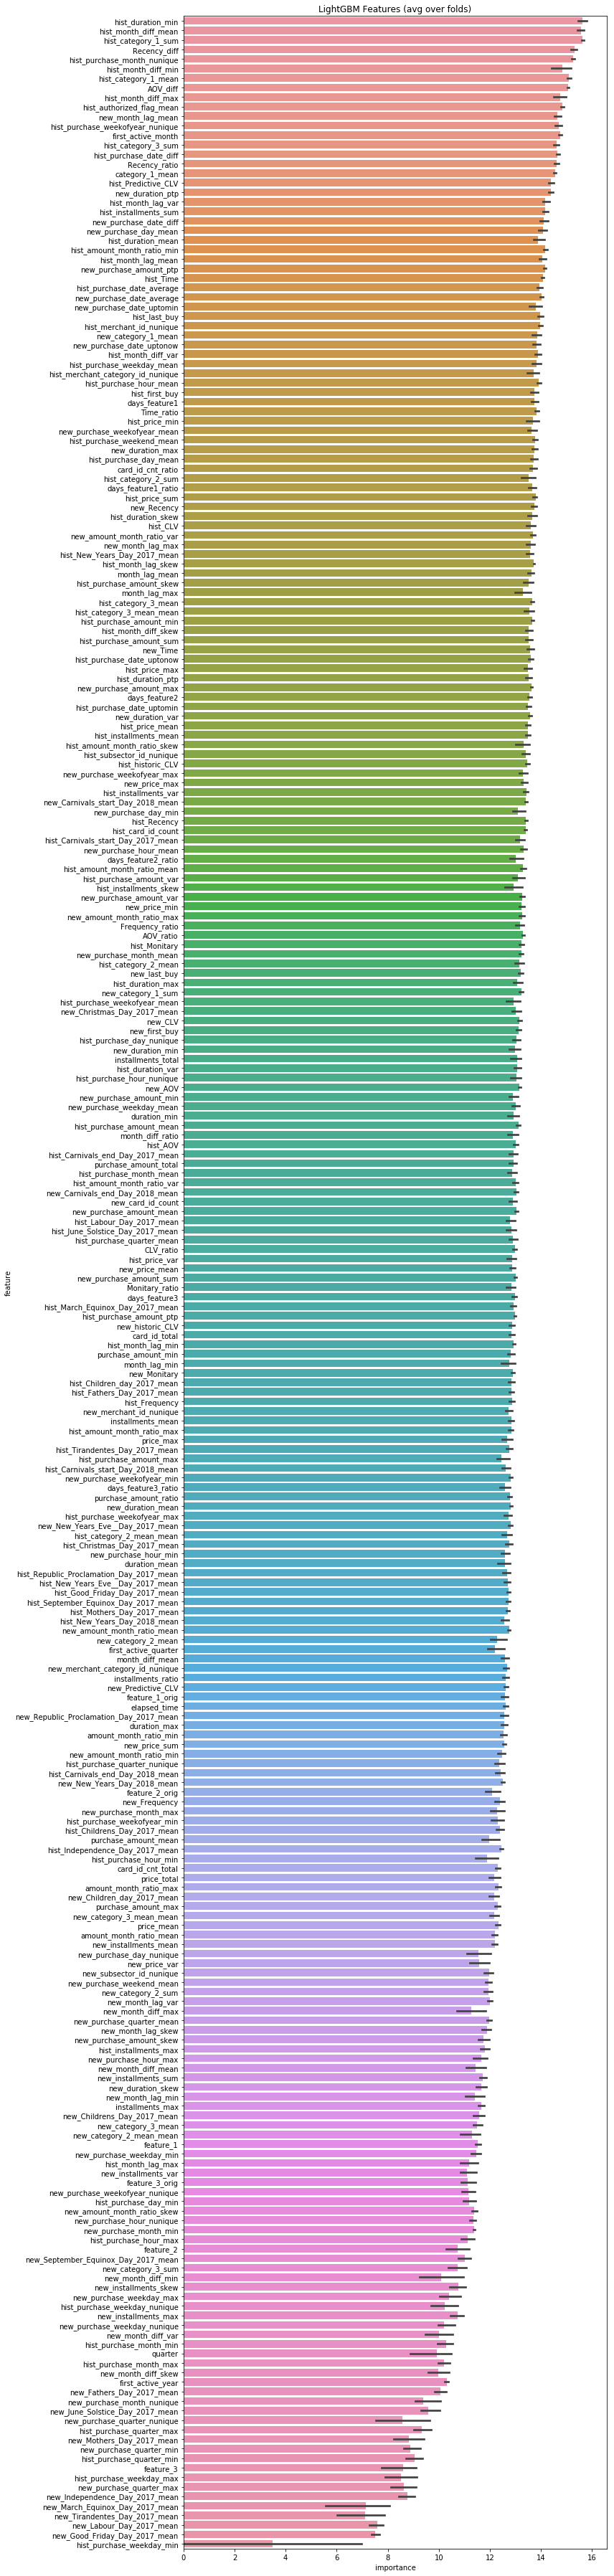

In [426]:
display_importances(feature_importance_df)

In [434]:
train_df = pd.read_hdf('Elo_result.h5', 'train_LB_3688')
test_df = pd.read_hdf('Elo_result.h5', 'test_LB_3688')

exclud = ['hist_purchase_weekday_min']

train_df = train_df.drop(exclud, axis=1)
test_df = test_df.drop(exclud, axis=1)
train_df.shape

(201917, 273)

In [459]:
hist_df = pd.read_csv('/Users/jincui/Downloads/ELO/historical_transactions.csv', )
new_merchant_df = pd.read_csv('/Users/jincui/Downloads/ELO/new_merchant_transactions.csv', )
#hist_df = hist_df.set_index('card_id')
#new_merchant_df = new_merchant_df.set_index('card_id')

In [460]:
new_merchant_df.head()

authorized_flag          card_id  city_id category_1  installments  \
0               Y  C_ID_415bb3a509      107          N             1   
1               Y  C_ID_415bb3a509      140          N             1   
2               Y  C_ID_415bb3a509      330          N             1   
3               Y  C_ID_415bb3a509       -1          Y             1   
4               Y  C_ID_ef55cf8d4b       -1          Y             1   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          B                   307  M_ID_b0c793002c          1   
1          B                   307  M_ID_88920c89e8          1   
2          B                   507  M_ID_ad5237ef6b          2   
3          B                   661  M_ID_9e84cda3b1          1   
4          B                   166  M_ID_3c86fa3831          1   

   purchase_amount        purchase_date  category_2  state_id  subsector_id  
0        -0.557574  2018-03-11 14:57:36         1.0         9            19  
1        -0.569580  2018-03-19 18:53:37         1.0         9            19  
2        -0.551037  2018-04-26 14:08:44         1.0         9            14  
3        -0.671925  2018-03-07 09:43:21         NaN        -1             8  
4        -0.659904  2018-03-22 21:07:53         NaN        -1            29

In [461]:
hist_df.head()

authorized_flag          card_id  city_id category_1  installments  \
0               Y  C_ID_4e6213e9bc       88          N             0   
1               Y  C_ID_4e6213e9bc       88          N             0   
2               Y  C_ID_4e6213e9bc       88          N             0   
3               Y  C_ID_4e6213e9bc       88          N             0   
4               Y  C_ID_4e6213e9bc       88          N             0   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          A                    80  M_ID_e020e9b302         -8   
1          A                   367  M_ID_86ec983688         -7   
2          A                    80  M_ID_979ed661fc         -6   
3          A                   560  M_ID_e6d5ae8ea6         -5   
4          A                    80  M_ID_e020e9b302        -11   

   purchase_amount        purchase_date  category_2  state_id  subsector_id  
0        -0.703331  2017-06-25 15:33:07         1.0        16            37  
1        -0.733128  2017-07-15 12:10:45         1.0        16            16  
2        -0.720386  2017-08-09 22:04:29         1.0        16            37  
3        -0.735352  2017-09-02 10:06:26         1.0        16            34  
4        -0.722865  2017-03-10 01:14:19         1.0        16            37

In [470]:
for df in [hist_df, new_merchant_df]:
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    df['purchase_amount'] = df['purchase_amount'].apply(lambda x: min(x, 0.8))


In [472]:
aggs = {}
aggs['merchant_id'] = ['count', 'nunique']
aggs['purchase_amount'] = ['sum']

hist_agg = hist_df.groupby(['card_id', 'month_lag']).agg(aggs)
new_agg = new_merchant_df.groupby(['card_id', 'month_lag']).agg(aggs)

In [476]:
hist_agg.columns = ['_'.join(col).strip() for col in hist_agg.columns.values]
new_agg.columns = ['_'.join(col).strip() for col in new_agg.columns.values]


In [478]:
hist_agg = hist_agg.reset_index()
new_agg = new_agg.reset_index()

In [492]:
hist_agg.head()

card_id  month_lag  merchant_id_count  merchant_id_nunique  \
0  C_ID_00007093c1        -12                  4                    3   
1  C_ID_00007093c1        -11                 10                    2   
2  C_ID_00007093c1        -10                 12                    5   
3  C_ID_00007093c1         -9                 10                    4   
4  C_ID_00007093c1         -8                 19                    9   

   purchase_amount_sum  
0            -1.334414  
1            -5.712629  
2            -6.508689  
3            -3.425248  
4            -9.868677

In [493]:
hist_agg = hist_agg.set_index('card_id')
new_agg = new_agg.set_index('card_id')

In [494]:
hist_agg_0 = hist_agg[hist_agg['month_lag']==0]
hist_agg_1 = hist_agg[hist_agg['month_lag']==-1]
hist_agg_2 = hist_agg[hist_agg['month_lag']==-2]
hist_agg_3 = hist_agg[hist_agg['month_lag']==-3]
hist_agg_4 = hist_agg[hist_agg['month_lag']==-4]
hist_agg_5 = hist_agg[hist_agg['month_lag']==-5]
hist_agg_6 = hist_agg[hist_agg['month_lag']==-6]
hist_agg_7 = hist_agg[hist_agg['month_lag']==-7]
hist_agg_8 = hist_agg[hist_agg['month_lag']==-8]
hist_agg_9 = hist_agg[hist_agg['month_lag']==-9]
hist_agg_10 = hist_agg[hist_agg['month_lag']==-10]
hist_agg_11 = hist_agg[hist_agg['month_lag']==-11]
hist_agg_12 = hist_agg[hist_agg['month_lag']==-12]
hist_agg_13 = hist_agg[hist_agg['month_lag']==-13]

new_agg_1 = new_agg[new_agg['month_lag']==1]
new_agg_2 = new_agg[new_agg['month_lag']==2]


In [495]:
def add_suffix(df, num, hist=True):
    if hist:
        string = '_hist_' + str(num)
    else:
        string = '_new_' + str(num)
    new_index = df.columns + string
    df.columns = new_index

In [496]:
num=0
for df in [hist_agg_0, hist_agg_1, hist_agg_2, hist_agg_3, hist_agg_4, hist_agg_5, hist_agg_6,
           hist_agg_7, hist_agg_8, hist_agg_9, hist_agg_10, hist_agg_11, hist_agg_12, hist_agg_13]:
    add_suffix(df, num)
    num+=1

add_suffix(new_agg_1, 1, hist=False)
add_suffix(new_agg_2, 2, hist=False)


In [499]:
train_df = pd.read_hdf('Elo_result.h5', 'train_LB_3688')
test_df = pd.read_hdf('Elo_result.h5', 'test_LB_3688')

df = train_df.append(test_df)

In [500]:
df.shape

(325540, 274)

In [503]:
for DF in [hist_agg_0, hist_agg_1, hist_agg_2, hist_agg_3, hist_agg_4, hist_agg_5, hist_agg_6,
           hist_agg_7, hist_agg_8, hist_agg_9, hist_agg_10, hist_agg_11, hist_agg_12, hist_agg_13,
           new_agg_1, new_agg_2]:
    df = df.join(DF, how='left')
df.shape


(325540, 338)

In [504]:
train_df = df[df['target'].notnull()]
test_df = df[df['target'].isnull()]

In [505]:
del df
gc.collect()

19730

In [506]:
for df in [train_df, test_df]:
    for col in df.columns:
        if col in ['target', 'outliers']:
            pass
        elif (df[col].isna().sum() > 0):
            if (df[col].dtypes == 'float'):
                df[col] = df[col].fillna(0.0)
            elif (df[col].dtypes == 'int'):
                df[col] = df[col].fillna(0)
            else:
                pass

In [507]:
# adding month_lag aggregate data helps reducing rmse a bit
sub_preds, feature_importance_df = kfold_lightgbm(train_df, test_df)


Starting LightGBM. Train shape: (201917, 338), test shape: (123623, 338)
Training until validation scores don't improve for 400 rounds.
[100]	train's rmse: 3.8029	test's rmse: 3.80636
[200]	train's rmse: 3.76196	test's rmse: 3.77548
[300]	train's rmse: 3.72689	test's rmse: 3.75066
[400]	train's rmse: 3.69686	test's rmse: 3.73071
[500]	train's rmse: 3.67069	test's rmse: 3.7145
[600]	train's rmse: 3.6476	test's rmse: 3.70151
[700]	train's rmse: 3.62698	test's rmse: 3.69082
[800]	train's rmse: 3.60828	test's rmse: 3.68212
[900]	train's rmse: 3.59122	test's rmse: 3.67477
[1000]	train's rmse: 3.57568	test's rmse: 3.66866
[1100]	train's rmse: 3.56108	test's rmse: 3.66319
[1200]	train's rmse: 3.54742	test's rmse: 3.65864
[1300]	train's rmse: 3.53452	test's rmse: 3.65478
[1400]	train's rmse: 3.52235	test's rmse: 3.65156
[1500]	train's rmse: 3.51111	test's rmse: 3.64881
[1600]	train's rmse: 3.5003	test's rmse: 3.6463
[1700]	train's rmse: 3.49035	test's rmse: 3.644
[1800]	train's rmse: 3.48113	t

In [509]:
train_df.to_hdf('Elo_result.h5', 'train_CV_3644')
test_df.to_hdf('Elo_result.h5', 'test_CV_3644')

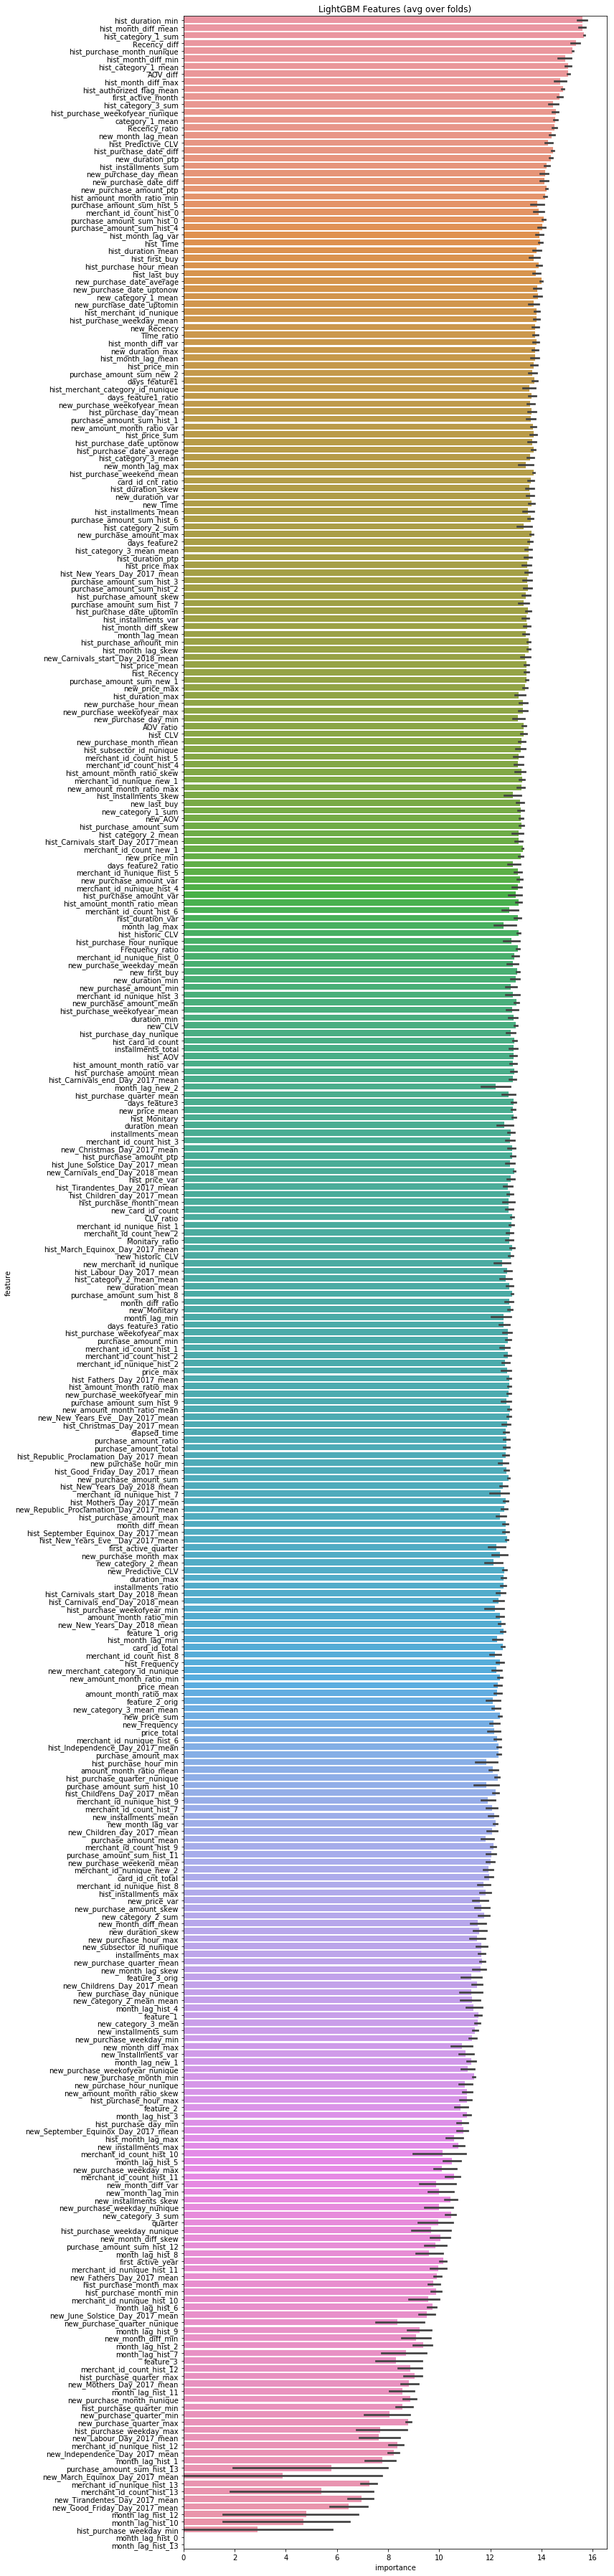

In [508]:
display_importances(feature_importance_df)

In [517]:
## CV 3.6407
## LB 3.687

sub_preds, feature_importance_df = kfold_lightgbm(train_df, test_df, num_folds=11)


Starting LightGBM. Train shape: (201917, 336), test shape: (123623, 336)
Training until validation scores don't improve for 400 rounds.
[100]	train's rmse: 3.80213	test's rmse: 3.8081
[200]	train's rmse: 3.7619	test's rmse: 3.77587
[300]	train's rmse: 3.72798	test's rmse: 3.74968
[400]	train's rmse: 3.69917	test's rmse: 3.72889
[500]	train's rmse: 3.67422	test's rmse: 3.71215
[600]	train's rmse: 3.65248	test's rmse: 3.69836
[700]	train's rmse: 3.6332	test's rmse: 3.68728
[800]	train's rmse: 3.61552	test's rmse: 3.67757
[900]	train's rmse: 3.59955	test's rmse: 3.66948
[1000]	train's rmse: 3.58468	test's rmse: 3.66282
[1100]	train's rmse: 3.57112	test's rmse: 3.65722
[1200]	train's rmse: 3.55832	test's rmse: 3.65218
[1300]	train's rmse: 3.54633	test's rmse: 3.64803
[1400]	train's rmse: 3.53494	test's rmse: 3.64422
[1500]	train's rmse: 3.52424	test's rmse: 3.64053
[1600]	train's rmse: 3.51436	test's rmse: 3.63736
[1700]	train's rmse: 3.50521	test's rmse: 3.63472
[1800]	train's rmse: 3.496

[2000]	train's rmse: 3.47599	test's rmse: 3.66073
[2100]	train's rmse: 3.46851	test's rmse: 3.65978
[2200]	train's rmse: 3.46133	test's rmse: 3.65867
[2300]	train's rmse: 3.454	test's rmse: 3.65769
[2400]	train's rmse: 3.44753	test's rmse: 3.65684
[2500]	train's rmse: 3.44091	test's rmse: 3.65601
[2600]	train's rmse: 3.43465	test's rmse: 3.65527
[2700]	train's rmse: 3.4284	test's rmse: 3.6546
[2800]	train's rmse: 3.4222	test's rmse: 3.65402
[2900]	train's rmse: 3.41617	test's rmse: 3.65356
[3000]	train's rmse: 3.41049	test's rmse: 3.65316
[3100]	train's rmse: 3.40507	test's rmse: 3.65282
[3200]	train's rmse: 3.39953	test's rmse: 3.65247
[3300]	train's rmse: 3.3938	test's rmse: 3.65213
[3400]	train's rmse: 3.38887	test's rmse: 3.65172
[3500]	train's rmse: 3.38389	test's rmse: 3.65132
[3600]	train's rmse: 3.37938	test's rmse: 3.65103
[3700]	train's rmse: 3.37441	test's rmse: 3.6507
[3800]	train's rmse: 3.36967	test's rmse: 3.65042
[3900]	train's rmse: 3.36546	test's rmse: 3.65015
[4000]	

[1900]	train's rmse: 3.49058	test's rmse: 3.62392
[2000]	train's rmse: 3.48295	test's rmse: 3.62189
[2100]	train's rmse: 3.47584	test's rmse: 3.6201
[2200]	train's rmse: 3.46866	test's rmse: 3.61861
[2300]	train's rmse: 3.46174	test's rmse: 3.61736
[2400]	train's rmse: 3.45492	test's rmse: 3.61616
[2500]	train's rmse: 3.44845	test's rmse: 3.61506
[2600]	train's rmse: 3.44206	test's rmse: 3.61413
[2700]	train's rmse: 3.43588	test's rmse: 3.61331
[2800]	train's rmse: 3.42972	test's rmse: 3.61245
[2900]	train's rmse: 3.4237	test's rmse: 3.61159
[3000]	train's rmse: 3.41809	test's rmse: 3.61097
[3100]	train's rmse: 3.41248	test's rmse: 3.61045
[3200]	train's rmse: 3.40729	test's rmse: 3.60974
[3300]	train's rmse: 3.40186	test's rmse: 3.60941
[3400]	train's rmse: 3.39638	test's rmse: 3.60889
[3500]	train's rmse: 3.39158	test's rmse: 3.60847
[3600]	train's rmse: 3.38651	test's rmse: 3.60803
[3700]	train's rmse: 3.38178	test's rmse: 3.60768
[3800]	train's rmse: 3.37734	test's rmse: 3.60723
[3

[5500]	train's rmse: 3.29871	test's rmse: 3.68338
[5600]	train's rmse: 3.29568	test's rmse: 3.68341
[5700]	train's rmse: 3.29265	test's rmse: 3.68335
[5800]	train's rmse: 3.28995	test's rmse: 3.68331
[5900]	train's rmse: 3.28676	test's rmse: 3.68323
[6000]	train's rmse: 3.28363	test's rmse: 3.68333
[6100]	train's rmse: 3.28089	test's rmse: 3.6833
[6200]	train's rmse: 3.27841	test's rmse: 3.68339
Early stopping, best iteration is:
[5897]	train's rmse: 3.28688	test's rmse: 3.68321
Fold 11 RMSE : 3.683211
RMSE is 3.6407042196297588


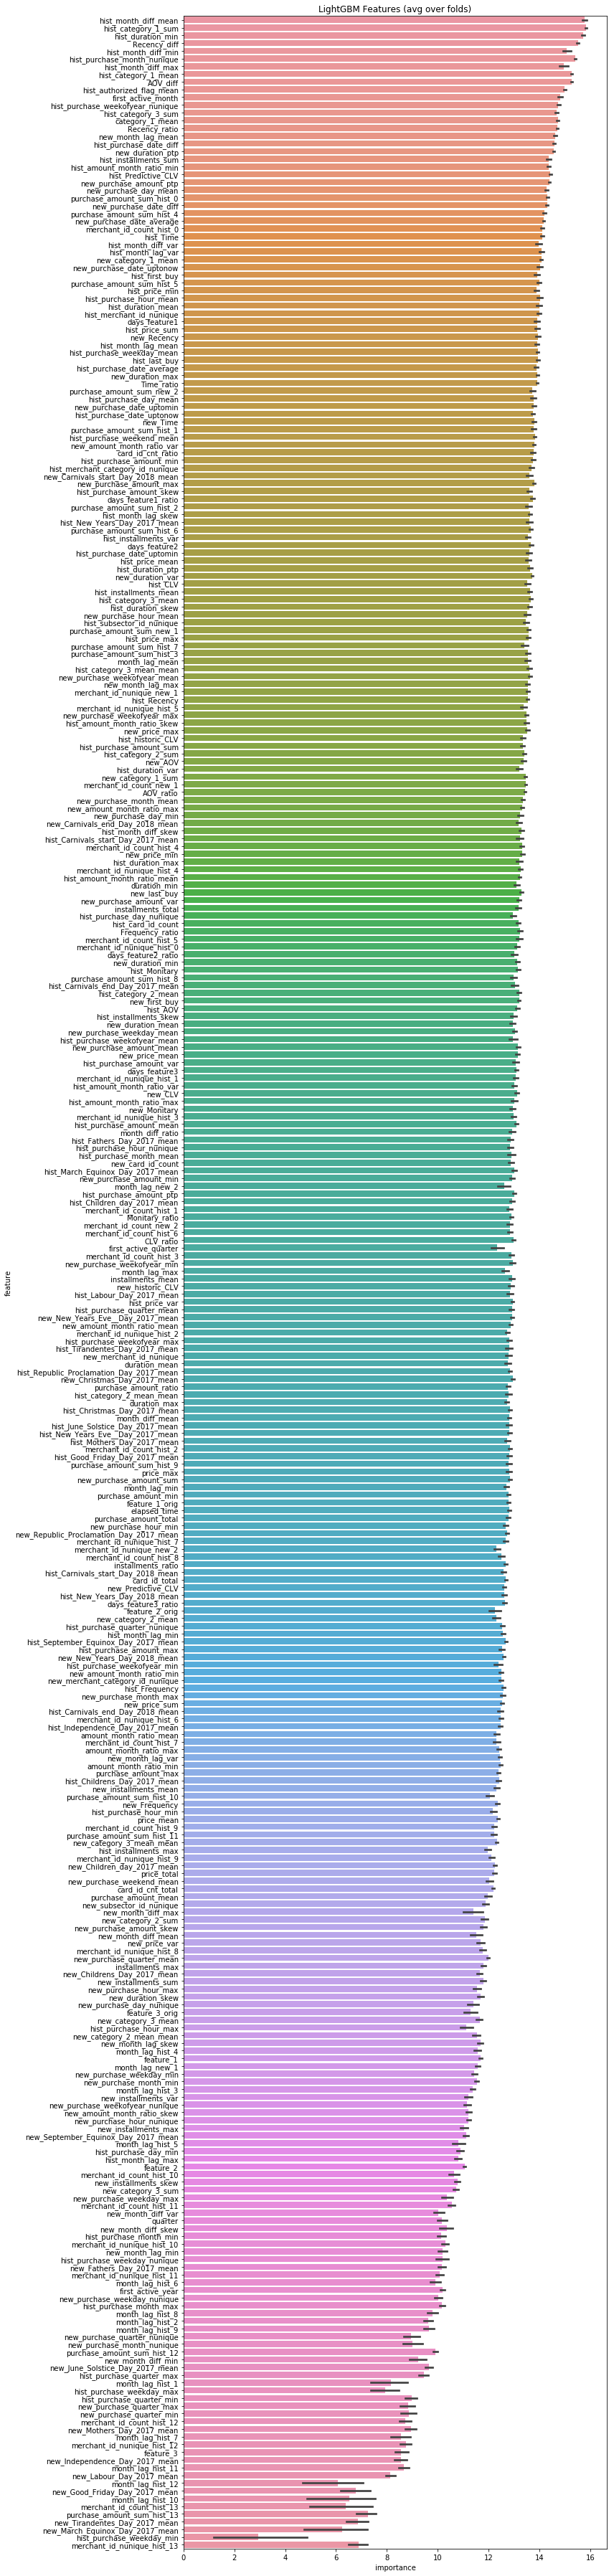

In [518]:
display_importances(feature_importance_df)

In [26]:
train_df = pd.read_hdf('Elo_result.h5', 'train_CV_3644')
test_df = pd.read_hdf('Elo_result.h5', 'test_CV_3644')
train_df.shape

(201917, 338)

In [30]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

def objective(trial, num_folds=4, stratified=True):
    categorical_features = ['feature_1_orig', 'feature_2_orig', 'feature_3_orig','first_active_year', 'first_active_month', 'first_active_year', 'first_active_quarter']
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=326)
        
    oof_preds = np.zeros(train_df.shape[0])
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                categorical_feature=categorical_features)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               categorical_feature=categorical_features)
        param = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'n_jobs': 9, 
                 'boosting_type': 'gbdt',
                 'seed':int(2**n_fold), 'drop_seed': int(2**n_fold), 'feature_fraction_seed': int(2**n_fold),
                 'learning_rate': trial.suggest_uniform('learning_rate', 1e-3, 2e-3),
                 'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 0.6),
                 'num_leaves': trial.suggest_int('num_leaves', 60, 120),
                 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 40),
                 'max_depth': trial.suggest_int('max_depth', 6,12),
                 'reg_alpha': trial.suggest_uniform('reg_alpha', 25, 50),
                 'reg_lambda': trial.suggest_uniform('reg_lambda', 10, 30),
                 'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
                 'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 0.8),
                 'min_child_weight': trial.suggest_int('min_child_weight', 10, 50),
                 'min_split_gain': trial.suggest_int('min_split_gain', 10, 50),
                }
        param['bagging_freq'] = trial.suggest_int('bagging_freq', 6, 10)
        param['bagging_fraction'] = trial.suggest_uniform('bagging_fraction', 0.5, 1.0)
        param['bagging_seed'] = 11
        param['bagging_seed'] = int(2**n_fold)
    
        clf = lgb.train(param, lgb_train, 20000, valid_sets=[lgb_train, lgb_test],
                        verbose_eval=500, early_stopping_rounds=500)
            
        oof_preds[valid_idx] = clf.predict(train_df.iloc[valid_idx][feats], num_iteration=clf.best_iteration)
        
        del clf, train_x, train_y, valid_x, valid_y, train_idx, valid_idx
        gc.collect()
    
    return rmse(oof_preds, train_df['target'])


In [31]:
%%time
study = optuna.create_study()
study.optimize(objective, n_trials=40)
print('study.best_params: \t')
print(study.best_params)
print('study.best_value: \t')
print(study.best_value)
print('study.best_trial.user_attrs: \t')
print(study.best_trial.user_attrs)

optuna_lgb = study.trials_dataframe()
optuna_lgb.to_csv("optuna_lgb_1.csv")

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.67319	valid_1's rmse: 3.70664
[1000]	training's rmse: 3.58975	valid_1's rmse: 3.66231
[1500]	training's rmse: 3.53638	valid_1's rmse: 3.64542
[2000]	training's rmse: 3.49935	valid_1's rmse: 3.63744
[2500]	training's rmse: 3.46729	valid_1's rmse: 3.63239
[3000]	training's rmse: 3.43976	valid_1's rmse: 3.63005
[3500]	training's rmse: 3.41301	valid_1's rmse: 3.62812
[4000]	training's rmse: 3.39073	valid_1's rmse: 3.62724
[4500]	training's rmse: 3.36876	valid_1's rmse: 3.62655
[5000]	training's rmse: 3.34768	valid_1's rmse: 3.62584
[5500]	training's rmse: 3.32749	valid_1's rmse: 3.62606
Early stopping, best iteration is:
[5183]	training's rmse: 3.3403	valid_1's rmse: 3.62579
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.66578	valid_1's rmse: 3.72116
[1000]	training's rmse: 3.5786	valid_1's rmse: 3.68278
[1500]	training's rmse: 3.52503	valid_1's rmse: 3.66973
[20

[I 2019-02-07 00:39:40,851] Finished a trial resulted in value: 3.645700562991989. Current best value is 3.645700562991989 with parameters: {'learning_rate': 0.0017342839510957097, 'feature_fraction': 0.58869172108651, 'num_leaves': 112, 'min_data_in_leaf': 36, 'max_depth': 8, 'reg_alpha': 41.47308164781382, 'reg_lambda': 28.812606072010812, 'subsample': 0.8370166586802287, 'colsample_bytree': 0.6883063046738502, 'min_child_weight': 48, 'min_split_gain': 23, 'bagging_freq': 8, 'bagging_fraction': 0.5614191275178949}.
INFO:optuna.study:Finished a trial resulted in value: 3.645700562991989. Current best value is 3.645700562991989 with parameters: {'learning_rate': 0.0017342839510957097, 'feature_fraction': 0.58869172108651, 'num_leaves': 112, 'min_data_in_leaf': 36, 'max_depth': 8, 'reg_alpha': 41.47308164781382, 'reg_lambda': 28.812606072010812, 'subsample': 0.8370166586802287, 'colsample_bytree': 0.6883063046738502, 'min_child_weight': 48, 'min_split_gain': 23, 'bagging_freq': 8, 'bagg

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69276	valid_1's rmse: 3.72674
[1000]	training's rmse: 3.60577	valid_1's rmse: 3.68048
[1500]	training's rmse: 3.54572	valid_1's rmse: 3.65933
[2000]	training's rmse: 3.50185	valid_1's rmse: 3.64751
[2500]	training's rmse: 3.46649	valid_1's rmse: 3.64009
[3000]	training's rmse: 3.43726	valid_1's rmse: 3.63549
[3500]	training's rmse: 3.41236	valid_1's rmse: 3.63218
[4000]	training's rmse: 3.39214	valid_1's rmse: 3.62976
[4500]	training's rmse: 3.37523	valid_1's rmse: 3.62814
[5000]	training's rmse: 3.36227	valid_1's rmse: 3.62715
[5500]	training's rmse: 3.35213	valid_1's rmse: 3.62654
[6000]	training's rmse: 3.34652	valid_1's rmse: 3.62615
[6500]	training's rmse: 3.34485	valid_1's rmse: 3.62601
[7000]	training's rmse: 3.34418	valid_1's rmse: 3.62593
[7500]	training's rmse: 3.34406	valid_1's rmse: 3.62591
Early stopping, best iteration is:
[7271]	training's rmse: 3.34406	valid_1's rmse: 3.62591
Trainin

[I 2019-02-07 00:50:27,385] Finished a trial resulted in value: 3.645609349653231. Current best value is 3.645609349653231 with parameters: {'learning_rate': 0.0013987811075875222, 'feature_fraction': 0.40698174944131915, 'num_leaves': 60, 'min_data_in_leaf': 27, 'max_depth': 10, 'reg_alpha': 27.789975254316868, 'reg_lambda': 22.83549826829134, 'subsample': 0.8417309819575565, 'colsample_bytree': 0.4817619789338161, 'min_child_weight': 21, 'min_split_gain': 43, 'bagging_freq': 10, 'bagging_fraction': 0.9921742499829875}.
INFO:optuna.study:Finished a trial resulted in value: 3.645609349653231. Current best value is 3.645609349653231 with parameters: {'learning_rate': 0.0013987811075875222, 'feature_fraction': 0.40698174944131915, 'num_leaves': 60, 'min_data_in_leaf': 27, 'max_depth': 10, 'reg_alpha': 27.789975254316868, 'reg_lambda': 22.83549826829134, 'subsample': 0.8417309819575565, 'colsample_bytree': 0.4817619789338161, 'min_child_weight': 21, 'min_split_gain': 43, 'bagging_freq': 1

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.67236	valid_1's rmse: 3.72274
[1000]	training's rmse: 3.56861	valid_1's rmse: 3.67426
[1500]	training's rmse: 3.49576	valid_1's rmse: 3.65268
[2000]	training's rmse: 3.44008	valid_1's rmse: 3.64117
[2500]	training's rmse: 3.39572	valid_1's rmse: 3.63469
[3000]	training's rmse: 3.35989	valid_1's rmse: 3.63067
[3500]	training's rmse: 3.32964	valid_1's rmse: 3.62817
[4000]	training's rmse: 3.30454	valid_1's rmse: 3.62662
[4500]	training's rmse: 3.2841	valid_1's rmse: 3.62563
[5000]	training's rmse: 3.26706	valid_1's rmse: 3.62501
[5500]	training's rmse: 3.25305	valid_1's rmse: 3.62482
[6000]	training's rmse: 3.24045	valid_1's rmse: 3.62463
[6500]	training's rmse: 3.2302	valid_1's rmse: 3.62465
Early stopping, best iteration is:
[6219]	training's rmse: 3.2357	valid_1's rmse: 3.62458
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.66462	valid_1's rmse: 3.73582
[100

[I 2019-02-07 01:04:04,969] Finished a trial resulted in value: 3.6450212988072437. Current best value is 3.6450212988072437 with parameters: {'learning_rate': 0.0013163707500068443, 'feature_fraction': 0.5798803317968589, 'num_leaves': 113, 'min_data_in_leaf': 31, 'max_depth': 9, 'reg_alpha': 25.92659868259797, 'reg_lambda': 15.204929697648206, 'subsample': 0.7536939662987227, 'colsample_bytree': 0.68421996869441, 'min_child_weight': 33, 'min_split_gain': 33, 'bagging_freq': 8, 'bagging_fraction': 0.8142597848734591}.
INFO:optuna.study:Finished a trial resulted in value: 3.6450212988072437. Current best value is 3.6450212988072437 with parameters: {'learning_rate': 0.0013163707500068443, 'feature_fraction': 0.5798803317968589, 'num_leaves': 113, 'min_data_in_leaf': 31, 'max_depth': 9, 'reg_alpha': 25.92659868259797, 'reg_lambda': 15.204929697648206, 'subsample': 0.7536939662987227, 'colsample_bytree': 0.68421996869441, 'min_child_weight': 33, 'min_split_gain': 33, 'bagging_freq': 8, '

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69779	valid_1's rmse: 3.72606
[1000]	training's rmse: 3.61705	valid_1's rmse: 3.68024
[1500]	training's rmse: 3.56259	valid_1's rmse: 3.65934
[2000]	training's rmse: 3.52276	valid_1's rmse: 3.64768
[2500]	training's rmse: 3.49262	valid_1's rmse: 3.64037
[3000]	training's rmse: 3.46813	valid_1's rmse: 3.6357
[3500]	training's rmse: 3.44943	valid_1's rmse: 3.63261
[4000]	training's rmse: 3.43613	valid_1's rmse: 3.63056
[4500]	training's rmse: 3.42736	valid_1's rmse: 3.62951
[5000]	training's rmse: 3.42213	valid_1's rmse: 3.62894
[5500]	training's rmse: 3.41924	valid_1's rmse: 3.62855
[6000]	training's rmse: 3.41747	valid_1's rmse: 3.62828
[6500]	training's rmse: 3.41635	valid_1's rmse: 3.62816
[7000]	training's rmse: 3.41567	valid_1's rmse: 3.62808
[7500]	training's rmse: 3.41524	valid_1's rmse: 3.62802
Early stopping, best iteration is:
[7484]	training's rmse: 3.41525	valid_1's rmse: 3.62802
Training

[I 2019-02-07 01:14:27,100] Finished a trial resulted in value: 3.646337900848377. Current best value is 3.6450212988072437 with parameters: {'learning_rate': 0.0013163707500068443, 'feature_fraction': 0.5798803317968589, 'num_leaves': 113, 'min_data_in_leaf': 31, 'max_depth': 9, 'reg_alpha': 25.92659868259797, 'reg_lambda': 15.204929697648206, 'subsample': 0.7536939662987227, 'colsample_bytree': 0.68421996869441, 'min_child_weight': 33, 'min_split_gain': 33, 'bagging_freq': 8, 'bagging_fraction': 0.8142597848734591}.
INFO:optuna.study:Finished a trial resulted in value: 3.646337900848377. Current best value is 3.6450212988072437 with parameters: {'learning_rate': 0.0013163707500068443, 'feature_fraction': 0.5798803317968589, 'num_leaves': 113, 'min_data_in_leaf': 31, 'max_depth': 9, 'reg_alpha': 25.92659868259797, 'reg_lambda': 15.204929697648206, 'subsample': 0.7536939662987227, 'colsample_bytree': 0.68421996869441, 'min_child_weight': 33, 'min_split_gain': 33, 'bagging_freq': 8, 'ba

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.7241	valid_1's rmse: 3.74361
[1000]	training's rmse: 3.64989	valid_1's rmse: 3.69657
[1500]	training's rmse: 3.59876	valid_1's rmse: 3.67201
[2000]	training's rmse: 3.55962	valid_1's rmse: 3.65801
[2500]	training's rmse: 3.52766	valid_1's rmse: 3.64922
[3000]	training's rmse: 3.50087	valid_1's rmse: 3.64319
[3500]	training's rmse: 3.47704	valid_1's rmse: 3.63883
[4000]	training's rmse: 3.45559	valid_1's rmse: 3.63556
[4500]	training's rmse: 3.43514	valid_1's rmse: 3.63305
[5000]	training's rmse: 3.41612	valid_1's rmse: 3.63129
[5500]	training's rmse: 3.39806	valid_1's rmse: 3.63
[6000]	training's rmse: 3.38101	valid_1's rmse: 3.62906
[6500]	training's rmse: 3.36448	valid_1's rmse: 3.6283
[7000]	training's rmse: 3.3488	valid_1's rmse: 3.62778
[7500]	training's rmse: 3.33378	valid_1's rmse: 3.62726
[8000]	training's rmse: 3.31903	valid_1's rmse: 3.62694
[8500]	training's rmse: 3.30465	valid_1's rmse: 

[I 2019-02-07 01:26:21,579] Finished a trial resulted in value: 3.64564189960506. Current best value is 3.6450212988072437 with parameters: {'learning_rate': 0.0013163707500068443, 'feature_fraction': 0.5798803317968589, 'num_leaves': 113, 'min_data_in_leaf': 31, 'max_depth': 9, 'reg_alpha': 25.92659868259797, 'reg_lambda': 15.204929697648206, 'subsample': 0.7536939662987227, 'colsample_bytree': 0.68421996869441, 'min_child_weight': 33, 'min_split_gain': 33, 'bagging_freq': 8, 'bagging_fraction': 0.8142597848734591}.
INFO:optuna.study:Finished a trial resulted in value: 3.64564189960506. Current best value is 3.6450212988072437 with parameters: {'learning_rate': 0.0013163707500068443, 'feature_fraction': 0.5798803317968589, 'num_leaves': 113, 'min_data_in_leaf': 31, 'max_depth': 9, 'reg_alpha': 25.92659868259797, 'reg_lambda': 15.204929697648206, 'subsample': 0.7536939662987227, 'colsample_bytree': 0.68421996869441, 'min_child_weight': 33, 'min_split_gain': 33, 'bagging_freq': 8, 'bagg

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.65627	valid_1's rmse: 3.71155
[1000]	training's rmse: 3.55424	valid_1's rmse: 3.66913
[1500]	training's rmse: 3.48535	valid_1's rmse: 3.65145
[2000]	training's rmse: 3.43781	valid_1's rmse: 3.64235
[2500]	training's rmse: 3.40578	valid_1's rmse: 3.63717
[3000]	training's rmse: 3.38634	valid_1's rmse: 3.63406
[3500]	training's rmse: 3.37654	valid_1's rmse: 3.63258
[4000]	training's rmse: 3.37044	valid_1's rmse: 3.6317
[4500]	training's rmse: 3.36645	valid_1's rmse: 3.63116
[5000]	training's rmse: 3.36405	valid_1's rmse: 3.63078
[5500]	training's rmse: 3.36272	valid_1's rmse: 3.63053
[6000]	training's rmse: 3.36144	valid_1's rmse: 3.63031
[6500]	training's rmse: 3.36047	valid_1's rmse: 3.63018
[7000]	training's rmse: 3.35981	valid_1's rmse: 3.63008
[7500]	training's rmse: 3.3592	valid_1's rmse: 3.63003
[8000]	training's rmse: 3.35863	valid_1's rmse: 3.62999
[8500]	training's rmse: 3.35817	valid_1's rm

[I 2019-02-07 01:32:32,631] Finished a trial resulted in value: 3.6473706186139667. Current best value is 3.6450212988072437 with parameters: {'learning_rate': 0.0013163707500068443, 'feature_fraction': 0.5798803317968589, 'num_leaves': 113, 'min_data_in_leaf': 31, 'max_depth': 9, 'reg_alpha': 25.92659868259797, 'reg_lambda': 15.204929697648206, 'subsample': 0.7536939662987227, 'colsample_bytree': 0.68421996869441, 'min_child_weight': 33, 'min_split_gain': 33, 'bagging_freq': 8, 'bagging_fraction': 0.8142597848734591}.
INFO:optuna.study:Finished a trial resulted in value: 3.6473706186139667. Current best value is 3.6450212988072437 with parameters: {'learning_rate': 0.0013163707500068443, 'feature_fraction': 0.5798803317968589, 'num_leaves': 113, 'min_data_in_leaf': 31, 'max_depth': 9, 'reg_alpha': 25.92659868259797, 'reg_lambda': 15.204929697648206, 'subsample': 0.7536939662987227, 'colsample_bytree': 0.68421996869441, 'min_child_weight': 33, 'min_split_gain': 33, 'bagging_freq': 8, '

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.71014	valid_1's rmse: 3.73839
[1000]	training's rmse: 3.62678	valid_1's rmse: 3.68974
[1500]	training's rmse: 3.56915	valid_1's rmse: 3.66532
[2000]	training's rmse: 3.52407	valid_1's rmse: 3.65184
[2500]	training's rmse: 3.48854	valid_1's rmse: 3.64347
[3000]	training's rmse: 3.45963	valid_1's rmse: 3.63776
[3500]	training's rmse: 3.43491	valid_1's rmse: 3.63405
[4000]	training's rmse: 3.41316	valid_1's rmse: 3.63147
[4500]	training's rmse: 3.39427	valid_1's rmse: 3.62974
[5000]	training's rmse: 3.37757	valid_1's rmse: 3.62851
[5500]	training's rmse: 3.36331	valid_1's rmse: 3.6276
[6000]	training's rmse: 3.35052	valid_1's rmse: 3.62694
[6500]	training's rmse: 3.33927	valid_1's rmse: 3.62653
[7000]	training's rmse: 3.32937	valid_1's rmse: 3.62616
[7500]	training's rmse: 3.32057	valid_1's rmse: 3.6259
[8000]	training's rmse: 3.31301	valid_1's rmse: 3.6257
[8500]	training's rmse: 3.30628	valid_1's rms

[I 2019-02-07 01:44:50,378] Finished a trial resulted in value: 3.644087206813321. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'bagging_fraction': 0.8777752960505053}.
INFO:optuna.study:Finished a trial resulted in value: 3.644087206813321. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'ba

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69109	valid_1's rmse: 3.72204
[1000]	training's rmse: 3.60854	valid_1's rmse: 3.67683
[1500]	training's rmse: 3.55337	valid_1's rmse: 3.65727
[2000]	training's rmse: 3.51378	valid_1's rmse: 3.647
[2500]	training's rmse: 3.48388	valid_1's rmse: 3.64064
[3000]	training's rmse: 3.45883	valid_1's rmse: 3.63664
[3500]	training's rmse: 3.43813	valid_1's rmse: 3.63418
[4000]	training's rmse: 3.42113	valid_1's rmse: 3.63264
[4500]	training's rmse: 3.40708	valid_1's rmse: 3.63141
[5000]	training's rmse: 3.39587	valid_1's rmse: 3.63057
[5500]	training's rmse: 3.38571	valid_1's rmse: 3.63001
[6000]	training's rmse: 3.37722	valid_1's rmse: 3.62966
[6500]	training's rmse: 3.36881	valid_1's rmse: 3.62947
[7000]	training's rmse: 3.36192	valid_1's rmse: 3.62925
[7500]	training's rmse: 3.35559	valid_1's rmse: 3.62913
[8000]	training's rmse: 3.34972	valid_1's rmse: 3.62902
[8500]	training's rmse: 3.34482	valid_1's rm

[I 2019-02-07 01:52:04,912] Finished a trial resulted in value: 3.6455031478077116. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'bagging_fraction': 0.8777752960505053}.
INFO:optuna.study:Finished a trial resulted in value: 3.6455031478077116. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, '

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.63857	valid_1's rmse: 3.70145
[1000]	training's rmse: 3.53134	valid_1's rmse: 3.66067
[1500]	training's rmse: 3.46369	valid_1's rmse: 3.64381
[2000]	training's rmse: 3.41396	valid_1's rmse: 3.6358
[2500]	training's rmse: 3.37441	valid_1's rmse: 3.63098
[3000]	training's rmse: 3.34206	valid_1's rmse: 3.62798
[3500]	training's rmse: 3.31706	valid_1's rmse: 3.62615
[4000]	training's rmse: 3.29897	valid_1's rmse: 3.62517
[4500]	training's rmse: 3.28996	valid_1's rmse: 3.62477
[5000]	training's rmse: 3.28734	valid_1's rmse: 3.6246
[5500]	training's rmse: 3.28614	valid_1's rmse: 3.62457
[6000]	training's rmse: 3.28544	valid_1's rmse: 3.62452
Early stopping, best iteration is:
[5934]	training's rmse: 3.28547	valid_1's rmse: 3.62452
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.62752	valid_1's rmse: 3.71699
[1000]	training's rmse: 3.51793	valid_1's rmse: 3.68508
[15

[I 2019-02-07 02:01:31,638] Finished a trial resulted in value: 3.6467353396558235. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'bagging_fraction': 0.8777752960505053}.
INFO:optuna.study:Finished a trial resulted in value: 3.6467353396558235. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, '

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.71499	valid_1's rmse: 3.74091
[1000]	training's rmse: 3.6351	valid_1's rmse: 3.69426
[1500]	training's rmse: 3.57944	valid_1's rmse: 3.67097
[2000]	training's rmse: 3.53647	valid_1's rmse: 3.6572
[2500]	training's rmse: 3.50311	valid_1's rmse: 3.64869
[3000]	training's rmse: 3.47562	valid_1's rmse: 3.64274
[3500]	training's rmse: 3.45226	valid_1's rmse: 3.6386
[4000]	training's rmse: 3.43262	valid_1's rmse: 3.63557
[4500]	training's rmse: 3.41651	valid_1's rmse: 3.63344
[5000]	training's rmse: 3.40392	valid_1's rmse: 3.63185
[5500]	training's rmse: 3.39378	valid_1's rmse: 3.63086
[6000]	training's rmse: 3.38652	valid_1's rmse: 3.63011
[6500]	training's rmse: 3.38064	valid_1's rmse: 3.62954
[7000]	training's rmse: 3.37631	valid_1's rmse: 3.6292
[7500]	training's rmse: 3.37234	valid_1's rmse: 3.62889
[8000]	training's rmse: 3.36956	valid_1's rmse: 3.62868
[8500]	training's rmse: 3.36731	valid_1's rmse

[I 2019-02-07 02:11:11,361] Finished a trial resulted in value: 3.6461205730211157. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'bagging_fraction': 0.8777752960505053}.
INFO:optuna.study:Finished a trial resulted in value: 3.6461205730211157. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, '

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.73654	valid_1's rmse: 3.74423
[1000]	training's rmse: 3.6751	valid_1's rmse: 3.69699
[1500]	training's rmse: 3.63678	valid_1's rmse: 3.67278
[2000]	training's rmse: 3.60923	valid_1's rmse: 3.65901
[2500]	training's rmse: 3.58879	valid_1's rmse: 3.65069
[3000]	training's rmse: 3.57162	valid_1's rmse: 3.64474
[3500]	training's rmse: 3.55604	valid_1's rmse: 3.64041
[4000]	training's rmse: 3.54242	valid_1's rmse: 3.63728
[4500]	training's rmse: 3.53009	valid_1's rmse: 3.63519
[5000]	training's rmse: 3.51828	valid_1's rmse: 3.63359
[5500]	training's rmse: 3.50692	valid_1's rmse: 3.63222
[6000]	training's rmse: 3.49656	valid_1's rmse: 3.63121
[6500]	training's rmse: 3.48621	valid_1's rmse: 3.63053
[7000]	training's rmse: 3.47617	valid_1's rmse: 3.6297
[7500]	training's rmse: 3.46638	valid_1's rmse: 3.62912
[8000]	training's rmse: 3.45669	valid_1's rmse: 3.62873
[8500]	training's rmse: 3.44734	valid_1's rm

[I 2019-02-07 02:24:31,905] Finished a trial resulted in value: 3.645087804826327. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'bagging_fraction': 0.8777752960505053}.
INFO:optuna.study:Finished a trial resulted in value: 3.645087804826327. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'ba

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.72314	valid_1's rmse: 3.74051
[1000]	training's rmse: 3.64993	valid_1's rmse: 3.69155
[1500]	training's rmse: 3.6009	valid_1's rmse: 3.66649
[2000]	training's rmse: 3.56371	valid_1's rmse: 3.65247
[2500]	training's rmse: 3.53432	valid_1's rmse: 3.64434
[3000]	training's rmse: 3.50991	valid_1's rmse: 3.63913
[3500]	training's rmse: 3.48778	valid_1's rmse: 3.63512
[4000]	training's rmse: 3.46846	valid_1's rmse: 3.63224
[4500]	training's rmse: 3.4505	valid_1's rmse: 3.63028
[5000]	training's rmse: 3.43398	valid_1's rmse: 3.62894
[5500]	training's rmse: 3.41746	valid_1's rmse: 3.62765
[6000]	training's rmse: 3.40323	valid_1's rmse: 3.62692
[6500]	training's rmse: 3.38962	valid_1's rmse: 3.62637
[7000]	training's rmse: 3.37623	valid_1's rmse: 3.62595
[7500]	training's rmse: 3.36344	valid_1's rmse: 3.62548
[8000]	training's rmse: 3.35061	valid_1's rmse: 3.62531
[8500]	training's rmse: 3.3386	valid_1's rms

[I 2019-02-07 02:37:31,798] Finished a trial resulted in value: 3.6443228502729084. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'bagging_fraction': 0.8777752960505053}.
INFO:optuna.study:Finished a trial resulted in value: 3.6443228502729084. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, '

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.74119	valid_1's rmse: 3.75084
[1000]	training's rmse: 3.68065	valid_1's rmse: 3.70696
[1500]	training's rmse: 3.64155	valid_1's rmse: 3.68389
[2000]	training's rmse: 3.61369	valid_1's rmse: 3.67036
[2500]	training's rmse: 3.59243	valid_1's rmse: 3.66166
[3000]	training's rmse: 3.57538	valid_1's rmse: 3.65576
[3500]	training's rmse: 3.5608	valid_1's rmse: 3.65153
[4000]	training's rmse: 3.54828	valid_1's rmse: 3.64827
[4500]	training's rmse: 3.53677	valid_1's rmse: 3.64598
[5000]	training's rmse: 3.52686	valid_1's rmse: 3.64423
[5500]	training's rmse: 3.51776	valid_1's rmse: 3.6427
[6000]	training's rmse: 3.50946	valid_1's rmse: 3.6415
[6500]	training's rmse: 3.50142	valid_1's rmse: 3.64041
[7000]	training's rmse: 3.49416	valid_1's rmse: 3.6396
[7500]	training's rmse: 3.48716	valid_1's rmse: 3.63877
[8000]	training's rmse: 3.48064	valid_1's rmse: 3.63825
[8500]	training's rmse: 3.47437	valid_1's rmse

[I 2019-02-07 02:44:52,742] Finished a trial resulted in value: 3.6506991858701445. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'bagging_fraction': 0.8777752960505053}.
INFO:optuna.study:Finished a trial resulted in value: 3.6506991858701445. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, '

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.74139	valid_1's rmse: 3.75309
[1000]	training's rmse: 3.67548	valid_1's rmse: 3.70586
[1500]	training's rmse: 3.63129	valid_1's rmse: 3.68038
[2000]	training's rmse: 3.59793	valid_1's rmse: 3.6652
[2500]	training's rmse: 3.57099	valid_1's rmse: 3.6551
[3000]	training's rmse: 3.54908	valid_1's rmse: 3.64842
[3500]	training's rmse: 3.53036	valid_1's rmse: 3.64365
[4000]	training's rmse: 3.5132	valid_1's rmse: 3.63997
[4500]	training's rmse: 3.49758	valid_1's rmse: 3.63712
[5000]	training's rmse: 3.48284	valid_1's rmse: 3.63495
[5500]	training's rmse: 3.46905	valid_1's rmse: 3.63322
[6000]	training's rmse: 3.45581	valid_1's rmse: 3.63175
[6500]	training's rmse: 3.44334	valid_1's rmse: 3.63065
[7000]	training's rmse: 3.43096	valid_1's rmse: 3.62973
[7500]	training's rmse: 3.41935	valid_1's rmse: 3.62901
[8000]	training's rmse: 3.40844	valid_1's rmse: 3.62845
[8500]	training's rmse: 3.39743	valid_1's rms

[I 2019-02-07 02:59:38,650] Finished a trial resulted in value: 3.644358336311252. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'bagging_fraction': 0.8777752960505053}.
INFO:optuna.study:Finished a trial resulted in value: 3.644358336311252. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'ba

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.66774	valid_1's rmse: 3.71074
[1000]	training's rmse: 3.5743	valid_1's rmse: 3.66493
[1500]	training's rmse: 3.5118	valid_1's rmse: 3.64644
[2000]	training's rmse: 3.46549	valid_1's rmse: 3.63762
[2500]	training's rmse: 3.42803	valid_1's rmse: 3.63249
[3000]	training's rmse: 3.39535	valid_1's rmse: 3.62956
[3500]	training's rmse: 3.36404	valid_1's rmse: 3.62758
[4000]	training's rmse: 3.33593	valid_1's rmse: 3.62675
[4500]	training's rmse: 3.30903	valid_1's rmse: 3.6261
Early stopping, best iteration is:
[4475]	training's rmse: 3.31006	valid_1's rmse: 3.62605
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.66071	valid_1's rmse: 3.72319
[1000]	training's rmse: 3.5641	valid_1's rmse: 3.68357
[1500]	training's rmse: 3.49899	valid_1's rmse: 3.66952
[2000]	training's rmse: 3.45124	valid_1's rmse: 3.66343
[2500]	training's rmse: 3.4138	valid_1's rmse: 3.66072
[3000]

[I 2019-02-07 03:08:15,874] Finished a trial resulted in value: 3.644873144072675. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'bagging_fraction': 0.8777752960505053}.
INFO:optuna.study:Finished a trial resulted in value: 3.644873144072675. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'ba

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.73051	valid_1's rmse: 3.7393
[1000]	training's rmse: 3.66859	valid_1's rmse: 3.69271
[1500]	training's rmse: 3.63091	valid_1's rmse: 3.66999
[2000]	training's rmse: 3.60455	valid_1's rmse: 3.65722
[2500]	training's rmse: 3.5848	valid_1's rmse: 3.6495
[3000]	training's rmse: 3.56819	valid_1's rmse: 3.64395
[3500]	training's rmse: 3.55301	valid_1's rmse: 3.64008
[4000]	training's rmse: 3.53971	valid_1's rmse: 3.63726
[4500]	training's rmse: 3.52767	valid_1's rmse: 3.63531
[5000]	training's rmse: 3.51659	valid_1's rmse: 3.63369
[5500]	training's rmse: 3.50614	valid_1's rmse: 3.63261
[6000]	training's rmse: 3.49634	valid_1's rmse: 3.63164
[6500]	training's rmse: 3.4871	valid_1's rmse: 3.631
[7000]	training's rmse: 3.47805	valid_1's rmse: 3.6304
[7500]	training's rmse: 3.46929	valid_1's rmse: 3.62993
[8000]	training's rmse: 3.46099	valid_1's rmse: 3.62961
[8500]	training's rmse: 3.45314	valid_1's rmse: 3

[I 2019-02-07 03:17:37,202] Finished a trial resulted in value: 3.646043051007135. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'bagging_fraction': 0.8777752960505053}.
INFO:optuna.study:Finished a trial resulted in value: 3.646043051007135. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'ba

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68261	valid_1's rmse: 3.72496
[1000]	training's rmse: 3.58632	valid_1's rmse: 3.6776
[1500]	training's rmse: 3.51842	valid_1's rmse: 3.65623
[2000]	training's rmse: 3.46522	valid_1's rmse: 3.64493
[2500]	training's rmse: 3.42489	valid_1's rmse: 3.63811
[3000]	training's rmse: 3.39334	valid_1's rmse: 3.63411
[3500]	training's rmse: 3.36686	valid_1's rmse: 3.63145
[4000]	training's rmse: 3.34662	valid_1's rmse: 3.62986
[4500]	training's rmse: 3.33167	valid_1's rmse: 3.62889
[5000]	training's rmse: 3.3204	valid_1's rmse: 3.62825
[5500]	training's rmse: 3.31196	valid_1's rmse: 3.62795
[6000]	training's rmse: 3.30598	valid_1's rmse: 3.62779
[6500]	training's rmse: 3.30112	valid_1's rmse: 3.62764
[7000]	training's rmse: 3.29709	valid_1's rmse: 3.6275
[7500]	training's rmse: 3.29384	valid_1's rmse: 3.62743
[8000]	training's rmse: 3.29136	valid_1's rmse: 3.62736
[8500]	training's rmse: 3.28931	valid_1's rms

[I 2019-02-07 03:28:12,705] Finished a trial resulted in value: 3.644812374056215. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'bagging_fraction': 0.8777752960505053}.
INFO:optuna.study:Finished a trial resulted in value: 3.644812374056215. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'ba

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.72741	valid_1's rmse: 3.74365
[1000]	training's rmse: 3.6556	valid_1's rmse: 3.69493
[1500]	training's rmse: 3.60715	valid_1's rmse: 3.66936
[2000]	training's rmse: 3.57021	valid_1's rmse: 3.65514
[2500]	training's rmse: 3.54105	valid_1's rmse: 3.64646
[3000]	training's rmse: 3.51735	valid_1's rmse: 3.64103
[3500]	training's rmse: 3.49606	valid_1's rmse: 3.63686
[4000]	training's rmse: 3.4774	valid_1's rmse: 3.63411
[4500]	training's rmse: 3.46025	valid_1's rmse: 3.63195
[5000]	training's rmse: 3.44498	valid_1's rmse: 3.63031
[5500]	training's rmse: 3.43014	valid_1's rmse: 3.62918
[6000]	training's rmse: 3.41731	valid_1's rmse: 3.6284
[6500]	training's rmse: 3.40489	valid_1's rmse: 3.62785
[7000]	training's rmse: 3.39288	valid_1's rmse: 3.62738
[7500]	training's rmse: 3.38164	valid_1's rmse: 3.62706
[8000]	training's rmse: 3.37058	valid_1's rmse: 3.6266
[8500]	training's rmse: 3.36075	valid_1's rmse

[I 2019-02-07 03:42:53,745] Finished a trial resulted in value: 3.644528006532066. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'bagging_fraction': 0.8777752960505053}.
INFO:optuna.study:Finished a trial resulted in value: 3.644528006532066. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'ba

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.7342	valid_1's rmse: 3.74202
[1000]	training's rmse: 3.6719	valid_1's rmse: 3.69403
[1500]	training's rmse: 3.63311	valid_1's rmse: 3.67
[2000]	training's rmse: 3.60585	valid_1's rmse: 3.657
[2500]	training's rmse: 3.58435	valid_1's rmse: 3.64868
[3000]	training's rmse: 3.56676	valid_1's rmse: 3.6426
[3500]	training's rmse: 3.55118	valid_1's rmse: 3.63837
[4000]	training's rmse: 3.5376	valid_1's rmse: 3.63552
[4500]	training's rmse: 3.52536	valid_1's rmse: 3.6335
[5000]	training's rmse: 3.51369	valid_1's rmse: 3.63196
[5500]	training's rmse: 3.50219	valid_1's rmse: 3.63078
[6000]	training's rmse: 3.4919	valid_1's rmse: 3.62993
[6500]	training's rmse: 3.48153	valid_1's rmse: 3.629
[7000]	training's rmse: 3.4714	valid_1's rmse: 3.62835
[7500]	training's rmse: 3.46194	valid_1's rmse: 3.62789
[8000]	training's rmse: 3.45286	valid_1's rmse: 3.62756
[8500]	training's rmse: 3.44327	valid_1's rmse: 3.62726


[I 2019-02-07 03:55:42,341] Finished a trial resulted in value: 3.645130793697245. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'bagging_fraction': 0.8777752960505053}.
INFO:optuna.study:Finished a trial resulted in value: 3.645130793697245. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'ba

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.71977	valid_1's rmse: 3.73795
[1000]	training's rmse: 3.64602	valid_1's rmse: 3.68935
[1500]	training's rmse: 3.59686	valid_1's rmse: 3.6651
[2000]	training's rmse: 3.55955	valid_1's rmse: 3.65217
[2500]	training's rmse: 3.53039	valid_1's rmse: 3.6442
[3000]	training's rmse: 3.50586	valid_1's rmse: 3.63902
[3500]	training's rmse: 3.48326	valid_1's rmse: 3.63529
[4000]	training's rmse: 3.46316	valid_1's rmse: 3.63269
[4500]	training's rmse: 3.44453	valid_1's rmse: 3.63057
[5000]	training's rmse: 3.42709	valid_1's rmse: 3.62929
[5500]	training's rmse: 3.40952	valid_1's rmse: 3.62821
[6000]	training's rmse: 3.39409	valid_1's rmse: 3.62725
[6500]	training's rmse: 3.37911	valid_1's rmse: 3.62667
[7000]	training's rmse: 3.36414	valid_1's rmse: 3.62624
[7500]	training's rmse: 3.3493	valid_1's rmse: 3.62576
[8000]	training's rmse: 3.33497	valid_1's rmse: 3.62555
[8500]	training's rmse: 3.32128	valid_1's rms

[I 2019-02-07 04:08:02,344] Finished a trial resulted in value: 3.6441125663663088. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, 'bagging_fraction': 0.8777752960505053}.
INFO:optuna.study:Finished a trial resulted in value: 3.6441125663663088. Current best value is 3.644087206813321 with parameters: {'learning_rate': 0.001114017904273736, 'feature_fraction': 0.33049359838980086, 'num_leaves': 105, 'min_data_in_leaf': 34, 'max_depth': 8, 'reg_alpha': 27.4236445058076, 'reg_lambda': 17.821766881687637, 'subsample': 0.7568974364070363, 'colsample_bytree': 0.6306009448331955, 'min_child_weight': 29, 'min_split_gain': 30, 'bagging_freq': 7, '

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.70994	valid_1's rmse: 3.73827
[1000]	training's rmse: 3.62601	valid_1's rmse: 3.68939
[1500]	training's rmse: 3.56765	valid_1's rmse: 3.66539
[2000]	training's rmse: 3.52155	valid_1's rmse: 3.65164
[2500]	training's rmse: 3.48376	valid_1's rmse: 3.64354
[3000]	training's rmse: 3.45223	valid_1's rmse: 3.63778
[3500]	training's rmse: 3.42399	valid_1's rmse: 3.63374
[4000]	training's rmse: 3.39895	valid_1's rmse: 3.63119
[4500]	training's rmse: 3.37545	valid_1's rmse: 3.6292
[5000]	training's rmse: 3.35367	valid_1's rmse: 3.62776
[5500]	training's rmse: 3.33256	valid_1's rmse: 3.62681
[6000]	training's rmse: 3.31324	valid_1's rmse: 3.62597
[6500]	training's rmse: 3.29453	valid_1's rmse: 3.62529
[7000]	training's rmse: 3.27623	valid_1's rmse: 3.62496
[7500]	training's rmse: 3.25914	valid_1's rmse: 3.62468
[8000]	training's rmse: 3.24198	valid_1's rmse: 3.62427
[8500]	training's rmse: 3.22575	valid_1's r

[I 2019-02-07 04:21:14,247] Finished a trial resulted in value: 3.643876269973101. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.643876269973101. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'baggin

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69045	valid_1's rmse: 3.72703
[1000]	training's rmse: 3.59995	valid_1's rmse: 3.67925
[1500]	training's rmse: 3.53697	valid_1's rmse: 3.65716
[2000]	training's rmse: 3.48811	valid_1's rmse: 3.64557
[2500]	training's rmse: 3.44955	valid_1's rmse: 3.63829
[3000]	training's rmse: 3.4166	valid_1's rmse: 3.63373
[3500]	training's rmse: 3.38613	valid_1's rmse: 3.63059
[4000]	training's rmse: 3.35835	valid_1's rmse: 3.62845
[4500]	training's rmse: 3.33304	valid_1's rmse: 3.62706
[5000]	training's rmse: 3.30931	valid_1's rmse: 3.626
[5500]	training's rmse: 3.28616	valid_1's rmse: 3.62521
[6000]	training's rmse: 3.26447	valid_1's rmse: 3.62482
[6500]	training's rmse: 3.244	valid_1's rmse: 3.62438
[7000]	training's rmse: 3.22395	valid_1's rmse: 3.62417
[7500]	training's rmse: 3.20441	valid_1's rmse: 3.62396
[8000]	training's rmse: 3.18593	valid_1's rmse: 3.62382
[8500]	training's rmse: 3.16825	valid_1's rmse:

[I 2019-02-07 04:34:03,246] Finished a trial resulted in value: 3.644176532327491. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.644176532327491. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'baggin

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69603	valid_1's rmse: 3.72959
[1000]	training's rmse: 3.61037	valid_1's rmse: 3.68448
[1500]	training's rmse: 3.55077	valid_1's rmse: 3.66363
[2000]	training's rmse: 3.50558	valid_1's rmse: 3.65219
[2500]	training's rmse: 3.46929	valid_1's rmse: 3.64524
[3000]	training's rmse: 3.43942	valid_1's rmse: 3.64075
[3500]	training's rmse: 3.41384	valid_1's rmse: 3.63771
[4000]	training's rmse: 3.39187	valid_1's rmse: 3.63546
[4500]	training's rmse: 3.3735	valid_1's rmse: 3.6338
[5000]	training's rmse: 3.35863	valid_1's rmse: 3.6326
[5500]	training's rmse: 3.34575	valid_1's rmse: 3.63197
[6000]	training's rmse: 3.33434	valid_1's rmse: 3.63147
[6500]	training's rmse: 3.32429	valid_1's rmse: 3.63113
[7000]	training's rmse: 3.31505	valid_1's rmse: 3.63072
[7500]	training's rmse: 3.30673	valid_1's rmse: 3.63056
[8000]	training's rmse: 3.29894	valid_1's rmse: 3.63036
[8500]	training's rmse: 3.29226	valid_1's rms

[I 2019-02-07 04:41:49,667] Finished a trial resulted in value: 3.646695923680469. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.646695923680469. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'baggin

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.70126	valid_1's rmse: 3.73387
[1000]	training's rmse: 3.61385	valid_1's rmse: 3.68464
[1500]	training's rmse: 3.55401	valid_1's rmse: 3.66083
[2000]	training's rmse: 3.50807	valid_1's rmse: 3.64773
[2500]	training's rmse: 3.47219	valid_1's rmse: 3.64008
[3000]	training's rmse: 3.44342	valid_1's rmse: 3.63512
[3500]	training's rmse: 3.41858	valid_1's rmse: 3.63192
[4000]	training's rmse: 3.39788	valid_1's rmse: 3.62991
[4500]	training's rmse: 3.37967	valid_1's rmse: 3.62854
[5000]	training's rmse: 3.36394	valid_1's rmse: 3.62759
[5500]	training's rmse: 3.35096	valid_1's rmse: 3.62695
[6000]	training's rmse: 3.33908	valid_1's rmse: 3.6265
[6500]	training's rmse: 3.32919	valid_1's rmse: 3.62617
[7000]	training's rmse: 3.32008	valid_1's rmse: 3.62598
[7500]	training's rmse: 3.31254	valid_1's rmse: 3.62591
[8000]	training's rmse: 3.30644	valid_1's rmse: 3.62579
Early stopping, best iteration is:
[7973]	t

[I 2019-02-07 04:55:16,447] Finished a trial resulted in value: 3.6451787006931817. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.6451787006931817. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagg

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.64991	valid_1's rmse: 3.70823
[1000]	training's rmse: 3.54236	valid_1's rmse: 3.66437
[1500]	training's rmse: 3.46723	valid_1's rmse: 3.646
[2000]	training's rmse: 3.41253	valid_1's rmse: 3.63677
[2500]	training's rmse: 3.36971	valid_1's rmse: 3.63151
[3000]	training's rmse: 3.33428	valid_1's rmse: 3.62819
[3500]	training's rmse: 3.30533	valid_1's rmse: 3.6264
[4000]	training's rmse: 3.28234	valid_1's rmse: 3.62548
[4500]	training's rmse: 3.26408	valid_1's rmse: 3.6249
[5000]	training's rmse: 3.25138	valid_1's rmse: 3.62447
[5500]	training's rmse: 3.24129	valid_1's rmse: 3.62422
[6000]	training's rmse: 3.23329	valid_1's rmse: 3.62419
[6500]	training's rmse: 3.22645	valid_1's rmse: 3.62424
Early stopping, best iteration is:
[6156]	training's rmse: 3.23095	valid_1's rmse: 3.62414
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.64078	valid_1's rmse: 3.72264
[1000

[I 2019-02-07 05:05:19,544] Finished a trial resulted in value: 3.644895220548332. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.644895220548332. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'baggin

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69907	valid_1's rmse: 3.72834
[1000]	training's rmse: 3.61565	valid_1's rmse: 3.68162
[1500]	training's rmse: 3.55947	valid_1's rmse: 3.6601
[2000]	training's rmse: 3.51681	valid_1's rmse: 3.64827
[2500]	training's rmse: 3.48189	valid_1's rmse: 3.64107
[3000]	training's rmse: 3.45271	valid_1's rmse: 3.63643
[3500]	training's rmse: 3.42654	valid_1's rmse: 3.63352
[4000]	training's rmse: 3.4031	valid_1's rmse: 3.63141
[4500]	training's rmse: 3.38212	valid_1's rmse: 3.63006
[5000]	training's rmse: 3.36369	valid_1's rmse: 3.62909
[5500]	training's rmse: 3.34702	valid_1's rmse: 3.62847
[6000]	training's rmse: 3.33091	valid_1's rmse: 3.6279
[6500]	training's rmse: 3.31644	valid_1's rmse: 3.62761
[7000]	training's rmse: 3.30254	valid_1's rmse: 3.62736
[7500]	training's rmse: 3.29	valid_1's rmse: 3.62726
[8000]	training's rmse: 3.27812	valid_1's rmse: 3.62713
[8500]	training's rmse: 3.26713	valid_1's rmse: 

[I 2019-02-07 05:14:01,773] Finished a trial resulted in value: 3.6452165518886734. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.6452165518886734. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagg

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68643	valid_1's rmse: 3.73421
[1000]	training's rmse: 3.58474	valid_1's rmse: 3.68668
[1500]	training's rmse: 3.51071	valid_1's rmse: 3.66348
[2000]	training's rmse: 3.45182	valid_1's rmse: 3.65048
[2500]	training's rmse: 3.40527	valid_1's rmse: 3.64218
[3000]	training's rmse: 3.36708	valid_1's rmse: 3.63701
[3500]	training's rmse: 3.33515	valid_1's rmse: 3.63316
[4000]	training's rmse: 3.30837	valid_1's rmse: 3.6305
[4500]	training's rmse: 3.2876	valid_1's rmse: 3.62866
[5000]	training's rmse: 3.27183	valid_1's rmse: 3.62753
[5500]	training's rmse: 3.26018	valid_1's rmse: 3.62669
[6000]	training's rmse: 3.2516	valid_1's rmse: 3.62624
[6500]	training's rmse: 3.24462	valid_1's rmse: 3.62602
[7000]	training's rmse: 3.23979	valid_1's rmse: 3.62571
[7500]	training's rmse: 3.23555	valid_1's rmse: 3.62548
[8000]	training's rmse: 3.23251	valid_1's rmse: 3.62535
[8500]	training's rmse: 3.2297	valid_1's rmse

[I 2019-02-07 05:24:26,980] Finished a trial resulted in value: 3.6449460673114187. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.6449460673114187. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagg

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.71307	valid_1's rmse: 3.73948
[1000]	training's rmse: 3.63098	valid_1's rmse: 3.69044
[1500]	training's rmse: 3.57403	valid_1's rmse: 3.66618
[2000]	training's rmse: 3.52942	valid_1's rmse: 3.65277
[2500]	training's rmse: 3.49319	valid_1's rmse: 3.64463
[3000]	training's rmse: 3.46445	valid_1's rmse: 3.63916
[3500]	training's rmse: 3.43948	valid_1's rmse: 3.63532
[4000]	training's rmse: 3.41749	valid_1's rmse: 3.63256
[4500]	training's rmse: 3.39868	valid_1's rmse: 3.63074
[5000]	training's rmse: 3.38137	valid_1's rmse: 3.62937
[5500]	training's rmse: 3.36645	valid_1's rmse: 3.6283
[6000]	training's rmse: 3.35327	valid_1's rmse: 3.62759
[6500]	training's rmse: 3.34224	valid_1's rmse: 3.62706
[7000]	training's rmse: 3.33272	valid_1's rmse: 3.62679
[7500]	training's rmse: 3.32436	valid_1's rmse: 3.62649
[8000]	training's rmse: 3.31766	valid_1's rmse: 3.62628
[8500]	training's rmse: 3.31173	valid_1's r

[I 2019-02-07 05:38:47,929] Finished a trial resulted in value: 3.6441897325162875. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.6441897325162875. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagg

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68875	valid_1's rmse: 3.71842
[1000]	training's rmse: 3.60975	valid_1's rmse: 3.67567
[1500]	training's rmse: 3.5587	valid_1's rmse: 3.65668
[2000]	training's rmse: 3.5225	valid_1's rmse: 3.64761
[2500]	training's rmse: 3.49046	valid_1's rmse: 3.64158
[3000]	training's rmse: 3.46286	valid_1's rmse: 3.6381
[3500]	training's rmse: 3.43702	valid_1's rmse: 3.63543
[4000]	training's rmse: 3.41342	valid_1's rmse: 3.63377
[4500]	training's rmse: 3.39128	valid_1's rmse: 3.63252
[5000]	training's rmse: 3.37041	valid_1's rmse: 3.63168
[5500]	training's rmse: 3.35062	valid_1's rmse: 3.63137
[6000]	training's rmse: 3.33163	valid_1's rmse: 3.631
[6500]	training's rmse: 3.31394	valid_1's rmse: 3.6307
[7000]	training's rmse: 3.29647	valid_1's rmse: 3.63075
Early stopping, best iteration is:
[6835]	training's rmse: 3.30223	valid_1's rmse: 3.63065
Training until validation scores don't improve for 500 rounds.
[500]	

[I 2019-02-07 05:44:28,206] Finished a trial resulted in value: 3.6472392507930436. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.6472392507930436. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagg

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.6756	valid_1's rmse: 3.70652
[1000]	training's rmse: 3.59535	valid_1's rmse: 3.66248
[1500]	training's rmse: 3.54552	valid_1's rmse: 3.64576
[2000]	training's rmse: 3.51113	valid_1's rmse: 3.63751
[2500]	training's rmse: 3.48089	valid_1's rmse: 3.63217
[3000]	training's rmse: 3.4563	valid_1's rmse: 3.62956
[3500]	training's rmse: 3.43211	valid_1's rmse: 3.62806
[4000]	training's rmse: 3.41088	valid_1's rmse: 3.62678
[4500]	training's rmse: 3.39036	valid_1's rmse: 3.62582
[5000]	training's rmse: 3.3706	valid_1's rmse: 3.62512
[5500]	training's rmse: 3.35154	valid_1's rmse: 3.62478
[6000]	training's rmse: 3.33304	valid_1's rmse: 3.62446
[6500]	training's rmse: 3.31566	valid_1's rmse: 3.62432
[7000]	training's rmse: 3.29854	valid_1's rmse: 3.62411
Early stopping, best iteration is:
[6955]	training's rmse: 3.29988	valid_1's rmse: 3.62405
Training until validation scores don't improve for 500 rounds.
[50

[I 2019-02-07 05:52:46,023] Finished a trial resulted in value: 3.6446425383891845. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.6446425383891845. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagg

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.67717	valid_1's rmse: 3.72006
[1000]	training's rmse: 3.58276	valid_1's rmse: 3.67392
[1500]	training's rmse: 3.51798	valid_1's rmse: 3.65342
[2000]	training's rmse: 3.46864	valid_1's rmse: 3.64288
[2500]	training's rmse: 3.42992	valid_1's rmse: 3.63682
[3000]	training's rmse: 3.39661	valid_1's rmse: 3.63314
[3500]	training's rmse: 3.36686	valid_1's rmse: 3.63042
[4000]	training's rmse: 3.34091	valid_1's rmse: 3.62888
[4500]	training's rmse: 3.31787	valid_1's rmse: 3.6279
[5000]	training's rmse: 3.2978	valid_1's rmse: 3.62705
[5500]	training's rmse: 3.27932	valid_1's rmse: 3.62677
[6000]	training's rmse: 3.26286	valid_1's rmse: 3.62644
[6500]	training's rmse: 3.24754	valid_1's rmse: 3.62626
[7000]	training's rmse: 3.23312	valid_1's rmse: 3.62598
[7500]	training's rmse: 3.21982	valid_1's rmse: 3.62588
Early stopping, best iteration is:
[7385]	training's rmse: 3.22287	valid_1's rmse: 3.62582
Training 

[I 2019-02-07 06:01:17,608] Finished a trial resulted in value: 3.6450641944314746. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.6450641944314746. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagg

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.71915	valid_1's rmse: 3.72916
[1000]	training's rmse: 3.65684	valid_1's rmse: 3.68309
[1500]	training's rmse: 3.61968	valid_1's rmse: 3.66236
[2000]	training's rmse: 3.59444	valid_1's rmse: 3.65092
[2500]	training's rmse: 3.57531	valid_1's rmse: 3.6439
[3000]	training's rmse: 3.55969	valid_1's rmse: 3.6392
[3500]	training's rmse: 3.54625	valid_1's rmse: 3.63624
[4000]	training's rmse: 3.53525	valid_1's rmse: 3.63414
[4500]	training's rmse: 3.52607	valid_1's rmse: 3.63277
[5000]	training's rmse: 3.51841	valid_1's rmse: 3.63179
[5500]	training's rmse: 3.51213	valid_1's rmse: 3.6311
[6000]	training's rmse: 3.50677	valid_1's rmse: 3.63058
[6500]	training's rmse: 3.50235	valid_1's rmse: 3.63028
[7000]	training's rmse: 3.49842	valid_1's rmse: 3.62995
[7500]	training's rmse: 3.49523	valid_1's rmse: 3.62984
[8000]	training's rmse: 3.49254	valid_1's rmse: 3.62959
[8500]	training's rmse: 3.49021	valid_1's rms

[I 2019-02-07 06:10:48,011] Finished a trial resulted in value: 3.6464471521856003. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.6464471521856003. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagg

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.70928	valid_1's rmse: 3.74486
[1000]	training's rmse: 3.61766	valid_1's rmse: 3.69605
[1500]	training's rmse: 3.54981	valid_1's rmse: 3.67083
[2000]	training's rmse: 3.49465	valid_1's rmse: 3.65585
[2500]	training's rmse: 3.44768	valid_1's rmse: 3.64665
[3000]	training's rmse: 3.40833	valid_1's rmse: 3.64036
[3500]	training's rmse: 3.37453	valid_1's rmse: 3.63598
[4000]	training's rmse: 3.34352	valid_1's rmse: 3.63275
[4500]	training's rmse: 3.31548	valid_1's rmse: 3.63058
[5000]	training's rmse: 3.28948	valid_1's rmse: 3.62902
[5500]	training's rmse: 3.26526	valid_1's rmse: 3.62792
[6000]	training's rmse: 3.24241	valid_1's rmse: 3.6269
[6500]	training's rmse: 3.22095	valid_1's rmse: 3.62636
[7000]	training's rmse: 3.20079	valid_1's rmse: 3.62582
[7500]	training's rmse: 3.18283	valid_1's rmse: 3.62543
[8000]	training's rmse: 3.16546	valid_1's rmse: 3.62513
[8500]	training's rmse: 3.14932	valid_1's r

[I 2019-02-07 06:33:10,073] Finished a trial resulted in value: 3.645320871430879. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.645320871430879. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'baggin

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.7072	valid_1's rmse: 3.73691
[1000]	training's rmse: 3.62417	valid_1's rmse: 3.69056
[1500]	training's rmse: 3.56662	valid_1's rmse: 3.66816
[2000]	training's rmse: 3.522	valid_1's rmse: 3.65513
[2500]	training's rmse: 3.48618	valid_1's rmse: 3.64679
[3000]	training's rmse: 3.4561	valid_1's rmse: 3.64104
[3500]	training's rmse: 3.42988	valid_1's rmse: 3.63728
[4000]	training's rmse: 3.40659	valid_1's rmse: 3.63441
[4500]	training's rmse: 3.38558	valid_1's rmse: 3.63249
[5000]	training's rmse: 3.36767	valid_1's rmse: 3.63107
[5500]	training's rmse: 3.35126	valid_1's rmse: 3.62988
[6000]	training's rmse: 3.33681	valid_1's rmse: 3.62894
[6500]	training's rmse: 3.32408	valid_1's rmse: 3.62839
[7000]	training's rmse: 3.31293	valid_1's rmse: 3.62799
[7500]	training's rmse: 3.30281	valid_1's rmse: 3.62761
[8000]	training's rmse: 3.29427	valid_1's rmse: 3.62738
[8500]	training's rmse: 3.28677	valid_1's rmse

[I 2019-02-07 06:43:20,853] Finished a trial resulted in value: 3.645751315714834. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.645751315714834. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'baggin

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.70502	valid_1's rmse: 3.73092
[1000]	training's rmse: 3.62643	valid_1's rmse: 3.68532
[1500]	training's rmse: 3.57379	valid_1's rmse: 3.66385
[2000]	training's rmse: 3.53374	valid_1's rmse: 3.65195
[2500]	training's rmse: 3.50212	valid_1's rmse: 3.64452
[3000]	training's rmse: 3.47533	valid_1's rmse: 3.63964
[3500]	training's rmse: 3.45154	valid_1's rmse: 3.63634
[4000]	training's rmse: 3.42957	valid_1's rmse: 3.63397
[4500]	training's rmse: 3.40998	valid_1's rmse: 3.63204
[5000]	training's rmse: 3.39287	valid_1's rmse: 3.63077
[5500]	training's rmse: 3.37767	valid_1's rmse: 3.62985
[6000]	training's rmse: 3.36383	valid_1's rmse: 3.62921
[6500]	training's rmse: 3.35144	valid_1's rmse: 3.62866
[7000]	training's rmse: 3.33997	valid_1's rmse: 3.62834
[7500]	training's rmse: 3.33006	valid_1's rmse: 3.62804
[8000]	training's rmse: 3.32096	valid_1's rmse: 3.62781
[8500]	training's rmse: 3.31295	valid_1's 

[I 2019-02-07 06:52:52,431] Finished a trial resulted in value: 3.6452923791280125. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.6452923791280125. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagg

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.69707	valid_1's rmse: 3.73407
[1000]	training's rmse: 3.60548	valid_1's rmse: 3.68629
[1500]	training's rmse: 3.54048	valid_1's rmse: 3.66303
[2000]	training's rmse: 3.48889	valid_1's rmse: 3.65022
[2500]	training's rmse: 3.44806	valid_1's rmse: 3.64212
[3000]	training's rmse: 3.41413	valid_1's rmse: 3.63649
[3500]	training's rmse: 3.38453	valid_1's rmse: 3.63278
[4000]	training's rmse: 3.35821	valid_1's rmse: 3.63016
[4500]	training's rmse: 3.33492	valid_1's rmse: 3.62862
[5000]	training's rmse: 3.31471	valid_1's rmse: 3.62751
[5500]	training's rmse: 3.29743	valid_1's rmse: 3.62674
[6000]	training's rmse: 3.28234	valid_1's rmse: 3.62614
[6500]	training's rmse: 3.26874	valid_1's rmse: 3.62576
[7000]	training's rmse: 3.25735	valid_1's rmse: 3.62546
[7500]	training's rmse: 3.24765	valid_1's rmse: 3.62518
[8000]	training's rmse: 3.23936	valid_1's rmse: 3.62494
[8500]	training's rmse: 3.23219	valid_1's 

[I 2019-02-07 07:05:10,477] Finished a trial resulted in value: 3.6444163164818777. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.6444163164818777. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagg

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.67109	valid_1's rmse: 3.70365
[1000]	training's rmse: 3.59097	valid_1's rmse: 3.66142
[1500]	training's rmse: 3.5427	valid_1's rmse: 3.64586
[2000]	training's rmse: 3.51021	valid_1's rmse: 3.63767
[2500]	training's rmse: 3.4839	valid_1's rmse: 3.63313
[3000]	training's rmse: 3.46338	valid_1's rmse: 3.63069
[3500]	training's rmse: 3.44605	valid_1's rmse: 3.62908
[4000]	training's rmse: 3.4313	valid_1's rmse: 3.62816
[4500]	training's rmse: 3.41913	valid_1's rmse: 3.62764
[5000]	training's rmse: 3.40885	valid_1's rmse: 3.62728
[5500]	training's rmse: 3.39963	valid_1's rmse: 3.62718
[6000]	training's rmse: 3.39075	valid_1's rmse: 3.62707
[6500]	training's rmse: 3.38373	valid_1's rmse: 3.62692
[7000]	training's rmse: 3.37668	valid_1's rmse: 3.62686
[7500]	training's rmse: 3.37019	valid_1's rmse: 3.6269
Early stopping, best iteration is:
[7103]	training's rmse: 3.37525	valid_1's rmse: 3.62683
Training un

[I 2019-02-07 07:13:13,315] Finished a trial resulted in value: 3.644865624303698. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.644865624303698. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'baggin

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.68503	valid_1's rmse: 3.72708
[1000]	training's rmse: 3.58906	valid_1's rmse: 3.67962
[1500]	training's rmse: 3.52069	valid_1's rmse: 3.65838
[2000]	training's rmse: 3.46695	valid_1's rmse: 3.64685
[2500]	training's rmse: 3.42375	valid_1's rmse: 3.63982
[3000]	training's rmse: 3.38809	valid_1's rmse: 3.63529
[3500]	training's rmse: 3.35827	valid_1's rmse: 3.63222
[4000]	training's rmse: 3.33409	valid_1's rmse: 3.6303
[4500]	training's rmse: 3.31374	valid_1's rmse: 3.62893
[5000]	training's rmse: 3.29679	valid_1's rmse: 3.62817
[5500]	training's rmse: 3.28315	valid_1's rmse: 3.62759
[6000]	training's rmse: 3.2713	valid_1's rmse: 3.62716
[6500]	training's rmse: 3.26115	valid_1's rmse: 3.62704
[7000]	training's rmse: 3.25189	valid_1's rmse: 3.62692
[7500]	training's rmse: 3.24466	valid_1's rmse: 3.62679
[8000]	training's rmse: 3.23729	valid_1's rmse: 3.62672
Early stopping, best iteration is:
[7852]	tr

[I 2019-02-07 07:22:34,117] Finished a trial resulted in value: 3.64506702023657. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.64506702023657. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.64858	valid_1's rmse: 3.71288
[1000]	training's rmse: 3.53447	valid_1's rmse: 3.66789
[1500]	training's rmse: 3.45319	valid_1's rmse: 3.64914
[2000]	training's rmse: 3.39178	valid_1's rmse: 3.63905
[2500]	training's rmse: 3.34116	valid_1's rmse: 3.63318
[3000]	training's rmse: 3.29663	valid_1's rmse: 3.62968
[3500]	training's rmse: 3.25693	valid_1's rmse: 3.62746
[4000]	training's rmse: 3.22102	valid_1's rmse: 3.6258
[4500]	training's rmse: 3.18815	valid_1's rmse: 3.62499
[5000]	training's rmse: 3.15837	valid_1's rmse: 3.62434
[5500]	training's rmse: 3.13138	valid_1's rmse: 3.624
[6000]	training's rmse: 3.10608	valid_1's rmse: 3.6238
[6500]	training's rmse: 3.08332	valid_1's rmse: 3.62356
[7000]	training's rmse: 3.06256	valid_1's rmse: 3.62368
Early stopping, best iteration is:
[6539]	training's rmse: 3.08148	valid_1's rmse: 3.62354
Training until validation scores don't improve for 500 rounds.
[500

[I 2019-02-07 07:34:08,929] Finished a trial resulted in value: 3.6455967077811944. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.6455967077811944. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagg

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.70813	valid_1's rmse: 3.73531
[1000]	training's rmse: 3.62504	valid_1's rmse: 3.6864
[1500]	training's rmse: 3.56744	valid_1's rmse: 3.66236
[2000]	training's rmse: 3.52189	valid_1's rmse: 3.64906
[2500]	training's rmse: 3.48541	valid_1's rmse: 3.64101
[3000]	training's rmse: 3.45365	valid_1's rmse: 3.63598
[3500]	training's rmse: 3.42565	valid_1's rmse: 3.63247
[4000]	training's rmse: 3.401	valid_1's rmse: 3.62997
[4500]	training's rmse: 3.37872	valid_1's rmse: 3.62816
[5000]	training's rmse: 3.35817	valid_1's rmse: 3.62706
[5500]	training's rmse: 3.33807	valid_1's rmse: 3.62614
[6000]	training's rmse: 3.31988	valid_1's rmse: 3.62565
[6500]	training's rmse: 3.30258	valid_1's rmse: 3.62534
[7000]	training's rmse: 3.28619	valid_1's rmse: 3.62489
[7500]	training's rmse: 3.27075	valid_1's rmse: 3.62471
[8000]	training's rmse: 3.25575	valid_1's rmse: 3.62451
[8500]	training's rmse: 3.24067	valid_1's rms

[I 2019-02-07 07:46:33,010] Finished a trial resulted in value: 3.644807037262942. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}.
INFO:optuna.study:Finished a trial resulted in value: 3.644807037262942. Current best value is 3.643876269973101 with parameters: {'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'baggin

study.best_params: 	
{'learning_rate': 0.0011282422952476733, 'feature_fraction': 0.352298986480031, 'num_leaves': 99, 'min_data_in_leaf': 21, 'max_depth': 8, 'reg_alpha': 27.736776301810206, 'reg_lambda': 19.2548648172899, 'subsample': 0.8155675399742167, 'colsample_bytree': 0.7913590364000926, 'min_child_weight': 10, 'min_split_gain': 16, 'bagging_freq': 8, 'bagging_fraction': 0.7720057646521765}
study.best_value: 	
3.643876269973101
study.best_trial.user_attrs: 	
{}
CPU times: user 2d 15h 20min 41s, sys: 11min 25s, total: 2d 15h 32min 7s
Wall time: 7h 15min 45s


In [32]:
study.best_params

{'learning_rate': 0.0011282422952476733,
 'feature_fraction': 0.352298986480031,
 'num_leaves': 99,
 'min_data_in_leaf': 21,
 'max_depth': 8,
 'reg_alpha': 27.736776301810206,
 'reg_lambda': 19.2548648172899,
 'subsample': 0.8155675399742167,
 'colsample_bytree': 0.7913590364000926,
 'min_child_weight': 10,
 'min_split_gain': 16,
 'bagging_freq': 8,
 'bagging_fraction': 0.7720057646521765}

In [49]:
%%time
#train_df = train_df.drop(['month_lag_hist_0', 'month_lag_hist_13'], axis=1)
#test_df = test_df.drop(['month_lag_hist_0', 'month_lag_hist_13'], axis=1)

sub_preds, feature_importance_df = kfold_lightgbm(train_df, test_df, num_folds=11)


Starting LightGBM. Train shape: (201917, 336), test shape: (123623, 336)
Training until validation scores don't improve for 600 rounds.
[100]	train's rmse: 3.81519	test's rmse: 3.81793
[200]	train's rmse: 3.78434	test's rmse: 3.79269
[300]	train's rmse: 3.75703	test's rmse: 3.7709
[400]	train's rmse: 3.73291	test's rmse: 3.75212
[500]	train's rmse: 3.71138	test's rmse: 3.73621
[600]	train's rmse: 3.6923	test's rmse: 3.7225
[700]	train's rmse: 3.675	test's rmse: 3.71102
[800]	train's rmse: 3.6592	test's rmse: 3.70106
[900]	train's rmse: 3.64465	test's rmse: 3.69245
[1000]	train's rmse: 3.63133	test's rmse: 3.68462
[1100]	train's rmse: 3.619	test's rmse: 3.67782
[1200]	train's rmse: 3.60751	test's rmse: 3.67214
[1300]	train's rmse: 3.59672	test's rmse: 3.66707
[1400]	train's rmse: 3.58631	test's rmse: 3.66239
[1500]	train's rmse: 3.5764	test's rmse: 3.65818
[1600]	train's rmse: 3.56701	test's rmse: 3.65434
[1700]	train's rmse: 3.55811	test's rmse: 3.65115
[1800]	train's rmse: 3.5497	test

[10300]	train's rmse: 3.20924	test's rmse: 3.63706
[10400]	train's rmse: 3.20663	test's rmse: 3.63705
[10500]	train's rmse: 3.20362	test's rmse: 3.63707
[10600]	train's rmse: 3.20079	test's rmse: 3.63703
[10700]	train's rmse: 3.19799	test's rmse: 3.63702
[10800]	train's rmse: 3.19539	test's rmse: 3.63702
[10900]	train's rmse: 3.19286	test's rmse: 3.637
[11000]	train's rmse: 3.19036	test's rmse: 3.63694
[11100]	train's rmse: 3.18756	test's rmse: 3.6369
[11200]	train's rmse: 3.18484	test's rmse: 3.63682
[11300]	train's rmse: 3.18225	test's rmse: 3.63678
[11400]	train's rmse: 3.17944	test's rmse: 3.63679
[11500]	train's rmse: 3.1772	test's rmse: 3.63685
[11600]	train's rmse: 3.17426	test's rmse: 3.63695
[11700]	train's rmse: 3.17138	test's rmse: 3.63691
[11800]	train's rmse: 3.1689	test's rmse: 3.63695
[11900]	train's rmse: 3.16619	test's rmse: 3.63693
Early stopping, best iteration is:
[11313]	train's rmse: 3.18186	test's rmse: 3.63676
Fold  3 RMSE : 3.636757
Training until validation sc

[3300]	train's rmse: 3.45764	test's rmse: 3.61812
[3400]	train's rmse: 3.45247	test's rmse: 3.61717
[3500]	train's rmse: 3.44808	test's rmse: 3.61639
[3600]	train's rmse: 3.44329	test's rmse: 3.61569
[3700]	train's rmse: 3.4385	test's rmse: 3.61496
[3800]	train's rmse: 3.43391	test's rmse: 3.61431
[3900]	train's rmse: 3.42961	test's rmse: 3.61366
[4000]	train's rmse: 3.42508	test's rmse: 3.61308
[4100]	train's rmse: 3.42059	test's rmse: 3.61251
[4200]	train's rmse: 3.41604	test's rmse: 3.61207
[4300]	train's rmse: 3.41145	test's rmse: 3.61146
[4400]	train's rmse: 3.40749	test's rmse: 3.611
[4500]	train's rmse: 3.4034	test's rmse: 3.61057
[4600]	train's rmse: 3.39938	test's rmse: 3.61007
[4700]	train's rmse: 3.39513	test's rmse: 3.60965
[4800]	train's rmse: 3.39098	test's rmse: 3.60929
[4900]	train's rmse: 3.38699	test's rmse: 3.60893
[5000]	train's rmse: 3.38321	test's rmse: 3.60852
[5100]	train's rmse: 3.37924	test's rmse: 3.60809
[5200]	train's rmse: 3.37549	test's rmse: 3.60777
[530

[1100]	train's rmse: 3.61301	test's rmse: 3.7142
[1200]	train's rmse: 3.60125	test's rmse: 3.71037
[1300]	train's rmse: 3.59004	test's rmse: 3.70711
[1400]	train's rmse: 3.57935	test's rmse: 3.70425
[1500]	train's rmse: 3.56935	test's rmse: 3.70173
[1600]	train's rmse: 3.55973	test's rmse: 3.69954
[1700]	train's rmse: 3.55068	test's rmse: 3.69778
[1800]	train's rmse: 3.54201	test's rmse: 3.69611
[1900]	train's rmse: 3.53361	test's rmse: 3.69482
[2000]	train's rmse: 3.52568	test's rmse: 3.69349
[2100]	train's rmse: 3.51799	test's rmse: 3.69241
[2200]	train's rmse: 3.51066	test's rmse: 3.69146
[2300]	train's rmse: 3.50353	test's rmse: 3.69047
[2400]	train's rmse: 3.49699	test's rmse: 3.68965
[2500]	train's rmse: 3.49035	test's rmse: 3.68896
[2600]	train's rmse: 3.48409	test's rmse: 3.68827
[2700]	train's rmse: 3.47818	test's rmse: 3.68776
[2800]	train's rmse: 3.47201	test's rmse: 3.68723
[2900]	train's rmse: 3.4665	test's rmse: 3.6869
[3000]	train's rmse: 3.46106	test's rmse: 3.68641
[31

In [50]:
sub_preds1, feature_importance_df1 = kfold_lightgbm(train_df, test_df, num_folds=13)


Starting LightGBM. Train shape: (201917, 336), test shape: (123623, 336)
Training until validation scores don't improve for 600 rounds.
[100]	train's rmse: 3.815	test's rmse: 3.8195
[200]	train's rmse: 3.78415	test's rmse: 3.79451
[300]	train's rmse: 3.75698	test's rmse: 3.77324
[400]	train's rmse: 3.73269	test's rmse: 3.75496
[500]	train's rmse: 3.7112	test's rmse: 3.73925
[600]	train's rmse: 3.69214	test's rmse: 3.72576
[700]	train's rmse: 3.67516	test's rmse: 3.71435
[800]	train's rmse: 3.65932	test's rmse: 3.70424
[900]	train's rmse: 3.64491	test's rmse: 3.69538
[1000]	train's rmse: 3.63149	test's rmse: 3.68777
[1100]	train's rmse: 3.61927	test's rmse: 3.68099
[1200]	train's rmse: 3.60774	test's rmse: 3.67526
[1300]	train's rmse: 3.59683	test's rmse: 3.67001
[1400]	train's rmse: 3.58673	test's rmse: 3.66535
[1500]	train's rmse: 3.57671	test's rmse: 3.66092
[1600]	train's rmse: 3.56723	test's rmse: 3.65723
[1700]	train's rmse: 3.55831	test's rmse: 3.65389
[1800]	train's rmse: 3.5498

KeyboardInterrupt: 